## Load Data and Packages

In [1]:
import pandas as pd
import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=pd.errors.PerformanceWarning)
import pickle
from mpl_toolkits.axes_grid1 import make_axes_locatable
from numpy.random import choice
import seaborn as sns

In [2]:
## Load InMAP files -- see https://inmap.run/blog/2019/04/20/sr/ for details

from __future__ import (absolute_import, division,
                        print_function, unicode_literals)
from builtins import *

import warnings
warnings.filterwarnings("ignore",category = FutureWarning)
get_ipython().run_line_magic('load_ext', 'autoreload')
get_ipython().run_line_magic('autoreload', '2')

from io import BytesIO, TextIOWrapper
from zipfile import ZipFile
import urllib.request
import csv
from shapely.geometry import Point
import geopandas as gpd
import pandas as pd
import numpy as np
from collections import Counter
import matplotlib.pyplot as plt


# Ensure compatibility between python 2 and python 3
from __future__ import (absolute_import, division,
                        print_function, unicode_literals)
from builtins import *

import requests
import platform
import os
import stat
import tempfile
import json
import time
import subprocess
import geopandas as gpd
import shutil

def _download(url, file_name):
    # open in binary mode
    with open(file_name, "wb") as file:
        # get request
        response = requests.get(url)
        # write to file
        file.write(response.content)

_inmap_exe = None
_tmpdir = tempfile.TemporaryDirectory()


if _inmap_exe == None:
    ost = platform.system()
    print("Downloading InMAP executable for %s"%ost, end='\r')
    if ost == "Windows":
        _inmap_exe = os.path.join(_tmpdir.name, "inmap_1.7.2.exe")
        _download("https://github.com/spatialmodel/inmap/releases/download/v1.7.2/inmap1.7.2windows-amd64.exe", _inmap_exe)
    elif ost == "Darwin":
        _inmap_exe = os.path.join(_tmpdir.name, "inmap_1.7.2")
        _download("https://github.com/spatialmodel/inmap/releases/download/v1.7.2/inmap1.7.2darwin-amd64", _inmap_exe)
    elif ost == "Linux":
        _inmap_exe = os.path.join(_tmpdir.name, "inmap_1.7.2")
        _download("https://github.com/spatialmodel/inmap/releases/download/v1.7.2/inmap1.7.2linux-amd64", _inmap_exe)
    else:
        raise(OSError("invalid operating system %s"%(ost)))
    os.chmod(_inmap_exe, stat.S_IXUSR|stat.S_IRUSR|stat.S_IWUSR)







def run_sr(emis, model, output_variables, emis_units="tons/year"):
    """
    Run the provided emissions through the specified SR matrix, calculating the
    specified output properties.

    Args:
        emis: The emissions to be calculated, Needs to be a geopandas dataframe.

        model: The SR matrix to use. Allowed values:
            isrm: The InMAP SR matrix
            apsca_q0: The APSCA SR matrix, annual average
            apsca_q1: The APSCA SR matrix, Jan-Mar season
            apsca_q2: The APSCA SR matrix, Apr-Jun season
            apsca_q3: The APSCA SR matrix, Jul-Sep season
            apsca_q4: The APSCA SR matrix, Oct-Dec season

        output_variables: Output variables to be calculated. See
            https://inmap.run/docs/results/ for more information.

        emis_units: The units that the emissions are in. Allowed values:
            'tons/year', 'kg/year', 'ug/s', and 'μg/s'.
    """


    global _tmpdir
    global _inmap_exe

    model_paths = {
        #"isrm": "/data/isrmv121/isrm_v1.2.1.ncf",
        "isrm": "/Users/norahennessy/Desktop/Stanford Research/IMSR/isrm_v1.2.1.ncf",
        "apsca_q0": "/data/apsca/apsca_sr_Q0_v1.2.1.ncf",
        "apsca_q1": "/data/apsca/apsca_sr_Q1_v1.2.1.ncf",
        "apsca_q2": "/data/apsca/apsca_sr_Q2_v1.2.1.ncf",
        "apsca_q3": "/data/apsca/apsca_sr_Q3_v1.2.1.ncf",
        "apsca_q4": "/data/apsca/apsca_sr_Q4_v1.2.1.ncf",
    }
    if model not in model_paths.keys():
        models = ', '.join("{!s}".format(k) for (k) in model_paths.keys())
        msg = 'model must be one of \{{!s}\}, but is `{!s}`'.format(models, model)
        raise ValueError(msg)
    model_path = model_paths[model]

    start = time.time()
    job_name = "run_aqm_%s"%start
    emis_file = os.path.join(_tmpdir.name, "%s.shp"%(job_name))
    emis.to_file(emis_file)
    out_file = os.path.join(_tmpdir.name, "%s_out.shp"%(job_name))
    
    subprocess.check_output([_inmap_exe, "srpredict",
            "--EmissionUnits=%s"%emis_units,
            "--EmissionsShapefiles=%s"%emis_file,
            "--OutputFile=%s"%out_file,
            "--OutputVariables=%s"%json.dumps(output_variables),
            "--SR.OutputFile=%s"%model_path])
    output = gpd.read_file(out_file)
    os.remove(out_file)
    return output


In [3]:
def create_emissions_file(df):
    df = df.drop(columns = "geometry")
    df = df.rename(columns = {"centroid":"geometry"})
    df.loc[:,"height"] = 0.0
    df = df[["SOx","NOx","NH3","VOC","PM2_5","height","geometry"]]
    df = df.fillna(0)
    return df
    


def run_inmap(emissions_file):
    output_variables = {
        'TotalPM25':'PrimaryPM25 + pNH4 + pSO4 + pNO3 + SOA',
        'deathsK':'(exp(log(1.06)/10 * TotalPM25) - 1) * TotalPop * 1.06115917 * MortalityRate / 100000 * 1.036144578',
        'deathsL':'(exp(log(1.14)/10 * TotalPM25) - 1) * TotalPop * 1.06115917 * MortalityRate / 100000 * 1.036144578',
        'Population': 'TotalPop * 1.06115917',
        'Mortality': 'MortalityRate * 1.036144578',
        'deathsK_pc': 'deathsK/Population',
        'deathsL_pc': 'deathsL/Population'
    }
    
    resultsISRM = run_sr(emissions_file, model="isrm", emis_units="kg/year", output_variables=output_variables)
    return resultsISRM

## Preprocess Data

In [4]:
county_emfac_vmt = pd.read_csv("County_number_vehicles/EMFAC_vmt_emisisons_2019_count.csv", skiprows = 8)

In [5]:
county_emfac_vmt["veh_type"] = "none"
county_emfac_vmt.loc[county_emfac_vmt["Vehicle Category"].isin(["LHD1"]),"veh_type"]="LHD1"
county_emfac_vmt.loc[county_emfac_vmt["Vehicle Category"].isin(["LHD2"]),"veh_type"]="LHD2"
county_emfac_vmt.loc[county_emfac_vmt["Vehicle Category"].isin([
       'T6 Instate Delivery Class 4', 'T6 Instate Delivery Class 5',
       'T6 Instate Delivery Class 6', 'T6 Instate Delivery Class 7',
       'T6 Instate Other Class 4', 'T6 Instate Other Class 5',
       'T6 Instate Other Class 6', 'T6 Instate Other Class 7',
       'T6 Instate Tractor Class 6', 'T6 Instate Tractor Class 7','T6 Public Class 4', 'T6 Public Class 5',
       'T6 Public Class 6', 'T6 Public Class 7', 'T6 Utility Class 5',
       'T6 Utility Class 6', 'T6 Utility Class 7', 'T6TS']),"veh_type"]="T6"

county_emfac_vmt.loc[county_emfac_vmt["Vehicle Category"].isin(['T6 CAIRP Class 4',
       'T6 CAIRP Class 5', 'T6 CAIRP Class 6', 'T6 CAIRP Class 7',
       'T6 OOS Class 4', 'T6 OOS Class 5', 'T6 OOS Class 6',
       'T6 OOS Class 7']),"veh_type"]="T6_OOS"

county_emfac_vmt.loc[county_emfac_vmt["Vehicle Category"].isin(['T7 CAIRP Class 8', 
                                                                'T7 NNOOS Class 8', 'T7 NOOS Class 8']),"veh_type"]="T7_OOS"

county_emfac_vmt.loc[county_emfac_vmt["Vehicle Category"].isin(['T7 Other Port Class 8', 'T7 POAK Class 8', 
                                                                'T7 POLA Class 8']),"veh_type"]="T7_Port"

county_emfac_vmt.loc[county_emfac_vmt["Vehicle Category"].isin(['T7 Public Class 8', 'T7 Single Concrete/Transit Mix Class 8',
       'T7 Single Dump Class 8', 'T7 Single Other Class 8',
       'T7 SWCV Class 8', 'T7 Tractor Class 8', 'T7 Utility Class 8',
       'T7IS']),"veh_type"]="T7"

county_emfac_vmt.loc[county_emfac_vmt["Vehicle Category"].isin(['MH']),"veh_type"]='MH'

county_emfac_vmt.loc[county_emfac_vmt["Vehicle Category"].isin(['Motor Coach']),"veh_type"]='MC'

county_emfac_vmt.loc[county_emfac_vmt["Vehicle Category"].isin(['All Other Buses','OBUS', 'SBUS','UBUS']),"veh_type"]='Buses'


In [6]:
county_emfac_vmt = county_emfac_vmt[county_emfac_vmt.veh_type.isin(["LHD1","LHD2","MH","MC","Buses","T6","T6_OOS","T7","T7_OOS","T7_Port"])]

In [ ]:
county_vmt = county_emfac_vmt.groupby(["Region","veh_type"]).agg({"Population":"sum","Total VMT":"sum"}).reset_index()

In [ ]:
states = gpd.read_file("tl_2019_us_state/tl_2019_us_state.shp")
ct = gpd.read_file("tl_2019_us_county/tl_2019_us_county.shp")
ct = ct[ct.STATEFP=="06"]

In [ ]:
ct_vmt = ct.merge(county_vmt, left_on = "NAME", right_on = "Region", how = "right")

In [ ]:
total_vmt = county_emfac_vmt.groupby("veh_type").agg({"Population":"sum","Total VMT":"sum"}).reset_index()

In [ ]:
county_vmt["vmt_pct"] = 0
for v in total_vmt.veh_type.unique():
    for c in county_vmt.Region.unique():
        county_vmt.loc[(county_vmt.veh_type==v) & (county_vmt.Region==c),"vmt_pct"] = (
            county_vmt.loc[(county_vmt.veh_type==v) & (county_vmt.Region==c),"Total VMT"].sum()/
        total_vmt.loc[total_vmt.veh_type==v,"Total VMT"].sum()*100)

In [ ]:
county_pop = pd.read_csv("county_number_vehicles/FleetDB-Statewide-2019-All-GVWR-All-Agg-Agg-Agg-Agg-ByCounty.csv", skiprows = 13)
county_pop["veh_type"]= "none"
county_pop.loc[county_pop["Vehicle Category"].isin(["B","BT","BS"]),"veh_type"] = "Buses"
county_pop.loc[county_pop["Vehicle Category"]=="MC","veh_type"] = "MC"
county_pop.loc[county_pop["Vehicle Category"]=="MH","veh_type"] = "MH"
county_pop.loc[county_pop["Vehicle Category"]=="T6","veh_type"] = "T6"
county_pop.loc[county_pop["Vehicle Category"]=="T7","veh_type"] = "T7"
county_pop.loc[county_pop["Vehicle Category"]=="T4","veh_type"] = "LHD1"
county_pop.loc[county_pop["Vehicle Category"]=="T5","veh_type"] = "LHD2"
county_pop = county_pop.groupby(["veh_type","County"]).agg({"Vehicle Population":"sum"}).reset_index()

In [ ]:
tract_vmt = {} #percentage of county vehicle population in each census tract
for c in county_vmt.Region.unique():
    tracts = pd.read_csv(f"Census_tracts_2019_grouped/FleetDB-County-{c.upper()}-2019-All-GVWR-All-Agg-Agg-Agg-Agg-ByCensusBlockGroupCode.csv", skiprows = 13)
    tracts = tracts.groupby(["Vehicle Category","Census Block Group Code"]).agg({"Vehicle Population":"sum"}).reset_index()
    tracts["veh_type"] = "none"
    tracts.loc[tracts["Vehicle Category"].isin(["B","BT","BS"]),"veh_type"] = "Buses"
    tracts.loc[tracts["Vehicle Category"]=="MC","veh_type"] = "MC"
    tracts.loc[tracts["Vehicle Category"]=="MH","veh_type"] = "MH"
    tracts.loc[tracts["Vehicle Category"]=="T6","veh_type"] = "T6"
    tracts.loc[tracts["Vehicle Category"]=="T7","veh_type"] = "T7"
    tracts.loc[tracts["Vehicle Category"]=="T4","veh_type"] = "LHD1"
    tracts.loc[tracts["Vehicle Category"]=="T5","veh_type"] = "LHD2"
    tracts = tracts[tracts.veh_type!="none"]
    tracts["pop_pct"] = 0
    tracts.loc[tracts.veh_type=="Buses","pop_pct"] = (tracts.loc[tracts.veh_type=="Buses","Vehicle Population"]/
                                                      county_pop.loc[(county_pop.veh_type=="Buses") & (county_pop.County==c.upper()),"Vehicle Population"].sum()*100)
    tracts.loc[tracts.veh_type=="MC","pop_pct"] = (tracts.loc[tracts.veh_type=="MC","Vehicle Population"]/
                                                      county_pop.loc[(county_pop.veh_type=="MC")& (county_pop.County==c.upper()),"Vehicle Population"].sum()*100)
    tracts.loc[tracts.veh_type=="MH","pop_pct"] = (tracts.loc[tracts.veh_type=="MH","Vehicle Population"]/
                                                      county_pop.loc[(county_pop.veh_type=="MH")& (county_pop.County==c.upper()),"Vehicle Population"].sum()*100)
    tracts.loc[tracts.veh_type=="T6","pop_pct"] = (tracts.loc[tracts.veh_type=="T6","Vehicle Population"]/
                                                      county_pop.loc[(county_pop.veh_type.isin(["T6","T6_OOS"]))& (county_pop.County==c.upper()),"Vehicle Population"].sum()*100)
    tracts.loc[tracts.veh_type=="T7","pop_pct"] = (tracts.loc[tracts.veh_type=="T7","Vehicle Population"]/
                                                      county_pop.loc[(county_pop.veh_type.isin(["T7","T7_OOS","T7_Port"]))& (county_pop.County==c.upper()),"Vehicle Population"].sum()*100)
    tracts.loc[tracts.veh_type=="LHD1","pop_pct"] = (tracts.loc[tracts.veh_type=="LHD1","Vehicle Population"]/
                                                      county_pop.loc[(county_pop.veh_type.isin(["LHD1"]))& (county_pop.County==c.upper()),"Vehicle Population"].sum()*100)
    tracts.loc[tracts.veh_type=="LHD2","pop_pct"] = (tracts.loc[tracts.veh_type=="LHD2","Vehicle Population"]/
                                                      county_pop.loc[(county_pop.veh_type.isin(["LHD2"]))& (county_pop.County==c.upper()),"Vehicle Population"].sum()*100)
    
    tract_vmt[c] = tracts.groupby(["veh_type","Census Block Group Code"]).agg({"Vehicle Population":"sum","pop_pct":"sum"}).reset_index()

In [ ]:
n_tracts = set()
for k in tract_vmt.keys():
    n_tracts.update(tract_vmt[k]["Census Block Group Code"].unique())

In [ ]:
block_group_vmt_pcts = pd.DataFrame(columns = ["Census Block Group Code", "County","veh_type", "total_vmt_frac"])
for c in tract_vmt.keys():
    #Buses
    c_pct = county_vmt.loc[(county_vmt.Region==c) & (county_vmt.veh_type=="Buses"),"vmt_pct"].sum()/100
    tract_vmt_pct = tract_vmt[c].loc[tract_vmt[c]["veh_type"]=="Buses"].copy()
    tract_vmt_pct["total_vmt_frac"] = tract_vmt_pct["pop_pct"]*c_pct/100
    tract_vmt_pct["County"] = c
    block_group_vmt_pcts = pd.concat([block_group_vmt_pcts, tract_vmt_pct[["Census Block Group Code","County","veh_type","total_vmt_frac"]]])
    
    #MH
    c_pct = county_vmt.loc[(county_vmt.Region==c) & (county_vmt.veh_type=="MH"),"vmt_pct"].sum()/100
    tract_vmt_pct = tract_vmt[c].loc[tract_vmt[c]["veh_type"]=="MH"].copy()
    tract_vmt_pct["total_vmt_frac"] = tract_vmt_pct["pop_pct"]*c_pct/100
    tract_vmt_pct["County"] = c
    block_group_vmt_pcts = pd.concat([block_group_vmt_pcts, tract_vmt_pct[["Census Block Group Code","County","veh_type","total_vmt_frac"]]])
    
    
    #MC
    c_pct = county_vmt.loc[(county_vmt.Region==c) & (county_vmt.veh_type=="MC"),"vmt_pct"].sum()/100
    tract_vmt_pct = tract_vmt[c].loc[tract_vmt[c]["veh_type"]=="MC"].copy()
    tract_vmt_pct["total_vmt_frac"] = tract_vmt_pct["pop_pct"]*c_pct/100
    tract_vmt_pct["County"] = c
    block_group_vmt_pcts = pd.concat([block_group_vmt_pcts, tract_vmt_pct[["Census Block Group Code","County","veh_type","total_vmt_frac"]]])
    
    
    #LHD1
    c_pct = county_vmt.loc[(county_vmt.Region==c) & (county_vmt.veh_type=="LHD1"),"vmt_pct"].sum()/100
    tract_vmt_pct = tract_vmt[c].loc[tract_vmt[c]["veh_type"]=="LHD1"].copy()
    tract_vmt_pct["total_vmt_frac"] = tract_vmt_pct["pop_pct"]*c_pct/100
    tract_vmt_pct["County"] = c
    block_group_vmt_pcts = pd.concat([block_group_vmt_pcts, tract_vmt_pct[["Census Block Group Code","County","veh_type","total_vmt_frac"]]])
    
    
    #LHD2
    c_pct = county_vmt.loc[(county_vmt.Region==c) & (county_vmt.veh_type=="LHD2"),"vmt_pct"].sum()/100
    tract_vmt_pct = tract_vmt[c].loc[tract_vmt[c]["veh_type"]=="LHD2"].copy()
    tract_vmt_pct["total_vmt_frac"] = tract_vmt_pct["pop_pct"]*c_pct/100
    tract_vmt_pct["County"] = c
    block_group_vmt_pcts = pd.concat([block_group_vmt_pcts, tract_vmt_pct[["Census Block Group Code","County","veh_type","total_vmt_frac"]]])
    
    
    #T6
    c_pct = county_vmt.loc[(county_vmt.Region==c) & (county_vmt.veh_type=="T6"),"vmt_pct"].sum()/100
    tract_vmt_pct = tract_vmt[c].loc[tract_vmt[c]["veh_type"]=="T6"].copy()
    tract_vmt_pct["total_vmt_frac"] = tract_vmt_pct["pop_pct"]*c_pct/100
    tract_vmt_pct["County"] = c
    block_group_vmt_pcts = pd.concat([block_group_vmt_pcts, tract_vmt_pct[["Census Block Group Code","County","veh_type","total_vmt_frac"]]])
    
    
    #T6 OOS
    c_pct = county_vmt.loc[(county_vmt.Region==c) & (county_vmt.veh_type=="T6_OOS"),"vmt_pct"].sum()/100
    tract_vmt_pct = tract_vmt[c].loc[tract_vmt[c]["veh_type"]=="T6"].copy()
    tract_vmt_pct["total_vmt_frac"] = tract_vmt_pct["pop_pct"]*c_pct/100
    tract_vmt_pct["County"] = c
    tract_vmt_pct["veh_type"] = "T6_OOS"
    block_group_vmt_pcts = pd.concat([block_group_vmt_pcts, tract_vmt_pct[["Census Block Group Code","County","veh_type","total_vmt_frac"]]])
    
    
    #T7
    c_pct = county_vmt.loc[(county_vmt.Region==c) & (county_vmt.veh_type=="T7"),"vmt_pct"].sum()/100
    tract_vmt_pct = tract_vmt[c].loc[tract_vmt[c]["veh_type"]=="T7"].copy()
    tract_vmt_pct["total_vmt_frac"] = tract_vmt_pct["pop_pct"]*c_pct/100
    tract_vmt_pct["County"] = c
    block_group_vmt_pcts = pd.concat([block_group_vmt_pcts, tract_vmt_pct[["Census Block Group Code","County","veh_type","total_vmt_frac"]]])
    
    
    #T7 OOS
    c_pct = county_vmt.loc[(county_vmt.Region==c) & (county_vmt.veh_type=="T7_OOS"),"vmt_pct"].sum()/100
    tract_vmt_pct = tract_vmt[c].loc[tract_vmt[c]["veh_type"]=="T7"].copy()
    tract_vmt_pct["total_vmt_frac"] = tract_vmt_pct["pop_pct"]*c_pct/100
    tract_vmt_pct["County"] = c
    tract_vmt_pct["veh_type"] = "T7_OOS"
    block_group_vmt_pcts = pd.concat([block_group_vmt_pcts, tract_vmt_pct[["Census Block Group Code","County","veh_type","total_vmt_frac"]]])
    
    
    #T7 Port
    c_pct = county_vmt.loc[(county_vmt.Region==c) & (county_vmt.veh_type=="T7_Port"),"vmt_pct"].sum()/100
    tract_vmt_pct = tract_vmt[c].loc[tract_vmt[c]["veh_type"]=="T7"].copy()
    tract_vmt_pct["total_vmt_frac"] = tract_vmt_pct["pop_pct"]*c_pct/100
    tract_vmt_pct["County"] = c
    tract_vmt_pct["veh_type"] = "T7_Port"
    block_group_vmt_pcts = pd.concat([block_group_vmt_pcts, tract_vmt_pct[["Census Block Group Code","County","veh_type","total_vmt_frac"]]])


In [ ]:
block_group_vmt_pcts.to_csv("block_group_vmt_pct_2019.csv")

In [ ]:
emfac_data = pd.read_csv("County_number_vehicles/EMFAC_2019_my_emissions.csv", skiprows = 8)

In [ ]:
emfac_data["veh_type"] = "none"
emfac_data.loc[emfac_data["Vehicle Category"].isin(["LHD1"]),"veh_type"]="LHD1"
emfac_data.loc[emfac_data["Vehicle Category"].isin(["LHD2"]),"veh_type"]="LHD2"
emfac_data.loc[emfac_data["Vehicle Category"].isin([
       'T6 Instate Delivery Class 4', 'T6 Instate Delivery Class 5',
       'T6 Instate Delivery Class 6', 'T6 Instate Delivery Class 7',
       'T6 Instate Other Class 4', 'T6 Instate Other Class 5',
       'T6 Instate Other Class 6', 'T6 Instate Other Class 7',
       'T6 Instate Tractor Class 6', 'T6 Instate Tractor Class 7','T6 Public Class 4', 'T6 Public Class 5',
       'T6 Public Class 6', 'T6 Public Class 7', 'T6 Utility Class 5',
       'T6 Utility Class 6', 'T6 Utility Class 7', 'T6TS']),"veh_type"]="T6"

emfac_data.loc[emfac_data["Vehicle Category"].isin(['T6 CAIRP Class 4',
       'T6 CAIRP Class 5', 'T6 CAIRP Class 6', 'T6 CAIRP Class 7',
       'T6 OOS Class 4', 'T6 OOS Class 5', 'T6 OOS Class 6',
       'T6 OOS Class 7']),"veh_type"]="T6_OOS"

emfac_data.loc[emfac_data["Vehicle Category"].isin(['T7 CAIRP Class 8', 
                                                                'T7 NNOOS Class 8', 'T7 NOOS Class 8']),"veh_type"]="T7_OOS"

emfac_data.loc[emfac_data["Vehicle Category"].isin(['T7 Other Port Class 8', 'T7 POAK Class 8', 
                                                                'T7 POLA Class 8']),"veh_type"]="T7_Port"

emfac_data.loc[emfac_data["Vehicle Category"].isin(['T7 Public Class 8', 'T7 Single Concrete/Transit Mix Class 8',
       'T7 Single Dump Class 8', 'T7 Single Other Class 8',
       'T7 SWCV Class 8', 'T7 Tractor Class 8', 'T7 Utility Class 8',
       'T7IS']),"veh_type"]="T7"

emfac_data.loc[emfac_data["Vehicle Category"].isin(['MH']),"veh_type"]='MH'

emfac_data.loc[emfac_data["Vehicle Category"].isin(['Motor Coach']),"veh_type"]='MC'

emfac_data.loc[emfac_data["Vehicle Category"].isin(['All Other Buses','OBUS', 'SBUS','UBUS']),"veh_type"]='Buses'


In [ ]:
emfac_data_grouped = emfac_data.groupby(["veh_type","Model Year", "Fuel"]).agg({"Total VMT":"sum", 'Fuel Consumption':"sum", 'NOx_TOTEX':"sum",
                                                                               'PM2.5_TOTEX':"sum", 'ROG_TOTEX':"sum",'SOx_TOTEX':"sum", 
                                                                                'NH3_RUNEX':"sum" }).reset_index()

In [ ]:
emfac_data_grouped["NOx_g_gal"] = emfac_data_grouped["NOx_TOTEX"]*907185/emfac_data_grouped["Fuel Consumption"]/1000
emfac_data_grouped["PM2.5_g_gal"] = emfac_data_grouped["PM2.5_TOTEX"]*907185/emfac_data_grouped["Fuel Consumption"]/1000
emfac_data_grouped["ROG_g_gal"] = emfac_data_grouped["ROG_TOTEX"]*907185/emfac_data_grouped["Fuel Consumption"]/1000
emfac_data_grouped["SOx_g_gal"] = emfac_data_grouped["SOx_TOTEX"]*907185/emfac_data_grouped["Fuel Consumption"]/1000
emfac_data_grouped["NH3_g_gal"] = emfac_data_grouped["NH3_RUNEX"]*907185/emfac_data_grouped["Fuel Consumption"]/1000

In [ ]:
emfac_data_grouped =emfac_data_grouped[emfac_data_grouped.veh_type!="none"]

In [ ]:
emfac_data_grouped = emfac_data_grouped.drop(columns = ["NOx_TOTEX","PM2.5_TOTEX", "ROG_TOTEX", "NH3_RUNEX", "SOx_TOTEX"])

In [ ]:
for y in np.arange(2021, 2046):
    for v in emfac_data_grouped.veh_type.unique():
        for f in ["Diesel","Natural Gas","Gasoline"]:
            emfac_data_grouped = emfac_data_grouped.append(pd.DataFrame({"veh_type":v, "Model Year":y, 
                                                                         "Fuel":f, "Total VMT":0, "Fuel Consumption":0,
                                                                        "NOx_g_gal": emfac_data_grouped.loc[(emfac_data_grouped.veh_type==v) &
                                                                                                           (emfac_data_grouped["Model Year"]==2020)&
                                                                                                           (emfac_data_grouped["Fuel"]==f),"NOx_g_gal"],
                                                                        "PM2.5_g_gal": emfac_data_grouped.loc[(emfac_data_grouped.veh_type==v) &
                                                                                                           (emfac_data_grouped["Model Year"]==2020)&
                                                                                                           (emfac_data_grouped["Fuel"]==f),"PM2.5_g_gal"],
                                                                        "ROG_g_gal": emfac_data_grouped.loc[(emfac_data_grouped.veh_type==v) &
                                                                                                           (emfac_data_grouped["Model Year"]==2020)&
                                                                                                           (emfac_data_grouped["Fuel"]==f),"ROG_g_gal"],
                                                                        "SOx_g_gal": emfac_data_grouped.loc[(emfac_data_grouped.veh_type==v) &
                                                                                                           (emfac_data_grouped["Model Year"]==2020)&
                                                                                                           (emfac_data_grouped["Fuel"]==f),"SOx_g_gal"],
                                                                        "NH3_g_gal": emfac_data_grouped.loc[(emfac_data_grouped.veh_type==v) &
                                                                                                           (emfac_data_grouped["Model Year"]==2020)&
                                                                                                           (emfac_data_grouped["Fuel"]==f),"NH3_g_gal"]}))

In [ ]:
emfac_data_grouped.to_csv("emfac_efs_2019.csv")

## Read in preprocessed data and functions

In [4]:
bg_vmt_pct = pd.read_csv("block_group_vmt_pct_2019.csv")
efs = pd.read_csv("emfac_efs_2019.csv")
bg = gpd.read_file("tl_2020_06_bg//tl_2020_06_bg.shp")

In [5]:
#redistribute vmt_frac from unknown census blocks

for v in bg_vmt_pct.veh_type.unique():
    for c in bg_vmt_pct.County.unique():

        bg_vmt_pct.loc[(bg_vmt_pct["Census Block Group Code"].isin(bg.GEOID.unique())) & (bg_vmt_pct.veh_type==v) & 
              (bg_vmt_pct["County"]== c),"total_vmt_frac"]+=(bg_vmt_pct.loc[(bg_vmt_pct["Census Block Group Code"].isin(["Scrubbed","Unknown"])) & (bg_vmt_pct.veh_type==v) & 
              (bg_vmt_pct["County"]== c),"total_vmt_frac"].sum()/
         len(bg_vmt_pct.loc[(bg_vmt_pct["Census Block Group Code"].isin(bg.GEOID.unique())) & (bg_vmt_pct.veh_type==v) & 
              (bg_vmt_pct["County"]== c)]))


In [6]:
bg_vmt_pct = bg_vmt_pct.loc[~bg_vmt_pct["Census Block Group Code"].isin(["Scrubbed","Unknown"])]

In [7]:
bg_vmt_pct.loc[bg_vmt_pct.veh_type=="Buses","total_vmt_frac"].sum()

0.9999999999999327

In [8]:
elec_co2_efs = pd.read_csv("electricity_co2_efs.csv")

In [9]:
elec_co2_efs_const = pd.read_csv("electricity_co2_efs_constant.csv")

In [10]:
demographics = gpd.read_file("inmap_demographics.shp")
dem_colnames = ['ID', 'White_pct', 'Black_pct', 'Native_pct', 'Asian_pct',
       'Pac Islander_pct', 'Two or More_pct', 'Latino_pct',
       'White non-Latino_pct', 'Black non-Latino_pct', 'Asian non-Latino_pct',
       '<10,000', '10,000-14,999', '15,000 - 24,999', '25,000 - 34,999',
       '35,000 - 49,999', '50,000 - 74,999', '75,000 - 99,999',
       '100,000 - 149,999', '150,000 - 199,999', '>200,000',
       'Total Households', 'Median Income', 'index_right', 'REGION',
       'DIVISION', 'STATEFP', 'STATENS', 'GEOID', 'STUSPS', 'NAME', 'LSAD',
       'MTFCC', 'FUNCSTAT', 'ALAND', 'AWATER', 'INTPTLAT', 'INTPTLON','geometry']
demographics.columns = dem_colnames
demographics["Region"] = ""
demographics.loc[demographics.DIVISION=='1',"Region"] = "New England"
demographics.loc[demographics.DIVISION=='2',"Region"] = "Middle Atlantic"
demographics.loc[demographics.DIVISION=='3',"Region"] = "East North Central"
demographics.loc[demographics.DIVISION=='4',"Region"] = "West North Central"
demographics.loc[demographics.DIVISION=='5',"Region"] = "South Atlantic"
demographics.loc[demographics.DIVISION=='6',"Region"] = "East South Central"
demographics.loc[demographics.DIVISION=='7',"Region"] = "West South Central"
demographics.loc[demographics.DIVISION=='8',"Region"] = "Mountain"
demographics.loc[demographics.DIVISION=='9',"Region"] = "Pacific"

demographics["Big Region"] = ""
demographics.loc[demographics.DIVISION=='1',"Big Region"] = "Northeast"
demographics.loc[demographics.DIVISION=='2',"Big Region"] = "Northeast"
demographics.loc[demographics.DIVISION=='3',"Big Region"] = "Midwest"
demographics.loc[demographics.DIVISION=='4',"Big Region"] = "Midwest"
demographics.loc[demographics.DIVISION=='5',"Big Region"] = "South"
demographics.loc[demographics.DIVISION=='6',"Big Region"] = "South"
demographics.loc[demographics.DIVISION=='7',"Big Region"] = "South"
demographics.loc[demographics.DIVISION=='8',"Big Region"] = "West"
demographics.loc[demographics.DIVISION=='9',"Big Region"] = "West"

In [11]:
def attach_demographics(df, demographics):
    df = df.to_crs(4326)
    result = df.merge(demographics, how = "inner", left_index = True, right_index = True)
    for c in ['White_pct', 'Black_pct', 'Native_pct', 'Asian_pct',
       'Pac Islander_pct', 'Two or More_pct', 'Latino_pct',
       'White non-Latino_pct', 'Black non-Latino_pct', 'Asian non-Latino_pct',
       '<10,000', '10,000-14,999', '15,000 - 24,999', '25,000 - 34,999',
       '35,000 - 49,999', '50,000 - 74,999', '75,000 - 99,999',
       '100,000 - 149,999', '150,000 - 199,999', '>200,000']:
        result[f"{c}_deathsK"] = result["deathsK"] * result[c]/100
        result[f"{c}_pop"] = result[c]/100*result["Population"]
        result[f"{c}_deathsK_pc"] = result[f"{c}_deathsK"]/result[f"{c}_pop"]*100000
    result = result.set_geometry("geometry_x", drop = True)
    result = result.drop(columns = ["geometry_y"])
    
    return result

In [12]:
def get_cum_co2(model):
    years = np.arange(model.year.min(), model.year.max()+1)
    cum_co2 = pd.DataFrame(columns = ["cum_co2"], index = years)
    for y in years:
        cum_co2.loc[y,"cum_co2"] = model.loc[model.year <= y,"co2"].sum()
        
    return cum_co2

In [13]:
def add_used_vehicle_value(model):
    used_prices = pd.read_excel("Used HDV Prices.xlsx")
    model["used_value"] = 0
    for v in model.veh_type.unique():
        for a in model.loc[model.veh_type==v,"age"].unique():
            model.loc[(model.veh_type==v) & (model.age == a), "used_value"] = (used_prices.loc[used_prices.Age==a,v].item()*
                                                                       model.loc[(model.veh_type==v) & (model.age == a), "early_ret"])
    return model

In [14]:
def add_new_veh_value(model):
    new_price = pd.read_csv("hdv_bev_prices.csv")
    model["new_value"] = 0
    for v in model.veh_type.unique():
        for a in model.loc[model.veh_type==v,"age"].unique():
            model.loc[(model.veh_type==v) & (model.age == a), "new_value"] = (new_price.loc[new_price.veh_type==v,"price"].item()*
                                                                       model.loc[(model.veh_type==v), "early_ret"])

In [15]:
def get_criteria_emissions(model):
    model["NOX"] = model["fuel_consumption"]*model["NOx_g_gal"]
    model["PM25"] = model["fuel_consumption"]*model["PM2.5_g_gal"]
    model["VOC"] = model["fuel_consumption"]*model["ROG_g_gal"]
    model["SO2"] = model["fuel_consumption"]*model["SOx_g_gal"]
    model["NH3"] = model["fuel_consumption"]*model["NH3_g_gal"]
    return model

## Read in Stock and Flow Model Results

In [ ]:
veh_types = ["T6", "T6_OOS", "Buses","MH","MC","LHD1","LHD2","T7_Port","T7","T7_OOS"]
BAU = {}
for v in veh_types:
    BAU[v] = pd.read_csv(f"/Users/norahennessy/Documents/GitHub/Stock-and-Flow/Paper_results_new/model_{v}_BAU.csv")

BAU_all = BAU["T6"]
for v in ["T7", "T6_OOS","T7_OOS", "Buses","MH","MC","LHD1","LHD2","T7_Port"]:
    BAU_all  = BAU_all.append(BAU[v])

In [ ]:
for y in elec_co2_efs.year.unique():
    BAU_all.loc[(BAU_all.fuel_type=="Electricity") & (BAU_all.year == y),"co2"] = (
        BAU_all.loc[(BAU_all.fuel_type=="Electricity") & (BAU_all.year == y),"fuel_consumption"]*
    elec_co2_efs.loc[elec_co2_efs.year==y,"CO2_g_kwh"].sum()*1e-6)

In [ ]:
BAU_all = BAU_all.merge(efs, how = "left", left_on = ["model_year","fuel_type", "veh_type"], right_on = ["Model Year", "Fuel","veh_type"])
BAU_all = get_criteria_emissions(BAU_all)

In [ ]:
#ZEV Sales (no retirements)
zev_years = [2025, 2030, 2035, 2040]
veh_types = ["T6","T6_OOS", "Buses","MH","MC","LHD1","LHD2","T7_Port","T7","T7_OOS"]
frac_elec = 1
input_file = "Inputs_mixed_scenario_no_early_ret_EMFAC_sales<1_2020_surv_updatedfe_vint_vmt_actual_surv.xlsx"

results = {}

for v in veh_types:
    results[v] = {}
    for z in zev_years:
        #results[v][z] = pd.read_csv(f"/Users/norahennessy/Documents/GitHub/Stock-and-Flow/EMFAC_sales_only_scenarios/model_{v}_{z}_1_sales<1_2020_surv_updatedfe_vint_vmt_actual_surv.csv")
        results[v][z] = pd.read_csv(f"/Users/norahennessy/Documents/GitHub/Stock-and-Flow/Paper_results_new/model_{v}_{z}.csv")

        add_used_vehicle_value(results[v][z])
        add_new_veh_value(results[v][z])


In [ ]:
results_all = {}
for z in zev_years:
    results_all[z] = results["T6"][z]
    for v in ["T7", "T6_OOS","T7_OOS", "Buses","MH","MC","LHD1","LHD2","T7_Port"]:
        results_all[z] = results_all[z].append(results[v][z])
        for y in elec_co2_efs.year.unique():
            results_all[z].loc[(results_all[z].fuel_type=="Electricity") & (results_all[z].year == y),"co2"] = (
            results_all[z].loc[(results_all[z].fuel_type=="Electricity") & (results_all[z].year == y),"fuel_consumption"]*
            elec_co2_efs.loc[elec_co2_efs.year==y,"CO2_g_kwh"].sum()*1e-6) #tonnes
    results_all[z] = results_all[z].merge(efs, how = "left", left_on = ["model_year","fuel_type", "veh_type"], right_on = ["Model Year", "Fuel","veh_type"])
    results_all[z] = get_criteria_emissions(results_all[z])

In [ ]:
#ZEV Retirements
zev_years = [2035,2040]
veh_types = ["T6", "T6_OOS", "Buses","MH","MC","LHD1","LHD2","T7_Port","T7","T7_OOS"]
ret_ages = [5,10]
ret_years = [2025,2030,2035,2040]
frac_elec = 1
input_file = "Inputs_mixed_scenario_no_early_ret_EMFAC_sales<1_2020_surv_updatedfe_vint_vmt_actual_surv.xlsx"

results_ret = {}

for v in veh_types:
    results_ret[v] = {}
    for z in zev_years:
        results_ret[v][z] = {}
        for ra in ret_ages:
            results_ret[v][z][ra] = {}
            for ry in ret_years:
                #results_ret[v][z][ra][ry] = pd.read_csv(f"/Users/norahennessy/Documents/GitHub/Stock-and-Flow/EMFAC_retirement_and_sales_scenarios/model_{v}_{z}_zev_sales_overnight_{ra}_{ry}_1_sales<1_2020_surv_updatedfe_vint_vmt_actual_surv.csv")
                results_ret[v][z][ra][ry] = pd.read_csv(f"/Users/norahennessy/Documents/GitHub/Stock-and-Flow/Paper_results_new/model_{v}_{z}_{ra}_{ry}.csv")
                add_used_vehicle_value(results_ret[v][z][ra][ry])
                add_new_veh_value(results_ret[v][z][ra][ry])
                results_ret[v][z][ra][ry] = results_ret[v][z][ra][ry].merge(efs, how = "left", left_on = ["model_year","fuel_type", "veh_type"], right_on = ["Model Year", "Fuel","veh_type"])
                results_ret[v][z][ra][ry] = get_criteria_emissions(results_ret[v][z][ra][ry])


In [ ]:
results_all_rets = {}
for z in zev_years:
    for ra in ret_ages:
        for ry in ret_years:
            results_all_rets[f"{z}-{ra}-{ry}"] = results_ret["T6"][z][ra][ry]
            for v in ["T7","T6_OOS","T7_OOS", "Buses","MH","MC","LHD1","LHD2","T7_Port"]:
                results_all_rets[f"{z}-{ra}-{ry}"]  = results_all_rets[f"{z}-{ra}-{ry}"] .append(results_ret[v][z][ra][ry])
                
                for y in elec_co2_efs.year.unique():
                    results_all_rets[f"{z}-{ra}-{ry}"] .loc[(results_all_rets[f"{z}-{ra}-{ry}"] .fuel_type=="Electricity") & (results_all_rets[f"{z}-{ra}-{ry}"] .year == y),"co2"] = (
                    results_all_rets[f"{z}-{ra}-{ry}"] .loc[(results_all_rets[f"{z}-{ra}-{ry}"] .fuel_type=="Electricity") & (results_all_rets[f"{z}-{ra}-{ry}"] .year == y),"fuel_consumption"]*
                    elec_co2_efs.loc[elec_co2_efs.year==y,"CO2_g_kwh"].sum()*1e-6)
                    

### Sensitivity: VMT increase

In [ ]:
veh_types = ["T6", "T6_OOS", "Buses","MH","MC","LHD1","LHD2","T7_Port","T7","T7_OOS"]
BAU_vmt = {}
for v in veh_types:
    BAU_vmt[v] = pd.read_csv(f"/Users/norahennessy/Documents/GitHub/Stock-and-Flow/Paper_results_new/model_{v}_BAU_vmt_increase.csv")

BAU_all_vmt = BAU_vmt["T6"]
for v in ["T7", "T6_OOS","T7_OOS", "Buses","MH","MC","LHD1","LHD2","T7_Port"]:
    BAU_all_vmt  = BAU_all_vmt.append(BAU_vmt[v])
    
for y in elec_co2_efs.year.unique():
    BAU_all_vmt.loc[(BAU_all_vmt.fuel_type=="Electricity") & (BAU_all_vmt.year == y),"co2"] = (
        BAU_all_vmt.loc[(BAU_all_vmt.fuel_type=="Electricity") & (BAU_all_vmt.year == y),"fuel_consumption"]*
    elec_co2_efs.loc[elec_co2_efs.year==y,"CO2_g_kwh"].sum()*1e-6)
    
BAU_all_vmt = BAU_all_vmt.merge(efs, how = "left", left_on = ["model_year","fuel_type", "veh_type"], right_on = ["Model Year", "Fuel","veh_type"])
BAU_all_vmt = get_criteria_emissions(BAU_all_vmt)


#ZEV Sales (no retirements)
zev_years = [2025, 2030, 2035, 2040]
veh_types = ["T6","T6_OOS", "Buses","MH","MC","LHD1","LHD2","T7_Port","T7","T7_OOS"]
frac_elec = 1
input_file = "Inputs_final_vmt_increase_10.xlsx"

results_vmt = {}

for v in veh_types:
    results_vmt[v] = {}
    for z in zev_years:
        #results[v][z] = pd.read_csv(f"/Users/norahennessy/Documents/GitHub/Stock-and-Flow/EMFAC_sales_only_scenarios/model_{v}_{z}_1_sales<1_2020_surv_updatedfe_vint_vmt_actual_surv.csv")
        results_vmt[v][z] = pd.read_csv(f"/Users/norahennessy/Documents/GitHub/Stock-and-Flow/Paper_results_new/model_{v}_{z}_vmt_increase.csv")

        add_used_vehicle_value(results_vmt[v][z])
        add_new_veh_value(results_vmt[v][z])
        
results_all_vmt = {}
for z in zev_years:
    results_all_vmt[z] = results_vmt["T6"][z]
    for v in ["T7", "T6_OOS","T7_OOS", "Buses","MH","MC","LHD1","LHD2","T7_Port"]:
        results_all_vmt[z] = results_all_vmt[z].append(results_vmt[v][z])
        for y in elec_co2_efs.year.unique():
            results_all_vmt[z].loc[(results_all_vmt[z].fuel_type=="Electricity") & (results_all_vmt[z].year == y),"co2"] = (
            results_all_vmt[z].loc[(results_all_vmt[z].fuel_type=="Electricity") & (results_all_vmt[z].year == y),"fuel_consumption"]*
            elec_co2_efs.loc[elec_co2_efs.year==y,"CO2_g_kwh"].sum()*1e-6) #tonnes
    results_all_vmt[z] = results_all_vmt[z].merge(efs, how = "left", left_on = ["model_year","fuel_type", "veh_type"], right_on = ["Model Year", "Fuel","veh_type"])
    results_all_vmt[z] = get_criteria_emissions(results_all_vmt[z])
    
    
#ZEV Retirements
zev_years = [2035,2040]
veh_types = ["T6", "T6_OOS", "Buses","MH","MC","LHD1","LHD2","T7_Port","T7","T7_OOS"]
ret_ages = [5,10]
ret_years = [2025,2030,2035,2040]
frac_elec = 1
input_file = "Inputs_final_vmt_increase_10.xlsx"

results_ret_vmt = {}

for v in veh_types:
    results_ret_vmt[v] = {}
    for z in zev_years:
        results_ret_vmt[v][z] = {}
        for ra in ret_ages:
            results_ret_vmt[v][z][ra] = {}
            for ry in ret_years:
                #results_ret[v][z][ra][ry] = pd.read_csv(f"/Users/norahennessy/Documents/GitHub/Stock-and-Flow/EMFAC_retirement_and_sales_scenarios/model_{v}_{z}_zev_sales_overnight_{ra}_{ry}_1_sales<1_2020_surv_updatedfe_vint_vmt_actual_surv.csv")
                results_ret_vmt[v][z][ra][ry] = pd.read_csv(f"/Users/norahennessy/Documents/GitHub/Stock-and-Flow/Paper_results_new/model_{v}_{z}_{ra}_{ry}_vmt_increase.csv")
                add_used_vehicle_value(results_ret_vmt[v][z][ra][ry])
                add_new_veh_value(results_ret_vmt[v][z][ra][ry])
                results_ret_vmt[v][z][ra][ry] = results_ret_vmt[v][z][ra][ry].merge(efs, how = "left", left_on = ["model_year","fuel_type", "veh_type"], right_on = ["Model Year", "Fuel","veh_type"])
                results_ret_vmt[v][z][ra][ry] = get_criteria_emissions(results_ret_vmt[v][z][ra][ry])
                
results_all_rets_vmt = {}
for z in zev_years:
    for ra in ret_ages:
        for ry in ret_years:
            results_all_rets_vmt[f"{z}-{ra}-{ry}"] = results_ret_vmt["T6"][z][ra][ry]
            for v in ["T7","T6_OOS","T7_OOS", "Buses","MH","MC","LHD1","LHD2","T7_Port"]:
                results_all_rets_vmt[f"{z}-{ra}-{ry}"]  = results_all_rets_vmt[f"{z}-{ra}-{ry}"] .append(results_ret_vmt[v][z][ra][ry])
                
                for y in elec_co2_efs.year.unique():
                    results_all_rets_vmt[f"{z}-{ra}-{ry}"] .loc[(results_all_rets_vmt[f"{z}-{ra}-{ry}"] .fuel_type=="Electricity") & (results_all_rets_vmt[f"{z}-{ra}-{ry}"] .year == y),"co2"] = (
                    results_all_rets_vmt[f"{z}-{ra}-{ry}"] .loc[(results_all_rets_vmt[f"{z}-{ra}-{ry}"] .fuel_type=="Electricity") & (results_all_rets_vmt[f"{z}-{ra}-{ry}"] .year == y),"fuel_consumption"]*
                    elec_co2_efs.loc[elec_co2_efs.year==y,"CO2_g_kwh"].sum()*1e-6)
                    


### Sensitivity: Survival increase

In [ ]:
veh_types = ["T6", "T6_OOS", "Buses","MH","MC","LHD1","LHD2","T7_Port","T7","T7_OOS"]
BAU_surv = {}
for v in veh_types:
    BAU_surv[v] = pd.read_csv(f"/Users/norahennessy/Documents/GitHub/Stock-and-Flow/Paper_results_new/model_{v}_BAU_survival.csv")

BAU_all_surv = BAU_surv["T6"]
for v in ["T7", "T6_OOS","T7_OOS", "Buses","MH","MC","LHD1","LHD2","T7_Port"]:
    BAU_all_surv  = BAU_all_surv.append(BAU_surv[v])
    
for y in elec_co2_efs.year.unique():
    BAU_all_surv.loc[(BAU_all_surv.fuel_type=="Electricity") & (BAU_all_surv.year == y),"co2"] = (
        BAU_all_surv.loc[(BAU_all_surv.fuel_type=="Electricity") & (BAU_all_surv.year == y),"fuel_consumption"]*
    elec_co2_efs.loc[elec_co2_efs.year==y,"CO2_g_kwh"].sum()*1e-6)
    
BAU_all_surv = BAU_all_surv.merge(efs, how = "left", left_on = ["model_year","fuel_type", "veh_type"], right_on = ["Model Year", "Fuel","veh_type"])
BAU_all_surv = get_criteria_emissions(BAU_all_surv)


#ZEV Sales (no retirements)
zev_years = [2025, 2030, 2035, 2040]
veh_types = ["T6","T6_OOS", "Buses","MH","MC","LHD1","LHD2","T7_Port","T7","T7_OOS"]
frac_elec = 1
input_file = "Inputs_final_survival_increase.xlsx"

results_surv = {}

for v in veh_types:
    results_surv[v] = {}
    for z in zev_years:
        #results[v][z] = pd.read_csv(f"/Users/norahennessy/Documents/GitHub/Stock-and-Flow/EMFAC_sales_only_scenarios/model_{v}_{z}_1_sales<1_2020_surv_updatedfe_vint_vmt_actual_surv.csv")
        results_surv[v][z] = pd.read_csv(f"/Users/norahennessy/Documents/GitHub/Stock-and-Flow/Paper_results_new/model_{v}_{z}_survival.csv")

        add_used_vehicle_value(results_surv[v][z])
        add_new_veh_value(results_surv[v][z])
        
results_all_surv = {}
for z in zev_years:
    results_all_surv[z] = results_surv["T6"][z]
    for v in ["T7", "T6_OOS","T7_OOS", "Buses","MH","MC","LHD1","LHD2","T7_Port"]:
        results_all_surv[z] = results_all_surv[z].append(results_surv[v][z])
        for y in elec_co2_efs.year.unique():
            results_all_surv[z].loc[(results_all_surv[z].fuel_type=="Electricity") & (results_all_surv[z].year == y),"co2"] = (
            results_all_surv[z].loc[(results_all_surv[z].fuel_type=="Electricity") & (results_all_surv[z].year == y),"fuel_consumption"]*
            elec_co2_efs.loc[elec_co2_efs.year==y,"CO2_g_kwh"].sum()*1e-6) #tonnes
    results_all_surv[z] = results_all_surv[z].merge(efs, how = "left", left_on = ["model_year","fuel_type", "veh_type"], right_on = ["Model Year", "Fuel","veh_type"])
    results_all_surv[z] = get_criteria_emissions(results_all_surv[z])
    
    
#ZEV Retirements
zev_years = [2035,2040]
veh_types = ["T6", "T6_OOS", "Buses","MH","MC","LHD1","LHD2","T7_Port","T7","T7_OOS"]
ret_ages = [5,10]
ret_years = [2025,2030,2035,2040]
frac_elec = 1
input_file = "Inputs_final_survival_increase.xlsx"

results_ret_surv = {}

for v in veh_types:
    results_ret_surv[v] = {}
    for z in zev_years:
        results_ret_surv[v][z] = {}
        for ra in ret_ages:
            results_ret_surv[v][z][ra] = {}
            for ry in ret_years:
                #results_ret[v][z][ra][ry] = pd.read_csv(f"/Users/norahennessy/Documents/GitHub/Stock-and-Flow/EMFAC_retirement_and_sales_scenarios/model_{v}_{z}_zev_sales_overnight_{ra}_{ry}_1_sales<1_2020_surv_updatedfe_vint_vmt_actual_surv.csv")
                results_ret_surv[v][z][ra][ry] = pd.read_csv(f"/Users/norahennessy/Documents/GitHub/Stock-and-Flow/Paper_results_new/model_{v}_{z}_{ra}_{ry}_survival.csv")
                add_used_vehicle_value(results_ret_surv[v][z][ra][ry])
                add_new_veh_value(results_ret_surv[v][z][ra][ry])
                results_ret_surv[v][z][ra][ry] = results_ret_surv[v][z][ra][ry].merge(efs, how = "left", left_on = ["model_year","fuel_type", "veh_type"], right_on = ["Model Year", "Fuel","veh_type"])
                results_ret_surv[v][z][ra][ry] = get_criteria_emissions(results_ret_surv[v][z][ra][ry])
                
results_all_rets_surv = {}
for z in zev_years:
    for ra in ret_ages:
        for ry in ret_years:
            results_all_rets_surv[f"{z}-{ra}-{ry}"] = results_ret_surv["T6"][z][ra][ry]
            for v in ["T7","T6_OOS","T7_OOS", "Buses","MH","MC","LHD1","LHD2","T7_Port"]:
                results_all_rets_surv[f"{z}-{ra}-{ry}"]  = results_all_rets_surv[f"{z}-{ra}-{ry}"] .append(results_ret_surv[v][z][ra][ry])
                
                for y in elec_co2_efs.year.unique():
                    results_all_rets_surv[f"{z}-{ra}-{ry}"] .loc[(results_all_rets_surv[f"{z}-{ra}-{ry}"] .fuel_type=="Electricity") & (results_all_rets_surv[f"{z}-{ra}-{ry}"] .year == y),"co2"] = (
                    results_all_rets_surv[f"{z}-{ra}-{ry}"] .loc[(results_all_rets_surv[f"{z}-{ra}-{ry}"] .fuel_type=="Electricity") & (results_all_rets_surv[f"{z}-{ra}-{ry}"] .year == y),"fuel_consumption"]*
                    elec_co2_efs.loc[elec_co2_efs.year==y,"CO2_g_kwh"].sum()*1e-6)

### Sensitivity: Grid

In [ ]:
veh_types = ["T6", "T6_OOS", "Buses","MH","MC","LHD1","LHD2","T7_Port","T7","T7_OOS"]
BAU_grid = {}
for v in veh_types:
    BAU_grid[v] = pd.read_csv(f"/Users/norahennessy/Documents/GitHub/Stock-and-Flow/Paper_results_new/model_{v}_BAU.csv")

BAU_all_grid = BAU_grid["T6"]
for v in ["T7", "T6_OOS","T7_OOS", "Buses","MH","MC","LHD1","LHD2","T7_Port"]:
    BAU_all_grid  = BAU_all_grid.append(BAU_grid[v])
    
for y in elec_co2_efs_const.year.unique():
    BAU_all_grid.loc[(BAU_all_grid.fuel_type=="Electricity") & (BAU_all_grid.year == y),"co2"] = (
        BAU_all_grid.loc[(BAU_all_grid.fuel_type=="Electricity") & (BAU_all_grid.year == y),"fuel_consumption"]*
    elec_co2_efs_const.loc[elec_co2_efs_const.year==y,"CO2_g_kwh"].sum()*1e-6)
    
BAU_all_grid = BAU_all_grid.merge(efs, how = "left", left_on = ["model_year","fuel_type", "veh_type"], right_on = ["Model Year", "Fuel","veh_type"])
BAU_all_grid = get_criteria_emissions(BAU_all_grid)


#ZEV Sales (no retirements)
zev_years = [2025, 2030, 2035, 2040]
veh_types = ["T6","T6_OOS", "Buses","MH","MC","LHD1","LHD2","T7_Port","T7","T7_OOS"]
frac_elec = 1
input_file = "Inputs_final.xlsx"

results_grid = {}

for v in veh_types:
    results_grid[v] = {}
    for z in zev_years:
        #results[v][z] = pd.read_csv(f"/Users/norahennessy/Documents/GitHub/Stock-and-Flow/EMFAC_sales_only_scenarios/model_{v}_{z}_1_sales<1_2020_surv_updatedfe_vint_vmt_actual_surv.csv")
        results_grid[v][z] = pd.read_csv(f"/Users/norahennessy/Documents/GitHub/Stock-and-Flow/Paper_results_new/model_{v}_{z}.csv")

        add_used_vehicle_value(results_grid[v][z])
        add_new_veh_value(results_grid[v][z])
        
results_all_grid = {}
for z in zev_years:
    results_all_grid[z] = results_grid["T6"][z]
    for v in ["T7", "T6_OOS","T7_OOS", "Buses","MH","MC","LHD1","LHD2","T7_Port"]:
        results_all_grid[z] = results_all_grid[z].append(results_grid[v][z])
        for y in elec_co2_efs_const.year.unique():
            results_all_grid[z].loc[(results_all_grid[z].fuel_type=="Electricity") & (results_all_grid[z].year == y),"co2"] = (
            results_all_grid[z].loc[(results_all_grid[z].fuel_type=="Electricity") & (results_all_grid[z].year == y),"fuel_consumption"]*
            elec_co2_efs_const.loc[elec_co2_efs_const.year==y,"CO2_g_kwh"].sum()*1e-6) #tonnes
    results_all_grid[z] = results_all_grid[z].merge(efs, how = "left", left_on = ["model_year","fuel_type", "veh_type"], right_on = ["Model Year", "Fuel","veh_type"])
    results_all_grid[z] = get_criteria_emissions(results_all_grid[z])
    
    
#ZEV Retirements
zev_years = [2035,2040]
veh_types = ["T6", "T6_OOS", "Buses","MH","MC","LHD1","LHD2","T7_Port","T7","T7_OOS"]
ret_ages = [5,10]
ret_years = [2025,2030,2035,2040]
frac_elec = 1
input_file = "Inputs_final.xlsx"

results_ret_grid = {}

for v in veh_types:
    results_ret_grid[v] = {}
    for z in zev_years:
        results_ret_grid[v][z] = {}
        for ra in ret_ages:
            results_ret_grid[v][z][ra] = {}
            for ry in ret_years:
                #results_ret[v][z][ra][ry] = pd.read_csv(f"/Users/norahennessy/Documents/GitHub/Stock-and-Flow/EMFAC_retirement_and_sales_scenarios/model_{v}_{z}_zev_sales_overnight_{ra}_{ry}_1_sales<1_2020_surv_updatedfe_vint_vmt_actual_surv.csv")
                results_ret_grid[v][z][ra][ry] = pd.read_csv(f"/Users/norahennessy/Documents/GitHub/Stock-and-Flow/Paper_results_new/model_{v}_{z}_{ra}_{ry}.csv")
                add_used_vehicle_value(results_ret_grid[v][z][ra][ry])
                add_new_veh_value(results_ret_grid[v][z][ra][ry])
                results_ret_grid[v][z][ra][ry] = results_ret_grid[v][z][ra][ry].merge(efs, how = "left", left_on = ["model_year","fuel_type", "veh_type"], right_on = ["Model Year", "Fuel","veh_type"])
                results_ret_grid[v][z][ra][ry] = get_criteria_emissions(results_ret_grid[v][z][ra][ry])
                
results_all_rets_grid = {}
for z in zev_years:
    for ra in ret_ages:
        for ry in ret_years:
            results_all_rets_grid[f"{z}-{ra}-{ry}"] = results_ret_grid["T6"][z][ra][ry]
            for v in ["T7","T6_OOS","T7_OOS", "Buses","MH","MC","LHD1","LHD2","T7_Port"]:
                results_all_rets_grid[f"{z}-{ra}-{ry}"]  = results_all_rets_grid[f"{z}-{ra}-{ry}"] .append(results_ret_grid[v][z][ra][ry])
                
                for y in elec_co2_efs_const.year.unique():
                    results_all_rets_grid[f"{z}-{ra}-{ry}"] .loc[(results_all_rets_grid[f"{z}-{ra}-{ry}"] .fuel_type=="Electricity") & (results_all_rets_grid[f"{z}-{ra}-{ry}"] .year == y),"co2"] = (
                    results_all_rets_grid[f"{z}-{ra}-{ry}"] .loc[(results_all_rets_grid[f"{z}-{ra}-{ry}"] .fuel_type=="Electricity") & (results_all_rets_grid[f"{z}-{ra}-{ry}"] .year == y),"fuel_consumption"]*
                    elec_co2_efs_const.loc[elec_co2_efs_const.year==y,"CO2_g_kwh"].sum()*1e-6)

## Air Quality Analysis

In [29]:
def assign_bg_emissions(model):
    base_year = 2019
    end_year = 2045
    emissions = {}
    bg_emissions = {}
    for v in veh_types:
        bg_emissions[v] = {}
        annual_emissions= pd.DataFrame(index = np.arange(base_year, end_year+1), columns = ["SOx","NOx","NH3","VOC","PM2_5","elec_consumption"])
        for y in np.arange(base_year, end_year+1):        
            annual_emissions.loc[y,"NOx"] = model.loc[(model.year==y) & (model.veh_type==v),"NOX"].sum()/1000
            annual_emissions.loc[y,"VOC"] = model.loc[(model.year==y)& (model.veh_type==v),"VOC"].sum()/1000
            annual_emissions.loc[y,"PM2_5"] = model.loc[(model.year==y)& (model.veh_type==v),"PM25"].sum()/1000
            annual_emissions.loc[y,"SOx"] = model.loc[(model.year==y)& (model.veh_type==v),"SO2"].sum()/1000
            annual_emissions.loc[y,"NH3"] = model.loc[(model.year==y)& (model.veh_type==v),"NH3"].sum()/1000
            annual_emissions.loc[y,"elec_consumption"] = model.loc[(model.year==y)& (model.veh_type==v) & (model.fuel_type=="Electricity"),"fuel_consumption"].sum()
        emissions[v] = annual_emissions

        for y in np.arange(base_year, end_year+1):
            bg_emissions[v][y] = bg_vmt_pct[bg_vmt_pct.veh_type==v].copy()
            bg_emissions[v][y]["NOx"] = annual_emissions.loc[y,"NOx"]*bg_emissions[v][y]["total_vmt_frac"]
            bg_emissions[v][y]["VOC"] = annual_emissions.loc[y,"VOC"]*bg_emissions[v][y]["total_vmt_frac"]
            bg_emissions[v][y]["PM2_5"] = annual_emissions.loc[y,"PM2_5"]*bg_emissions[v][y]["total_vmt_frac"]
            bg_emissions[v][y]["SOx"] = annual_emissions.loc[y,"SOx"]*bg_emissions[v][y]["total_vmt_frac"]
            bg_emissions[v][y]["NH3"] = annual_emissions.loc[y,"NH3"]*bg_emissions[v][y]["total_vmt_frac"]
            bg_emissions[v][y]["elec_consumption"] = annual_emissions.loc[y,"elec_consumption"]*bg_emissions[v][y]["total_vmt_frac"] #kwh
            
    return bg_emissions



In [30]:
def run_emissions(bg_emissions, v, y):
    df = bg_emissions[v][y]
    df = bg.merge(df, how = "inner", left_on = "GEOID", right_on = "Census Block Group Code")[["geometry","NOx","VOC","PM2_5","SOx","NH3"]]
    df["centroid"] = df["geometry"].to_crs('+proj=cea').centroid.to_crs(4326)
    df = df.drop(columns = "geometry")
    df = df.rename(columns = {"centroid":"geometry"})
    df.loc[:,"height"] = 0.0
    df = df.fillna(0)
    
    results = run_inmap(df)
    return results

In [31]:
bg_emis = {}
bg_emis["BAU"] = assign_bg_emissions(BAU_all)
bg_emis["ZEV_mandate"] = {}
for z in [2025, 2030, 2035, 2040]:
    bg_emis["ZEV_mandate"][z] = assign_bg_emissions(results_all[z])
bg_emis["retirements"] = {}
for z in zev_years:
    for ra in ret_ages:
        for ry in ret_years:
            bg_emis["retirements"][f"{z}-{ra}-{ry}"] = assign_bg_emissions(results_all_rets[f"{z}-{ra}-{ry}"])


In [33]:
pm25_fossil = {}
for v in veh_types:
    print(v)
    pm25_fossil[v] = run_emissions(bg_emis["BAU"],v,2019)

T6


2024/05/01 17:32:24 Loading emissions shapefile: /var/folders/vy/0842xjfx7l38y0jjvdqx_6sc0000gn/T/tmp7_jm1yot/run_aqm_1714609938.962087.shp.


T6_OOS


2024/05/01 17:33:49 Loading emissions shapefile: /var/folders/vy/0842xjfx7l38y0jjvdqx_6sc0000gn/T/tmp7_jm1yot/run_aqm_1714610027.625113.shp.


Buses


2024/05/01 17:35:09 Loading emissions shapefile: /var/folders/vy/0842xjfx7l38y0jjvdqx_6sc0000gn/T/tmp7_jm1yot/run_aqm_1714610108.524677.shp.


MH


2024/05/01 17:36:12 Loading emissions shapefile: /var/folders/vy/0842xjfx7l38y0jjvdqx_6sc0000gn/T/tmp7_jm1yot/run_aqm_1714610170.6287382.shp.


MC


2024/05/01 17:37:34 Loading emissions shapefile: /var/folders/vy/0842xjfx7l38y0jjvdqx_6sc0000gn/T/tmp7_jm1yot/run_aqm_1714610252.29172.shp.


LHD1


2024/05/01 17:39:03 Loading emissions shapefile: /var/folders/vy/0842xjfx7l38y0jjvdqx_6sc0000gn/T/tmp7_jm1yot/run_aqm_1714610340.619484.shp.


LHD2


2024/05/01 17:40:30 Loading emissions shapefile: /var/folders/vy/0842xjfx7l38y0jjvdqx_6sc0000gn/T/tmp7_jm1yot/run_aqm_1714610428.092793.shp.


T7_Port


2024/05/01 17:41:51 Loading emissions shapefile: /var/folders/vy/0842xjfx7l38y0jjvdqx_6sc0000gn/T/tmp7_jm1yot/run_aqm_1714610510.0992022.shp.


T7


2024/05/01 17:43:02 Loading emissions shapefile: /var/folders/vy/0842xjfx7l38y0jjvdqx_6sc0000gn/T/tmp7_jm1yot/run_aqm_1714610580.76189.shp.


T7_OOS


2024/05/01 17:44:16 Loading emissions shapefile: /var/folders/vy/0842xjfx7l38y0jjvdqx_6sc0000gn/T/tmp7_jm1yot/run_aqm_1714610655.5054111.shp.


In [34]:
with open("pm25_twh_consumption_factors",'rb') as f:
    BA_pm25_twh = pickle.load(f)

In [35]:
BAs = gpd.read_file("Control_Areas.shp")
BA_codes = pd.read_csv("ba_names.csv")
BA_codes["NAME"]=BA_codes["BANAME"].str.upper()
BAs=BAs.merge(BA_codes,how="left",left_on="NAME",right_on = "NAME")

In [36]:
## Build look-up table for states:
#change to block groups
bg_BAs_lookup = bg[["GEOID","geometry"]].sjoin(BAs.to_crs(bg.crs), predicate = "within")
count_dups = bg_BAs_lookup.groupby("GEOID").count()["ID"]

bg_BAs_lookup = bg_BAs_lookup[["BACODE","GEOID","geometry"]].merge(
    count_dups, how = "inner", left_on = "GEOID", right_on = "GEOID").rename(columns = {"ID":"n"})
bg_no_BAs = bg.loc[~bg.GEOID.isin(bg_BAs_lookup.GEOID),["GEOID","geometry"]]
bg_no_BAs = bg_no_BAs.to_crs(BAs.crs)
bg_no_BAs["centroid"] = bg_no_BAs.geometry.centroid
bg_no_BAs["geometry"] = bg_no_BAs["centroid"]
BAs_centroids = BAs.copy()
BAs_centroids["centroid"] = BAs_centroids.geometry.centroid
BAs_centroids["geometry"] = BAs_centroids["centroid"]
bg_no_BAs_BAs=bg_no_BAs.to_crs(BAs_centroids.crs).sjoin_nearest(
    BAs_centroids, how = "left", max_distance = None)[["BACODE","GEOID"]]
bg_no_BAs_BAs["n"] = 1
bg_no_BAs_BAs = bg_no_BAs_BAs.merge(bg[["GEOID", "geometry"]], how = "inner", left_on = "GEOID", right_on = "GEOID")
bg_BAs_lookup = bg_BAs_lookup.append(bg_no_BAs_BAs[["BACODE","GEOID","geometry","n"]])

/var/folders/vy/0842xjfx7l38y0jjvdqx_6sc0000gn/T/ipykernel_86306/626347543.py:10: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  bg_no_BAs["centroid"] = bg_no_BAs.geometry.centroid
/var/folders/vy/0842xjfx7l38y0jjvdqx_6sc0000gn/T/ipykernel_86306/626347543.py:13: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  BAs_centroids["centroid"] = BAs_centroids.geometry.centroid
/usr/local/lib/python3.9/site-packages/geopandas/array.py:341: UserWarning: Geometry is in a geographic CRS. Results from 'sjoin_nearest' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  warnings.warn(


In [37]:
#New function
def get_ba_electricity(bg_emis, bg_BAs_lookup):
    bg_emis_geo = bg_emis[["Census Block Group Code","total_vmt_frac"]].merge(bg_BAs_lookup,how = "left",
                                                                            left_on = "Census Block Group Code", right_on = "GEOID")
    bg_emis_geo["total_vmt_frac"]/= bg_emis_geo["n"]
   
    ba_electricity = bg_emis_geo.groupby("BACODE").agg({"total_vmt_frac":"sum"})
        #Reassign consumpgion in GRIS to PNM (closest BA)
    if "GRIS" in ba_electricity.index:
        ba_electricity.loc["PNM","total_vmt_frac"] += ba_electricity.loc["GRIS","total_vmt_frac"]
        ba_electricity = ba_electricity.drop("GRIS")
        
    return ba_electricity


In [39]:
def get_elec_pm25(ba_electricity,pm25_twh):
    BA_deathsK = {}
    for ba in ba_electricity.index:
        #print(ba)
        BA_deathsK[ba] = pm25_twh[ba]
        #print(BA_deathsK[ba])
        BA_deathsK[ba]["TotalPM25"] = BA_deathsK[ba]["pm25_twh"]*ba_electricity.loc[ba,"total_vmt_frac"]
    

    
    BAs = list(BA_deathsK.keys())
    #print("BAs[0]:",BAs[0])
    total_BA_deathsK = BA_deathsK[BAs[0]].copy()
    total_BA_deathsK["TotalPM25"] = 0
    for ba in BAs[0:]:
        #print(ba)
        total_BA_deathsK["TotalPM25"]+=BA_deathsK[ba]["TotalPM25"]
    total_BA_deathsK["TotalDeathsK"] = ((np.exp(np.log(1.06)/10 * 
                                                total_BA_deathsK["TotalPM25"]) - 1) * 
                                        total_BA_deathsK["Population"] * 
                                        total_BA_deathsK["Mortality"] / 100000 )
    total_BA_deathsK["deathsK"] = total_BA_deathsK["TotalDeathsK"]
    total_BA_deathsK["deathsK_pc"] = total_BA_deathsK["deathsK"]/total_BA_deathsK["Population"]
    return total_BA_deathsK

In [42]:
pm25_elec = {}
for v in veh_types:
    ba_elec = get_ba_electricity(bg_emis["BAU"][v][2019], bg_BAs_lookup)
    results_elec = get_elec_pm25(ba_elec, BA_pm25_twh)
    pm25_elec[v] = results_elec

In [43]:
races = ['White', 'Black', 'Native', 'Asian',
       'Pac Islander', 'Two or More', 'Latino',
       'White non-Latino', 'Black non-Latino', 'Asian non-Latino']
incomes = ['<10,000', '10,000-14,999', '15,000 - 24,999', '25,000 - 34,999',
       '35,000 - 49,999', '50,000 - 74,999', '75,000 - 99,999',
       '100,000 - 149,999', '150,000 - 199,999', '>200,000']
results = {}
results["BAU"] = {}
for v in veh_types:
    print(v)
    results["BAU"][v] = {}
    results["BAU"][v]["Fossil"] = pd.DataFrame(index = np.arange(2019, 2046), columns = 
                                               ["deathsK_CA", "deathsK_OCA", "deathsK_pcCA"])
    tot_emissions = pd.DataFrame(index = np.arange(2019, 2046), columns = ["NOx"])
    for y in np.arange(2019,2046):
        tot_emissions.loc[y,"NOx"] = bg_emis["BAU"][v][y]["NOx"].sum()
    tot_emissions["pct"] = tot_emissions["NOx"]/tot_emissions.loc[2019,"NOx"]
    # print(tot_emissions)
    for y in np.arange(2019, 2046):   
        res = pm25_fossil[v].copy()
        res["deathsK"] = ((np.exp(np.log(1.06)/10 * res["TotalPM25"]*tot_emissions.loc[y,"pct"]) - 1) * 
    res["Population"]  * res["Mortality"] / 100000)
        res = attach_demographics(res, demographics)
        # print(res.head())
        results["BAU"][v]["Fossil"].loc[y, "deathsK_CA"] = res.loc[res.STATEFP=="06","deathsK"].sum()
        results["BAU"][v]["Fossil"].loc[y,"deathsK_OCA"] = res.loc[res.STATEFP!="06","deathsK"].sum()
        results["BAU"][v]["Fossil"].loc[y, "deathsK_pcCA"] = (res.loc[res.STATEFP=="06","deathsK"].sum())/(res.loc[res.STATEFP=="06","Population"].sum())*100000
        for r in races:
            results["BAU"][v]["Fossil"].loc[y, f"{r}_deathsK_pc"] = ((
                res.loc[res.STATEFP=="06","deathsK"]*res.loc[res.STATEFP=="06",f"{r}_pct"]/100).sum()/
            (res.loc[res.STATEFP=="06","Population"]*res.loc[res.STATEFP=="06",f"{r}_pct"]/100).sum()*100000)           
        for i in incomes:
                        results["BAU"][v]["Fossil"].loc[y, f"{i}_deathsK_pc"] = ((
                res.loc[res.STATEFP=="06","deathsK"]*res.loc[res.STATEFP=="06",i]/100).sum()/
            (res.loc[res.STATEFP=="06","Population"]*res.loc[res.STATEFP=="06",i]/100).sum()*100000) 

T6
T6_OOS
Buses
MH
MC
LHD1
LHD2
T7_Port
T7
T7_OOS


In [44]:
results["ZEV_mandate"] = {}
for zy in [2025, 2030, 2035, 2040]:
    results["ZEV_mandate"][zy] = {}
    for v in veh_types:
        print(v)
        results["ZEV_mandate"][zy][v] = {}
        results["ZEV_mandate"][zy][v]["Fossil"] = pd.DataFrame(index = np.arange(2019, 2046), columns = 
                                                   ["deathsK_CA", "deathsK_OCA", "deathsK_pcCA"])
        tot_emissions = pd.DataFrame(index = np.arange(2019, 2046), columns = ["NOx"])
        for y in np.arange(2019,2046):
            tot_emissions.loc[y,"NOx"] = bg_emis["ZEV_mandate"][zy][v][y]["NOx"].sum()
        tot_emissions["pct"] = tot_emissions["NOx"]/tot_emissions.loc[2019,"NOx"]
        # print(tot_emissions)
        for y in np.arange(2019, 2046):   
            res = pm25_fossil[v].copy()
            res["deathsK"] = ((np.exp(np.log(1.06)/10 * res["TotalPM25"]*tot_emissions.loc[y,"pct"]) - 1) * 
        res["Population"]  * res["Mortality"] / 100000)
            res = attach_demographics(res, demographics)
            # print(res.head())
            results["ZEV_mandate"][zy][v]["Fossil"].loc[y, "deathsK_CA"] = res.loc[res.STATEFP=="06","deathsK"].sum()
            results["ZEV_mandate"][zy][v]["Fossil"].loc[y,"deathsK_OCA"] = res.loc[res.STATEFP!="06","deathsK"].sum()
            results["ZEV_mandate"][zy][v]["Fossil"].loc[y, "deathsK_pcCA"] = (res.loc[res.STATEFP=="06","deathsK"].sum())/(res.loc[res.STATEFP=="06","Population"].sum())*100000
            for r in races:
                results["ZEV_mandate"][zy][v]["Fossil"].loc[y, f"{r}_deathsK_pc"] = ((
                    res.loc[res.STATEFP=="06","deathsK"]*res.loc[res.STATEFP=="06",f"{r}_pct"]/100).sum()/
                (res.loc[res.STATEFP=="06","Population"]*res.loc[res.STATEFP=="06",f"{r}_pct"]/100).sum()*100000)           
            for i in incomes:
                            results["ZEV_mandate"][zy][v]["Fossil"].loc[y, f"{i}_deathsK_pc"] = ((
                    res.loc[res.STATEFP=="06","deathsK"]*res.loc[res.STATEFP=="06",i]/100).sum()/
                (res.loc[res.STATEFP=="06","Population"]*res.loc[res.STATEFP=="06",i]/100).sum()*100000) 

T6
T6_OOS
Buses
MH
MC
LHD1
LHD2
T7_Port
T7
T7_OOS
T6
T6_OOS
Buses
MH
MC
LHD1
LHD2
T7_Port
T7
T7_OOS
T6
T6_OOS
Buses
MH
MC
LHD1
LHD2
T7_Port
T7
T7_OOS
T6
T6_OOS
Buses
MH
MC
LHD1
LHD2
T7_Port
T7
T7_OOS


In [45]:
results["retirements"] = {}
for zy in bg_emis["retirements"].keys():
    results["retirements"][zy] = {}
    for v in veh_types:
        print(v)
        results["retirements"][zy][v] = {}
        results["retirements"][zy][v]["Fossil"] = pd.DataFrame(index = np.arange(2019, 2046), columns = 
                                                   ["deathsK_CA", "deathsK_OCA", "deathsK_pcCA"])
        tot_emissions = pd.DataFrame(index = np.arange(2019, 2046), columns = ["NOx"])
        for y in np.arange(2019,2046):
            tot_emissions.loc[y,"NOx"] = bg_emis["retirements"][zy][v][y]["NOx"].sum()
        tot_emissions["pct"] = tot_emissions["NOx"]/tot_emissions.loc[2019,"NOx"]
        # print(tot_emissions)
        for y in np.arange(2019, 2046):   
            res = pm25_fossil[v].copy()
            res["deathsK"] = ((np.exp(np.log(1.06)/10 * res["TotalPM25"]*tot_emissions.loc[y,"pct"]) - 1) * 
        res["Population"]  * res["Mortality"] / 100000)
            res = attach_demographics(res, demographics)
            # print(res.head())
            results["retirements"][zy][v]["Fossil"].loc[y, "deathsK_CA"] = res.loc[res.STATEFP=="06","deathsK"].sum()
            results["retirements"][zy][v]["Fossil"].loc[y,"deathsK_OCA"] = res.loc[res.STATEFP!="06","deathsK"].sum()
            results["retirements"][zy][v]["Fossil"].loc[y, "deathsK_pcCA"] = (res.loc[res.STATEFP=="06","deathsK"].sum())/(res.loc[res.STATEFP=="06","Population"].sum())*100000
            for r in races:
                results["retirements"][zy][v]["Fossil"].loc[y, f"{r}_deathsK_pc"] = ((
                    res.loc[res.STATEFP=="06","deathsK"]*res.loc[res.STATEFP=="06",f"{r}_pct"]/100).sum()/
                (res.loc[res.STATEFP=="06","Population"]*res.loc[res.STATEFP=="06",f"{r}_pct"]/100).sum()*100000)           
            for i in incomes:
                            results["retirements"][zy][v]["Fossil"].loc[y, f"{i}_deathsK_pc"] = ((
                    res.loc[res.STATEFP=="06","deathsK"]*res.loc[res.STATEFP=="06",i]/100).sum()/
                (res.loc[res.STATEFP=="06","Population"]*res.loc[res.STATEFP=="06",i]/100).sum()*100000) 

T6
T6_OOS
Buses
MH
MC
LHD1
LHD2
T7_Port
T7
T7_OOS
T6
T6_OOS
Buses
MH
MC
LHD1
LHD2
T7_Port
T7
T7_OOS
T6
T6_OOS
Buses
MH
MC
LHD1
LHD2
T7_Port
T7
T7_OOS
T6
T6_OOS
Buses
MH
MC
LHD1
LHD2
T7_Port
T7
T7_OOS
T6
T6_OOS
Buses
MH
MC
LHD1
LHD2
T7_Port
T7
T7_OOS
T6
T6_OOS
Buses
MH
MC
LHD1
LHD2
T7_Port
T7
T7_OOS
T6
T6_OOS
Buses
MH
MC
LHD1
LHD2
T7_Port
T7
T7_OOS
T6
T6_OOS
Buses
MH
MC
LHD1
LHD2
T7_Port
T7
T7_OOS
T6
T6_OOS
Buses
MH
MC
LHD1
LHD2
T7_Port
T7
T7_OOS
T6
T6_OOS
Buses
MH
MC
LHD1
LHD2
T7_Port
T7
T7_OOS
T6
T6_OOS
Buses
MH
MC
LHD1
LHD2
T7_Port
T7
T7_OOS
T6
T6_OOS
Buses
MH
MC
LHD1
LHD2
T7_Port
T7
T7_OOS
T6
T6_OOS
Buses
MH
MC
LHD1
LHD2
T7_Port
T7
T7_OOS
T6
T6_OOS
Buses
MH
MC
LHD1
LHD2
T7_Port
T7
T7_OOS
T6
T6_OOS
Buses
MH
MC
LHD1
LHD2
T7_Port
T7
T7_OOS
T6
T6_OOS
Buses
MH
MC
LHD1
LHD2
T7_Port
T7
T7_OOS


In [46]:
print(f"start_time = {time.time()}")
for v in veh_types:
    print(v)
    results["BAU"][v]["Elec"] = pd.DataFrame(index = np.arange(2019, 2046), columns = 
                                               ["deathsK_CA", "deathsK_OCA", "deathsK_pcCA"])
    
    elec_pct = pd.DataFrame(index = np.arange(2019, 2046), columns = ["pct"])
    elec_pct["pct"] = np.linspace(1,0,27)
    for y in np.arange(2019, 2046): 
        elec_cons = bg_emis["BAU"][v][y]["elec_consumption"].sum()/1e9
        res = pm25_elec[v].copy()
        # print(res["deathsK"].sum())
        res["deathsK"] = ((np.exp(np.log(1.06)/10 * res["TotalPM25"]*elec_pct.loc[y,"pct"]*elec_cons) - 1) * 
    res["Population"]  * res["Mortality"] / 100000)
        res = attach_demographics(res, demographics)
        # print(res["deathsK"].sum())
        results["BAU"][v]["Elec"].loc[y, "deathsK_CA"] = res.loc[res.STATEFP=="06","deathsK"].sum()
        results["BAU"][v]["Elec"].loc[y,"deathsK_OCA"] = res.loc[res.STATEFP!="06","deathsK"].sum()
        results["BAU"][v]["Elec"].loc[y, "deathsK_pcCA"] = (res.loc[res.STATEFP=="06","deathsK"].sum())/(res.loc[res.STATEFP=="06","Population"].sum())*100000
        for r in races:
            results["BAU"][v]["Elec"].loc[y, f"{r}_deathsK_pc"] = ((
                res.loc[res.STATEFP=="06","deathsK"]*res.loc[res.STATEFP=="06",f"{r}_pct"]/100).sum()/
            (res.loc[res.STATEFP=="06","Population"]*res.loc[res.STATEFP=="06",f"{r}_pct"]/100).sum()*100000)           
        for i in incomes:
                        results["BAU"][v]["Elec"].loc[y, f"{i}_deathsK_pc"] = ((
                res.loc[res.STATEFP=="06","deathsK"]*res.loc[res.STATEFP=="06",i]/100).sum()/
            (res.loc[res.STATEFP=="06","Population"]*res.loc[res.STATEFP=="06",i]/100).sum()*100000) 
print(f"end_time = {time.time()}")

start_time = 1714614482.4415889
T6
T6_OOS
Buses
MH
MC
LHD1
LHD2
T7_Port
T7
T7_OOS
end_time = 1714614636.029671


In [47]:
for zy in [2025, 2030, 2035, 2040]:
    for v in veh_types:
        print(v)
        results["ZEV_mandate"][zy][v]["Elec"] = pd.DataFrame(index = np.arange(2019, 2046), columns = 
                                                   ["deathsK_CA", "deathsK_OCA", "deathsK_pcCA"])
        elec_pct = pd.DataFrame(index = np.arange(2019, 2046), columns = ["pct"])
        elec_pct["pct"] = np.linspace(1,0,27)
        #print(elec_pct)
        for y in np.arange(2019, 2046): 
            elec_cons = bg_emis["ZEV_mandate"][zy][v][y]["elec_consumption"].sum()/1e9
            #print(elec_cons," twh, ",y)
            res = pm25_elec[v].copy()
        # print(res["deathsK"].sum())
            res["deathsK"] = ((np.exp(np.log(1.06)/10 * res["TotalPM25"]*elec_pct.loc[y,"pct"]*elec_cons) - 1) * 
    res["Population"]  * res["Mortality"] / 100000)
            #print(res["deathsK"].sum())
            res = attach_demographics(res, demographics)
            #print(res[res.STATEFP=="06"]["White_pct_deathsK"].sum())
        # print(res["deathsK"].sum())
            results["ZEV_mandate"][zy][v]["Elec"].loc[y, "deathsK_CA"] = res.loc[res.STATEFP=="06","deathsK"].sum()
            results["ZEV_mandate"][zy][v]["Elec"].loc[y,"deathsK_OCA"] = res.loc[res.STATEFP!="06","deathsK"].sum()
            results["ZEV_mandate"][zy][v]["Elec"].loc[y, "deathsK_pcCA"] = (res.loc[res.STATEFP=="06","deathsK"].sum())/(res.loc[res.STATEFP=="06","Population"].sum())*100000
            for r in races:
                results["ZEV_mandate"][zy][v]["Elec"].loc[y, f"{r}_deathsK_pc"] = ((
                    res.loc[res.STATEFP=="06","deathsK"]*res.loc[res.STATEFP=="06",f"{r}_pct"]/100).sum()/
                (res.loc[res.STATEFP=="06","Population"]*res.loc[res.STATEFP=="06",f"{r}_pct"]/100).sum()*100000)           
            for i in incomes:
                results["ZEV_mandate"][zy][v]["Elec"].loc[y, f"{i}_deathsK_pc"] = ((
                    res.loc[res.STATEFP=="06","deathsK"]*res.loc[res.STATEFP=="06",i]/100).sum()/
                (res.loc[res.STATEFP=="06","Population"]*res.loc[res.STATEFP=="06",i]/100).sum()*100000) 

T6
T6_OOS
Buses
MH
MC
LHD1
LHD2
T7_Port
T7
T7_OOS
T6
T6_OOS
Buses
MH
MC
LHD1
LHD2
T7_Port
T7
T7_OOS
T6
T6_OOS
Buses
MH
MC
LHD1
LHD2
T7_Port
T7
T7_OOS
T6
T6_OOS
Buses
MH
MC
LHD1
LHD2
T7_Port
T7
T7_OOS


In [48]:
for zy in bg_emis["retirements"].keys():
    for v in veh_types:
        print(v)
        results["retirements"][zy][v]["Elec"] = pd.DataFrame(index = np.arange(2019, 2046), columns = 
                                                   ["deathsK_CA", "deathsK_OCA", "deathsK_pcCA"])
        elec_pct = pd.DataFrame(index = np.arange(2019, 2046), columns = ["pct"])
        elec_pct["pct"] = np.linspace(1,0,27)
        #print(elec_pct)
        for y in np.arange(2019, 2046): 
            elec_cons = bg_emis["retirements"][zy][v][y]["elec_consumption"].sum()/1e9
            #print(elec_cons," twh, ",y)
            res = pm25_elec[v].copy()
        # print(res["deathsK"].sum())
            res["deathsK"] = ((np.exp(np.log(1.06)/10 * res["TotalPM25"]*elec_pct.loc[y,"pct"]*elec_cons) - 1) * 
    res["Population"]  * res["Mortality"] / 100000)
            #print(res["deathsK"].sum())
            res = attach_demographics(res, demographics)
            #print(res[res.STATEFP=="06"]["White_pct_deathsK"].sum())
        # print(res["deathsK"].sum())
            results["retirements"][zy][v]["Elec"].loc[y, "deathsK_CA"] = res.loc[res.STATEFP=="06","deathsK"].sum()
            results["retirements"][zy][v]["Elec"].loc[y,"deathsK_OCA"] = res.loc[res.STATEFP!="06","deathsK"].sum()
            results["retirements"][zy][v]["Elec"].loc[y, "deathsK_pcCA"] = (res.loc[res.STATEFP=="06","deathsK"].sum())/(res.loc[res.STATEFP=="06","Population"].sum())*100000
            for r in races:
                results["retirements"][zy][v]["Elec"].loc[y, f"{r}_deathsK_pc"] = ((
                    res.loc[res.STATEFP=="06","deathsK"]*res.loc[res.STATEFP=="06",f"{r}_pct"]/100).sum()/
                (res.loc[res.STATEFP=="06","Population"]*res.loc[res.STATEFP=="06",f"{r}_pct"]/100).sum()*100000)           
            for i in incomes:
                results["retirements"][zy][v]["Elec"].loc[y, f"{i}_deathsK_pc"] = ((
                    res.loc[res.STATEFP=="06","deathsK"]*res.loc[res.STATEFP=="06",i]/100).sum()/
                (res.loc[res.STATEFP=="06","Population"]*res.loc[res.STATEFP=="06",i]/100).sum()*100000) 

T6
T6_OOS
Buses
MH
MC
LHD1
LHD2
T7_Port
T7
T7_OOS
T6
T6_OOS
Buses
MH
MC
LHD1
LHD2
T7_Port
T7
T7_OOS
T6
T6_OOS
Buses
MH
MC
LHD1
LHD2
T7_Port
T7
T7_OOS
T6
T6_OOS
Buses
MH
MC
LHD1
LHD2
T7_Port
T7
T7_OOS
T6
T6_OOS
Buses
MH
MC
LHD1
LHD2
T7_Port
T7
T7_OOS
T6
T6_OOS
Buses
MH
MC
LHD1
LHD2
T7_Port
T7
T7_OOS
T6
T6_OOS
Buses
MH
MC
LHD1
LHD2
T7_Port
T7
T7_OOS
T6
T6_OOS
Buses
MH
MC
LHD1
LHD2
T7_Port
T7
T7_OOS
T6
T6_OOS
Buses
MH
MC
LHD1
LHD2
T7_Port
T7
T7_OOS
T6
T6_OOS
Buses
MH
MC
LHD1
LHD2
T7_Port
T7
T7_OOS
T6
T6_OOS
Buses
MH
MC
LHD1
LHD2
T7_Port
T7
T7_OOS
T6
T6_OOS
Buses
MH
MC
LHD1
LHD2
T7_Port
T7
T7_OOS
T6
T6_OOS
Buses
MH
MC
LHD1
LHD2
T7_Port
T7
T7_OOS
T6
T6_OOS
Buses
MH
MC
LHD1
LHD2
T7_Port
T7
T7_OOS
T6
T6_OOS
Buses
MH
MC
LHD1
LHD2
T7_Port
T7
T7_OOS
T6
T6_OOS
Buses
MH
MC
LHD1
LHD2
T7_Port
T7
T7_OOS


In [49]:
 with open(f"results_dicts/results",'wb') as f:
        pickle.dump(results, f)

### Scenario: vmt increase

In [50]:
bg_emis_vmt = {}
bg_emis_vmt["BAU"] = assign_bg_emissions(BAU_all_vmt)
bg_emis_vmt["ZEV_mandate"] = {}
for z in [2025, 2030, 2035, 2040]:
    bg_emis_vmt["ZEV_mandate"][z] = assign_bg_emissions(results_all_vmt[z])
bg_emis_vmt["retirements"] = {}
for z in zev_years:
    for ra in ret_ages:
        for ry in ret_years:
            bg_emis_vmt["retirements"][f"{z}-{ra}-{ry}"] = assign_bg_emissions(results_all_rets_vmt[f"{z}-{ra}-{ry}"])

In [51]:
pm25_fossil_vmt = {}
for v in veh_types:
    print(v)
    pm25_fossil_vmt[v] = run_emissions(bg_emis_vmt["BAU"],v,2019)

T6


2024/05/01 19:46:07 Loading emissions shapefile: /var/folders/vy/0842xjfx7l38y0jjvdqx_6sc0000gn/T/tmp7_jm1yot/run_aqm_1714617965.094568.shp.


T6_OOS


2024/05/01 19:47:32 Loading emissions shapefile: /var/folders/vy/0842xjfx7l38y0jjvdqx_6sc0000gn/T/tmp7_jm1yot/run_aqm_1714618050.376064.shp.


Buses


2024/05/01 19:48:50 Loading emissions shapefile: /var/folders/vy/0842xjfx7l38y0jjvdqx_6sc0000gn/T/tmp7_jm1yot/run_aqm_1714618129.9525068.shp.


MH


2024/05/01 19:49:52 Loading emissions shapefile: /var/folders/vy/0842xjfx7l38y0jjvdqx_6sc0000gn/T/tmp7_jm1yot/run_aqm_1714618190.500583.shp.


MC


2024/05/01 19:51:13 Loading emissions shapefile: /var/folders/vy/0842xjfx7l38y0jjvdqx_6sc0000gn/T/tmp7_jm1yot/run_aqm_1714618271.626708.shp.


LHD1


2024/05/01 19:52:40 Loading emissions shapefile: /var/folders/vy/0842xjfx7l38y0jjvdqx_6sc0000gn/T/tmp7_jm1yot/run_aqm_1714618358.3788102.shp.


LHD2


2024/05/01 19:54:07 Loading emissions shapefile: /var/folders/vy/0842xjfx7l38y0jjvdqx_6sc0000gn/T/tmp7_jm1yot/run_aqm_1714618445.10581.shp.


T7_Port


2024/05/01 19:55:26 Loading emissions shapefile: /var/folders/vy/0842xjfx7l38y0jjvdqx_6sc0000gn/T/tmp7_jm1yot/run_aqm_1714618525.442841.shp.


T7


2024/05/01 19:56:41 Loading emissions shapefile: /var/folders/vy/0842xjfx7l38y0jjvdqx_6sc0000gn/T/tmp7_jm1yot/run_aqm_1714618600.086384.shp.


T7_OOS


2024/05/01 19:57:51 Loading emissions shapefile: /var/folders/vy/0842xjfx7l38y0jjvdqx_6sc0000gn/T/tmp7_jm1yot/run_aqm_1714618670.020841.shp.


In [53]:
pm25_elec_vmt = {}
for v in veh_types:
    ba_elec_vmt = get_ba_electricity(bg_emis_vmt["BAU"][v][2019], bg_BAs_lookup)
    results_elec_vmt = get_elec_pm25(ba_elec_vmt, BA_pm25_twh)
    pm25_elec_vmt[v] = results_elec_vmt

In [54]:
results_vmt = {}
results_vmt["BAU"] = {}
for v in veh_types:
    print(v)
    results_vmt["BAU"][v] = {}
    results_vmt["BAU"][v]["Fossil"] = pd.DataFrame(index = np.arange(2019, 2046), columns = 
                                               ["deathsK_CA", "deathsK_OCA", "deathsK_pcCA"])
    tot_emissions = pd.DataFrame(index = np.arange(2019, 2046), columns = ["NOx"])
    for y in np.arange(2019,2046):
        tot_emissions.loc[y,"NOx"] = bg_emis_vmt["BAU"][v][y]["NOx"].sum()
    tot_emissions["pct"] = tot_emissions["NOx"]/tot_emissions.loc[2019,"NOx"]
    # print(tot_emissions)
    for y in np.arange(2019, 2046):   
        res= pm25_fossil_vmt[v].copy()
        res["deathsK"] = ((np.exp(np.log(1.06)/10 * res["TotalPM25"]*tot_emissions.loc[y,"pct"]) - 1) * 
    res["Population"]  * res["Mortality"] / 100000)
        res = attach_demographics(res, demographics)
        # print(res.head())
        results_vmt["BAU"][v]["Fossil"].loc[y, "deathsK_CA"] = res.loc[res.STATEFP=="06","deathsK"].sum()
        results_vmt["BAU"][v]["Fossil"].loc[y,"deathsK_OCA"] = res.loc[res.STATEFP!="06","deathsK"].sum()
        results_vmt["BAU"][v]["Fossil"].loc[y, "deathsK_pcCA"] = (res.loc[res.STATEFP=="06","deathsK"].sum())/(res.loc[res.STATEFP=="06","Population"].sum())*100000
        for r in races:
            results_vmt["BAU"][v]["Fossil"].loc[y, f"{r}_deathsK_pc"] = ((
                res.loc[res.STATEFP=="06","deathsK"]*res.loc[res.STATEFP=="06",f"{r}_pct"]/100).sum()/
            (res.loc[res.STATEFP=="06","Population"]*res.loc[res.STATEFP=="06",f"{r}_pct"]/100).sum()*100000)           
        for i in incomes:
                        results_vmt["BAU"][v]["Fossil"].loc[y, f"{i}_deathsK_pc"] = ((
                res.loc[res.STATEFP=="06","deathsK"]*res.loc[res.STATEFP=="06",i]/100).sum()/
            (res.loc[res.STATEFP=="06","Population"]*res.loc[res.STATEFP=="06",i]/100).sum()*100000) 
                
                
results_vmt["ZEV_mandate"] = {}
for zy in [2025, 2030, 2035, 2040]:
    results_vmt["ZEV_mandate"][zy] = {}
    for v in veh_types:
        print(v)
        results_vmt["ZEV_mandate"][zy][v] = {}
        results_vmt["ZEV_mandate"][zy][v]["Fossil"] = pd.DataFrame(index = np.arange(2019, 2046), columns = 
                                                   ["deathsK_CA", "deathsK_OCA", "deathsK_pcCA"])
        tot_emissions = pd.DataFrame(index = np.arange(2019, 2046), columns = ["NOx"])
        for y in np.arange(2019,2046):
            tot_emissions.loc[y,"NOx"] = bg_emis_vmt["ZEV_mandate"][zy][v][y]["NOx"].sum()
        tot_emissions["pct"] = tot_emissions["NOx"]/tot_emissions.loc[2019,"NOx"]
        # print(tot_emissions)
        for y in np.arange(2019, 2046):   
            res = pm25_fossil_vmt[v].copy()
            res["deathsK"] = ((np.exp(np.log(1.06)/10 * res["TotalPM25"]*tot_emissions.loc[y,"pct"]) - 1) * 
        res["Population"]  * res["Mortality"] / 100000)
            res = attach_demographics(res, demographics)
            # print(res.head())
            results_vmt["ZEV_mandate"][zy][v]["Fossil"].loc[y, "deathsK_CA"] = res.loc[res.STATEFP=="06","deathsK"].sum()
            results_vmt["ZEV_mandate"][zy][v]["Fossil"].loc[y,"deathsK_OCA"] = res.loc[res.STATEFP!="06","deathsK"].sum()
            results_vmt["ZEV_mandate"][zy][v]["Fossil"].loc[y, "deathsK_pcCA"] = (res.loc[res.STATEFP=="06","deathsK"].sum())/(res.loc[res.STATEFP=="06","Population"].sum())*100000
            for r in races:
                results_vmt["ZEV_mandate"][zy][v]["Fossil"].loc[y, f"{r}_deathsK_pc"] = ((
                    res.loc[res.STATEFP=="06","deathsK"]*res.loc[res.STATEFP=="06",f"{r}_pct"]/100).sum()/
                (res.loc[res.STATEFP=="06","Population"]*res.loc[res.STATEFP=="06",f"{r}_pct"]/100).sum()*100000)           
            for i in incomes:
                results_vmt["ZEV_mandate"][zy][v]["Fossil"].loc[y, f"{i}_deathsK_pc"] = ((
                    res.loc[res.STATEFP=="06","deathsK"]*res.loc[res.STATEFP=="06",i]/100).sum()/
                (res.loc[res.STATEFP=="06","Population"]*res.loc[res.STATEFP=="06",i]/100).sum()*100000)
                

results_vmt["retirements"] = {}
for zy in bg_emis_vmt["retirements"].keys():
    results_vmt["retirements"][zy] = {}
    for v in veh_types:
        print(v)
        results_vmt["retirements"][zy][v] = {}
        results_vmt["retirements"][zy][v]["Fossil"] = pd.DataFrame(index = np.arange(2019, 2046), columns = 
                                                   ["deathsK_CA", "deathsK_OCA", "deathsK_pcCA"])
        tot_emissions = pd.DataFrame(index = np.arange(2019, 2046), columns = ["NOx"])
        for y in np.arange(2019,2046):
            tot_emissions.loc[y,"NOx"] = bg_emis_vmt["retirements"][zy][v][y]["NOx"].sum()
        tot_emissions["pct"] = tot_emissions["NOx"]/tot_emissions.loc[2019,"NOx"]
        # print(tot_emissions)
        for y in np.arange(2019, 2046):   
            res = pm25_fossil_vmt[v].copy()
            res["deathsK"] = ((np.exp(np.log(1.06)/10 * res["TotalPM25"]*tot_emissions.loc[y,"pct"]) - 1) * 
        res["Population"]  * res["Mortality"] / 100000)
            res = attach_demographics(res, demographics)
            # print(res.head())
            results_vmt["retirements"][zy][v]["Fossil"].loc[y, "deathsK_CA"] = res.loc[res.STATEFP=="06","deathsK"].sum()
            results_vmt["retirements"][zy][v]["Fossil"].loc[y,"deathsK_OCA"] = res.loc[res.STATEFP!="06","deathsK"].sum()
            results_vmt["retirements"][zy][v]["Fossil"].loc[y, "deathsK_pcCA"] = (res.loc[res.STATEFP=="06","deathsK"].sum())/(res.loc[res.STATEFP=="06","Population"].sum())*100000
            for r in races:
                results_vmt["retirements"][zy][v]["Fossil"].loc[y, f"{r}_deathsK_pc"] = ((
                    res.loc[res.STATEFP=="06","deathsK"]*res.loc[res.STATEFP=="06",f"{r}_pct"]/100).sum()/
                (res.loc[res.STATEFP=="06","Population"]*res.loc[res.STATEFP=="06",f"{r}_pct"]/100).sum()*100000)           
            for i in incomes:
                results_vmt["retirements"][zy][v]["Fossil"].loc[y, f"{i}_deathsK_pc"] = ((
                    res.loc[res.STATEFP=="06","deathsK"]*res.loc[res.STATEFP=="06",i]/100).sum()/
                (res.loc[res.STATEFP=="06","Population"]*res.loc[res.STATEFP=="06",i]/100).sum()*100000)

T6
T6_OOS
Buses
MH
MC
LHD1
LHD2
T7_Port
T7
T7_OOS
T6
T6_OOS
Buses
MH
MC
LHD1
LHD2
T7_Port
T7
T7_OOS
T6
T6_OOS
Buses
MH
MC
LHD1
LHD2
T7_Port
T7
T7_OOS
T6
T6_OOS
Buses
MH
MC
LHD1
LHD2
T7_Port
T7
T7_OOS
T6
T6_OOS
Buses
MH
MC
LHD1
LHD2
T7_Port
T7
T7_OOS
T6
T6_OOS
Buses
MH
MC
LHD1
LHD2
T7_Port
T7
T7_OOS
T6
T6_OOS
Buses
MH
MC
LHD1
LHD2
T7_Port
T7
T7_OOS
T6
T6_OOS
Buses
MH
MC
LHD1
LHD2
T7_Port
T7
T7_OOS
T6
T6_OOS
Buses
MH
MC
LHD1
LHD2
T7_Port
T7
T7_OOS
T6
T6_OOS
Buses
MH
MC
LHD1
LHD2
T7_Port
T7
T7_OOS
T6
T6_OOS
Buses
MH
MC
LHD1
LHD2
T7_Port
T7
T7_OOS
T6
T6_OOS
Buses
MH
MC
LHD1
LHD2
T7_Port
T7
T7_OOS
T6
T6_OOS
Buses
MH
MC
LHD1
LHD2
T7_Port
T7
T7_OOS
T6
T6_OOS
Buses
MH
MC
LHD1
LHD2
T7_Port
T7
T7_OOS
T6
T6_OOS
Buses
MH
MC
LHD1
LHD2
T7_Port
T7
T7_OOS
T6
T6_OOS
Buses
MH
MC
LHD1
LHD2
T7_Port
T7
T7_OOS
T6
T6_OOS
Buses
MH
MC
LHD1
LHD2
T7_Port
T7
T7_OOS
T6
T6_OOS
Buses
MH
MC
LHD1
LHD2
T7_Port
T7
T7_OOS
T6
T6_OOS
Buses
MH
MC
LHD1
LHD2
T7_Port
T7
T7_OOS
T6
T6_OOS
Buses
MH
MC
LHD1
LHD2
T7_Port
T7
T7_OOS


In [55]:
print(f"start_time = {time.time()}")
for v in veh_types:
    print(v)
    results_vmt["BAU"][v]["Elec"] = pd.DataFrame(index = np.arange(2019, 2046), columns = 
                                               ["deathsK_CA", "deathsK_OCA", "deathsK_pcCA"])
    
    elec_pct = pd.DataFrame(index = np.arange(2019, 2046), columns = ["pct"])
    elec_pct["pct"] = np.linspace(1,0,27)
    for y in np.arange(2019, 2046): 
        elec_cons = bg_emis_vmt["BAU"][v][y]["elec_consumption"].sum()/1e9
        res = pm25_elec_vmt[v].copy()
        # print(res["deathsK"].sum())
        res["deathsK"] = ((np.exp(np.log(1.06)/10 * res["TotalPM25"]*elec_pct.loc[y,"pct"]*elec_cons) - 1) * 
    res["Population"]  * res["Mortality"] / 100000)
        res = attach_demographics(res, demographics)
        # print(res["deathsK"].sum())
        results_vmt["BAU"][v]["Elec"].loc[y, "deathsK_CA"] = res.loc[res.STATEFP=="06","deathsK"].sum()
        results_vmt["BAU"][v]["Elec"].loc[y,"deathsK_OCA"] = res.loc[res.STATEFP!="06","deathsK"].sum()
        results_vmt["BAU"][v]["Elec"].loc[y, "deathsK_pcCA"] = (res.loc[res.STATEFP=="06","deathsK"].sum())/(res.loc[res.STATEFP=="06","Population"].sum())*100000
        for r in races:
            results_vmt["BAU"][v]["Elec"].loc[y, f"{r}_deathsK_pc"] = ((
                res.loc[res.STATEFP=="06","deathsK"]*res.loc[res.STATEFP=="06",f"{r}_pct"]/100).sum()/
            (res.loc[res.STATEFP=="06","Population"]*res.loc[res.STATEFP=="06",f"{r}_pct"]/100).sum()*100000)           
        for i in incomes:
            results_vmt["BAU"][v]["Elec"].loc[y, f"{i}_deathsK_pc"] = ((
                res.loc[res.STATEFP=="06","deathsK"]*res.loc[res.STATEFP=="06",i]/100).sum()/
            (res.loc[res.STATEFP=="06","Population"]*res.loc[res.STATEFP=="06",i]/100).sum()*100000) 
print(f"end_time = {time.time()}")




for zy in [2025, 2030, 2035, 2040]:
    for v in veh_types:
        print(v)
        results_vmt["ZEV_mandate"][zy][v]["Elec"] = pd.DataFrame(index = np.arange(2019, 2046), columns = 
                                                   ["deathsK_CA", "deathsK_OCA", "deathsK_pcCA"])
        elec_pct = pd.DataFrame(index = np.arange(2019, 2046), columns = ["pct"])
        elec_pct["pct"] = np.linspace(1,0,27)
        #print(elec_pct)
        for y in np.arange(2019, 2046): 
            elec_cons = bg_emis_vmt["ZEV_mandate"][zy][v][y]["elec_consumption"].sum()/1e9
            #print(elec_cons," twh, ",y)
            res = pm25_elec_vmt[v].copy()
        # print(res["deathsK"].sum())
            res["deathsK"] = ((np.exp(np.log(1.06)/10 * res["TotalPM25"]*elec_pct.loc[y,"pct"]*elec_cons) - 1) * 
    res["Population"]  * res["Mortality"] / 100000)
            #print(res["deathsK"].sum())
            res = attach_demographics(res, demographics)
            #print(res[res.STATEFP=="06"]["White_pct_deathsK"].sum())
        # print(res["deathsK"].sum())
            results_vmt["ZEV_mandate"][zy][v]["Elec"].loc[y, "deathsK_CA"] = res.loc[res.STATEFP=="06","deathsK"].sum()
            results_vmt["ZEV_mandate"][zy][v]["Elec"].loc[y,"deathsK_OCA"] = res.loc[res.STATEFP!="06","deathsK"].sum()
            results_vmt["ZEV_mandate"][zy][v]["Elec"].loc[y, "deathsK_pcCA"] = (res.loc[res.STATEFP=="06","deathsK"].sum())/(res.loc[res.STATEFP=="06","Population"].sum())*100000
            for r in races:
                results_vmt["ZEV_mandate"][zy][v]["Elec"].loc[y, f"{r}_deathsK_pc"] = ((
                    res.loc[res.STATEFP=="06","deathsK"]*res.loc[res.STATEFP=="06",f"{r}_pct"]/100).sum()/
                (res.loc[res.STATEFP=="06","Population"]*res.loc[res.STATEFP=="06",f"{r}_pct"]/100).sum()*100000)           
            for i in incomes:
                results_vmt["ZEV_mandate"][zy][v]["Elec"].loc[y, f"{i}_deathsK_pc"] = ((
                    res.loc[res.STATEFP=="06","deathsK"]*res.loc[res.STATEFP=="06",i]/100).sum()/
                (res.loc[res.STATEFP=="06","Population"]*res.loc[res.STATEFP=="06",i]/100).sum()*100000)
                
                
for zy in bg_emis_vmt["retirements"].keys():
    for v in veh_types:
        print(v)
        results_vmt["retirements"][zy][v]["Elec"] = pd.DataFrame(index = np.arange(2019, 2046), columns = 
                                                   ["deathsK_CA", "deathsK_OCA", "deathsK_pcCA"])
        elec_pct = pd.DataFrame(index = np.arange(2019, 2046), columns = ["pct"])
        elec_pct["pct"] = np.linspace(1,0,27)
        #print(elec_pct)
        for y in np.arange(2019, 2046): 
            elec_cons = bg_emis_vmt["retirements"][zy][v][y]["elec_consumption"].sum()/1e9
            #print(elec_cons," twh, ",y)
            res = pm25_elec_vmt[v].copy()
        # print(res["deathsK"].sum())
            res["deathsK"] = ((np.exp(np.log(1.06)/10 * res["TotalPM25"]*elec_pct.loc[y,"pct"]*elec_cons) - 1) * 
    res["Population"]  * res["Mortality"] / 100000)
            #print(res["deathsK"].sum())
            res = attach_demographics(res, demographics)
            #print(res[res.STATEFP=="06"]["White_pct_deathsK"].sum())
        # print(res["deathsK"].sum())
            results_vmt["retirements"][zy][v]["Elec"].loc[y, "deathsK_CA"] = res.loc[res.STATEFP=="06","deathsK"].sum()
            results_vmt["retirements"][zy][v]["Elec"].loc[y,"deathsK_OCA"] = res.loc[res.STATEFP!="06","deathsK"].sum()
            results_vmt["retirements"][zy][v]["Elec"].loc[y, "deathsK_pcCA"] = (res.loc[res.STATEFP=="06","deathsK"].sum())/(res.loc[res.STATEFP=="06","Population"].sum())*100000
            for r in races:
                results_vmt["retirements"][zy][v]["Elec"].loc[y, f"{r}_deathsK_pc"] = ((
                    res.loc[res.STATEFP=="06","deathsK"]*res.loc[res.STATEFP=="06",f"{r}_pct"]/100).sum()/
                (res.loc[res.STATEFP=="06","Population"]*res.loc[res.STATEFP=="06",f"{r}_pct"]/100).sum()*100000)           
            for i in incomes:
                results_vmt["retirements"][zy][v]["Elec"].loc[y, f"{i}_deathsK_pc"] = ((
                    res.loc[res.STATEFP=="06","deathsK"]*res.loc[res.STATEFP=="06",i]/100).sum()/
                (res.loc[res.STATEFP=="06","Population"]*res.loc[res.STATEFP=="06",i]/100).sum()*100000) 

start_time = 1714624690.455848
T6
T6_OOS
Buses
MH
MC
LHD1
LHD2
T7_Port
T7
T7_OOS
end_time = 1714624843.217767
T6
T6_OOS
Buses
MH
MC
LHD1
LHD2
T7_Port
T7
T7_OOS
T6
T6_OOS
Buses
MH
MC
LHD1
LHD2
T7_Port
T7
T7_OOS
T6
T6_OOS
Buses
MH
MC
LHD1
LHD2
T7_Port
T7
T7_OOS
T6
T6_OOS
Buses
MH
MC
LHD1
LHD2
T7_Port
T7
T7_OOS
T6
T6_OOS
Buses
MH
MC
LHD1
LHD2
T7_Port
T7
T7_OOS
T6
T6_OOS
Buses
MH
MC
LHD1
LHD2
T7_Port
T7
T7_OOS
T6
T6_OOS
Buses
MH
MC
LHD1
LHD2
T7_Port
T7
T7_OOS
T6
T6_OOS
Buses
MH
MC
LHD1
LHD2
T7_Port
T7
T7_OOS
T6
T6_OOS
Buses
MH
MC
LHD1
LHD2
T7_Port
T7
T7_OOS
T6
T6_OOS
Buses
MH
MC
LHD1
LHD2
T7_Port
T7
T7_OOS
T6
T6_OOS
Buses
MH
MC
LHD1
LHD2
T7_Port
T7
T7_OOS
T6
T6_OOS
Buses
MH
MC
LHD1
LHD2
T7_Port
T7
T7_OOS
T6
T6_OOS
Buses
MH
MC
LHD1
LHD2
T7_Port
T7
T7_OOS
T6
T6_OOS
Buses
MH
MC
LHD1
LHD2
T7_Port
T7
T7_OOS
T6
T6_OOS
Buses
MH
MC
LHD1
LHD2
T7_Port
T7
T7_OOS
T6
T6_OOS
Buses
MH
MC
LHD1
LHD2
T7_Port
T7
T7_OOS
T6
T6_OOS
Buses
MH
MC
LHD1
LHD2
T7_Port
T7
T7_OOS
T6
T6_OOS
Buses
MH
MC
LHD1
LHD2
T7_Port


In [56]:
 with open(f"results_dicts/results_vmt",'wb') as f:
        pickle.dump(results_vmt, f)

### Sensitivity: survival

In [57]:
bg_emis_surv = {}
bg_emis_surv["BAU"] = assign_bg_emissions(BAU_all_surv)
bg_emis_surv["ZEV_mandate"] = {}
for z in [2025, 2030, 2035, 2040]:
    bg_emis_surv["ZEV_mandate"][z] = assign_bg_emissions(results_all_surv[z])
bg_emis_surv["retirements"] = {}
for z in zev_years:
    for ra in ret_ages:
        for ry in ret_years:
            bg_emis_surv["retirements"][f"{z}-{ra}-{ry}"] = assign_bg_emissions(results_all_rets_surv[f"{z}-{ra}-{ry}"])

In [58]:
pm25_fossil_surv = {}
for v in veh_types:
    print(v)
    pm25_fossil_surv[v] = run_emissions(bg_emis_surv["BAU"],v,2019)

T6


2024/05/01 22:35:21 Loading emissions shapefile: /var/folders/vy/0842xjfx7l38y0jjvdqx_6sc0000gn/T/tmp7_jm1yot/run_aqm_1714628119.148549.shp.


T6_OOS


2024/05/01 22:36:45 Loading emissions shapefile: /var/folders/vy/0842xjfx7l38y0jjvdqx_6sc0000gn/T/tmp7_jm1yot/run_aqm_1714628203.43597.shp.


Buses


2024/05/01 22:38:04 Loading emissions shapefile: /var/folders/vy/0842xjfx7l38y0jjvdqx_6sc0000gn/T/tmp7_jm1yot/run_aqm_1714628283.049907.shp.


MH


2024/05/01 22:39:05 Loading emissions shapefile: /var/folders/vy/0842xjfx7l38y0jjvdqx_6sc0000gn/T/tmp7_jm1yot/run_aqm_1714628343.406218.shp.


MC


2024/05/01 22:40:27 Loading emissions shapefile: /var/folders/vy/0842xjfx7l38y0jjvdqx_6sc0000gn/T/tmp7_jm1yot/run_aqm_1714628424.8643079.shp.


LHD1


2024/05/01 22:41:54 Loading emissions shapefile: /var/folders/vy/0842xjfx7l38y0jjvdqx_6sc0000gn/T/tmp7_jm1yot/run_aqm_1714628511.9043589.shp.


LHD2


2024/05/01 22:43:20 Loading emissions shapefile: /var/folders/vy/0842xjfx7l38y0jjvdqx_6sc0000gn/T/tmp7_jm1yot/run_aqm_1714628598.510952.shp.


T7_Port


2024/05/01 22:44:40 Loading emissions shapefile: /var/folders/vy/0842xjfx7l38y0jjvdqx_6sc0000gn/T/tmp7_jm1yot/run_aqm_1714628679.134722.shp.


T7


2024/05/01 22:45:49 Loading emissions shapefile: /var/folders/vy/0842xjfx7l38y0jjvdqx_6sc0000gn/T/tmp7_jm1yot/run_aqm_1714628748.430196.shp.


T7_OOS


2024/05/01 22:46:59 Loading emissions shapefile: /var/folders/vy/0842xjfx7l38y0jjvdqx_6sc0000gn/T/tmp7_jm1yot/run_aqm_1714628818.06022.shp.


In [59]:
pm25_elec_surv = {}
for v in veh_types:
    ba_elec_surv = get_ba_electricity(bg_emis_surv["BAU"][v][2019], bg_BAs_lookup)
    results_elec_surv = get_elec_pm25(ba_elec_surv, BA_pm25_twh)
    pm25_elec_surv[v] = results_elec_surv

In [61]:
results_surv = {}
results_surv["BAU"] = {}
for v in veh_types:
    print(v)
    results_surv["BAU"][v] = {}
    results_surv["BAU"][v]["Fossil"] = pd.DataFrame(index = np.arange(2019, 2046), columns = 
                                               ["deathsK_CA", "deathsK_OCA", "deathsK_pcCA"])
    tot_emissions = pd.DataFrame(index = np.arange(2019, 2046), columns = ["NOx"])
    for y in np.arange(2019,2046):
        tot_emissions.loc[y,"NOx"] = bg_emis_surv["BAU"][v][y]["NOx"].sum()
    tot_emissions["pct"] = tot_emissions["NOx"]/tot_emissions.loc[2019,"NOx"]
    # print(tot_emissions)
    for y in np.arange(2019, 2046):   
        res= pm25_fossil_surv[v].copy()
        res["deathsK"] = ((np.exp(np.log(1.06)/10 * res["TotalPM25"]*tot_emissions.loc[y,"pct"]) - 1) * 
    res["Population"]  * res["Mortality"] / 100000)
        res = attach_demographics(res, demographics)
        # print(res.head())
        results_surv["BAU"][v]["Fossil"].loc[y, "deathsK_CA"] = res.loc[res.STATEFP=="06","deathsK"].sum()
        results_surv["BAU"][v]["Fossil"].loc[y,"deathsK_OCA"] = res.loc[res.STATEFP!="06","deathsK"].sum()
        results_surv["BAU"][v]["Fossil"].loc[y, "deathsK_pcCA"] = (res.loc[res.STATEFP=="06","deathsK"].sum())/(res.loc[res.STATEFP=="06","Population"].sum())*100000
        for r in races:
            results_surv["BAU"][v]["Fossil"].loc[y, f"{r}_deathsK_pc"] = ((
                res.loc[res.STATEFP=="06","deathsK"]*res.loc[res.STATEFP=="06",f"{r}_pct"]/100).sum()/
            (res.loc[res.STATEFP=="06","Population"]*res.loc[res.STATEFP=="06",f"{r}_pct"]/100).sum()*100000)           
        for i in incomes:
                        results_surv["BAU"][v]["Fossil"].loc[y, f"{i}_deathsK_pc"] = ((
                res.loc[res.STATEFP=="06","deathsK"]*res.loc[res.STATEFP=="06",i]/100).sum()/
            (res.loc[res.STATEFP=="06","Population"]*res.loc[res.STATEFP=="06",i]/100).sum()*100000) 
                
                
results_surv["ZEV_mandate"] = {}
for zy in [2025, 2030, 2035, 2040]:
    results_surv["ZEV_mandate"][zy] = {}
    for v in veh_types:
        print(v)
        results_surv["ZEV_mandate"][zy][v] = {}
        results_surv["ZEV_mandate"][zy][v]["Fossil"] = pd.DataFrame(index = np.arange(2019, 2046), columns = 
                                                   ["deathsK_CA", "deathsK_OCA", "deathsK_pcCA"])
        tot_emissions = pd.DataFrame(index = np.arange(2019, 2046), columns = ["NOx"])
        for y in np.arange(2019,2046):
            tot_emissions.loc[y,"NOx"] = bg_emis_surv["ZEV_mandate"][zy][v][y]["NOx"].sum()
        tot_emissions["pct"] = tot_emissions["NOx"]/tot_emissions.loc[2019,"NOx"]
        # print(tot_emissions)
        for y in np.arange(2019, 2046):   
            res = pm25_fossil_surv[v].copy()
            res["deathsK"] = ((np.exp(np.log(1.06)/10 * res["TotalPM25"]*tot_emissions.loc[y,"pct"]) - 1) * 
        res["Population"]  * res["Mortality"] / 100000)
            res = attach_demographics(res, demographics)
            # print(res.head())
            results_surv["ZEV_mandate"][zy][v]["Fossil"].loc[y, "deathsK_CA"] = res.loc[res.STATEFP=="06","deathsK"].sum()
            results_surv["ZEV_mandate"][zy][v]["Fossil"].loc[y,"deathsK_OCA"] = res.loc[res.STATEFP!="06","deathsK"].sum()
            results_surv["ZEV_mandate"][zy][v]["Fossil"].loc[y, "deathsK_pcCA"] = (res.loc[res.STATEFP=="06","deathsK"].sum())/(res.loc[res.STATEFP=="06","Population"].sum())*100000
            for r in races:
                results_surv["ZEV_mandate"][zy][v]["Fossil"].loc[y, f"{r}_deathsK_pc"] = ((
                    res.loc[res.STATEFP=="06","deathsK"]*res.loc[res.STATEFP=="06",f"{r}_pct"]/100).sum()/
                (res.loc[res.STATEFP=="06","Population"]*res.loc[res.STATEFP=="06",f"{r}_pct"]/100).sum()*100000)           
            for i in incomes:
                results_surv["ZEV_mandate"][zy][v]["Fossil"].loc[y, f"{i}_deathsK_pc"] = ((
                    res.loc[res.STATEFP=="06","deathsK"]*res.loc[res.STATEFP=="06",i]/100).sum()/
                (res.loc[res.STATEFP=="06","Population"]*res.loc[res.STATEFP=="06",i]/100).sum()*100000)
                

results_surv["retirements"] = {}
for zy in bg_emis_surv["retirements"].keys():
    results_surv["retirements"][zy] = {}
    for v in veh_types:
        print(v)
        results_surv["retirements"][zy][v] = {}
        results_surv["retirements"][zy][v]["Fossil"] = pd.DataFrame(index = np.arange(2019, 2046), columns = 
                                                   ["deathsK_CA", "deathsK_OCA", "deathsK_pcCA"])
        tot_emissions = pd.DataFrame(index = np.arange(2019, 2046), columns = ["NOx"])
        for y in np.arange(2019,2046):
            tot_emissions.loc[y,"NOx"] = bg_emis_surv["retirements"][zy][v][y]["NOx"].sum()
        tot_emissions["pct"] = tot_emissions["NOx"]/tot_emissions.loc[2019,"NOx"]
        # print(tot_emissions)
        for y in np.arange(2019, 2046):   
            res = pm25_fossil_surv[v].copy()
            res["deathsK"] = ((np.exp(np.log(1.06)/10 * res["TotalPM25"]*tot_emissions.loc[y,"pct"]) - 1) * 
        res["Population"]  * res["Mortality"] / 100000)
            res = attach_demographics(res, demographics)
            # print(res.head())
            results_surv["retirements"][zy][v]["Fossil"].loc[y, "deathsK_CA"] = res.loc[res.STATEFP=="06","deathsK"].sum()
            results_surv["retirements"][zy][v]["Fossil"].loc[y,"deathsK_OCA"] = res.loc[res.STATEFP!="06","deathsK"].sum()
            results_surv["retirements"][zy][v]["Fossil"].loc[y, "deathsK_pcCA"] = (res.loc[res.STATEFP=="06","deathsK"].sum())/(res.loc[res.STATEFP=="06","Population"].sum())*100000
            for r in races:
                results_surv["retirements"][zy][v]["Fossil"].loc[y, f"{r}_deathsK_pc"] = ((
                    res.loc[res.STATEFP=="06","deathsK"]*res.loc[res.STATEFP=="06",f"{r}_pct"]/100).sum()/
                (res.loc[res.STATEFP=="06","Population"]*res.loc[res.STATEFP=="06",f"{r}_pct"]/100).sum()*100000)           
            for i in incomes:
                results_surv["retirements"][zy][v]["Fossil"].loc[y, f"{i}_deathsK_pc"] = ((
                    res.loc[res.STATEFP=="06","deathsK"]*res.loc[res.STATEFP=="06",i]/100).sum()/
                (res.loc[res.STATEFP=="06","Population"]*res.loc[res.STATEFP=="06",i]/100).sum()*100000)

T6
T6_OOS
Buses
MH
MC
LHD1
LHD2
T7_Port
T7
T7_OOS
T6
T6_OOS
Buses
MH
MC
LHD1
LHD2
T7_Port
T7
T7_OOS
T6
T6_OOS
Buses
MH
MC
LHD1
LHD2
T7_Port
T7
T7_OOS
T6
T6_OOS
Buses
MH
MC
LHD1
LHD2
T7_Port
T7
T7_OOS
T6
T6_OOS
Buses
MH
MC
LHD1
LHD2
T7_Port
T7
T7_OOS
T6
T6_OOS
Buses
MH
MC
LHD1
LHD2
T7_Port
T7
T7_OOS
T6
T6_OOS
Buses
MH
MC
LHD1
LHD2
T7_Port
T7
T7_OOS
T6
T6_OOS
Buses
MH
MC
LHD1
LHD2
T7_Port
T7
T7_OOS
T6
T6_OOS
Buses
MH
MC
LHD1
LHD2
T7_Port
T7
T7_OOS
T6
T6_OOS
Buses
MH
MC
LHD1
LHD2
T7_Port
T7
T7_OOS
T6
T6_OOS
Buses
MH
MC
LHD1
LHD2
T7_Port
T7
T7_OOS
T6
T6_OOS
Buses
MH
MC
LHD1
LHD2
T7_Port
T7
T7_OOS
T6
T6_OOS
Buses
MH
MC
LHD1
LHD2
T7_Port
T7
T7_OOS
T6
T6_OOS
Buses
MH
MC
LHD1
LHD2
T7_Port
T7
T7_OOS
T6
T6_OOS
Buses
MH
MC
LHD1
LHD2
T7_Port
T7
T7_OOS
T6
T6_OOS
Buses
MH
MC
LHD1
LHD2
T7_Port
T7
T7_OOS
T6
T6_OOS
Buses
MH
MC
LHD1
LHD2
T7_Port
T7
T7_OOS
T6
T6_OOS
Buses
MH
MC
LHD1
LHD2
T7_Port
T7
T7_OOS
T6
T6_OOS
Buses
MH
MC
LHD1
LHD2
T7_Port
T7
T7_OOS
T6
T6_OOS
Buses
MH
MC
LHD1
LHD2
T7_Port
T7
T7_OOS


In [62]:
print(f"start_time = {time.time()}")
for v in veh_types:
    print(v)
    results_surv["BAU"][v]["Elec"] = pd.DataFrame(index = np.arange(2019, 2046), columns = 
                                               ["deathsK_CA", "deathsK_OCA", "deathsK_pcCA"])
    
    elec_pct = pd.DataFrame(index = np.arange(2019, 2046), columns = ["pct"])
    elec_pct["pct"] = np.linspace(1,0,27)
    for y in np.arange(2019, 2046): 
        elec_cons = bg_emis_surv["BAU"][v][y]["elec_consumption"].sum()/1e9
        res = pm25_elec_surv[v].copy()
        # print(res["deathsK"].sum())
        res["deathsK"] = ((np.exp(np.log(1.06)/10 * res["TotalPM25"]*elec_pct.loc[y,"pct"]*elec_cons) - 1) * 
    res["Population"]  * res["Mortality"] / 100000)
        res = attach_demographics(res, demographics)
        # print(res["deathsK"].sum())
        results_surv["BAU"][v]["Elec"].loc[y, "deathsK_CA"] = res.loc[res.STATEFP=="06","deathsK"].sum()
        results_surv["BAU"][v]["Elec"].loc[y,"deathsK_OCA"] = res.loc[res.STATEFP!="06","deathsK"].sum()
        results_surv["BAU"][v]["Elec"].loc[y, "deathsK_pcCA"] = (res.loc[res.STATEFP=="06","deathsK"].sum())/(res.loc[res.STATEFP=="06","Population"].sum())*100000
        for r in races:
            results_surv["BAU"][v]["Elec"].loc[y, f"{r}_deathsK_pc"] = ((
                res.loc[res.STATEFP=="06","deathsK"]*res.loc[res.STATEFP=="06",f"{r}_pct"]/100).sum()/
            (res.loc[res.STATEFP=="06","Population"]*res.loc[res.STATEFP=="06",f"{r}_pct"]/100).sum()*100000)           
        for i in incomes:
            results_surv["BAU"][v]["Elec"].loc[y, f"{i}_deathsK_pc"] = ((
                res.loc[res.STATEFP=="06","deathsK"]*res.loc[res.STATEFP=="06",i]/100).sum()/
            (res.loc[res.STATEFP=="06","Population"]*res.loc[res.STATEFP=="06",i]/100).sum()*100000) 
print(f"end_time = {time.time()}")




for zy in [2025, 2030, 2035, 2040]:
    for v in veh_types:
        print(v)
        results_surv["ZEV_mandate"][zy][v]["Elec"] = pd.DataFrame(index = np.arange(2019, 2046), columns = 
                                                   ["deathsK_CA", "deathsK_OCA", "deathsK_pcCA"])
        elec_pct = pd.DataFrame(index = np.arange(2019, 2046), columns = ["pct"])
        elec_pct["pct"] = np.linspace(1,0,27)
        #print(elec_pct)
        for y in np.arange(2019, 2046): 
            elec_cons = bg_emis_surv["ZEV_mandate"][zy][v][y]["elec_consumption"].sum()/1e9
            #print(elec_cons," twh, ",y)
            res = pm25_elec_surv[v].copy()
        # print(res["deathsK"].sum())
            res["deathsK"] = ((np.exp(np.log(1.06)/10 * res["TotalPM25"]*elec_pct.loc[y,"pct"]*elec_cons) - 1) * 
    res["Population"]  * res["Mortality"] / 100000)
            #print(res["deathsK"].sum())
            res = attach_demographics(res, demographics)
            #print(res[res.STATEFP=="06"]["White_pct_deathsK"].sum())
        # print(res["deathsK"].sum())
            results_surv["ZEV_mandate"][zy][v]["Elec"].loc[y, "deathsK_CA"] = res.loc[res.STATEFP=="06","deathsK"].sum()
            results_surv["ZEV_mandate"][zy][v]["Elec"].loc[y,"deathsK_OCA"] = res.loc[res.STATEFP!="06","deathsK"].sum()
            results_surv["ZEV_mandate"][zy][v]["Elec"].loc[y, "deathsK_pcCA"] = (res.loc[res.STATEFP=="06","deathsK"].sum())/(res.loc[res.STATEFP=="06","Population"].sum())*100000
            for r in races:
                results_surv["ZEV_mandate"][zy][v]["Elec"].loc[y, f"{r}_deathsK_pc"] = ((
                    res.loc[res.STATEFP=="06","deathsK"]*res.loc[res.STATEFP=="06",f"{r}_pct"]/100).sum()/
                (res.loc[res.STATEFP=="06","Population"]*res.loc[res.STATEFP=="06",f"{r}_pct"]/100).sum()*100000)           
            for i in incomes:
                results_surv["ZEV_mandate"][zy][v]["Elec"].loc[y, f"{i}_deathsK_pc"] = ((
                    res.loc[res.STATEFP=="06","deathsK"]*res.loc[res.STATEFP=="06",i]/100).sum()/
                (res.loc[res.STATEFP=="06","Population"]*res.loc[res.STATEFP=="06",i]/100).sum()*100000)
                
                
for zy in bg_emis_surv["retirements"].keys():
    for v in veh_types:
        print(v)
        results_surv["retirements"][zy][v]["Elec"] = pd.DataFrame(index = np.arange(2019, 2046), columns = 
                                                   ["deathsK_CA", "deathsK_OCA", "deathsK_pcCA"])
        elec_pct = pd.DataFrame(index = np.arange(2019, 2046), columns = ["pct"])
        elec_pct["pct"] = np.linspace(1,0,27)
        #print(elec_pct)
        for y in np.arange(2019, 2046): 
            elec_cons = bg_emis_surv["retirements"][zy][v][y]["elec_consumption"].sum()/1e9
            #print(elec_cons," twh, ",y)
            res = pm25_elec_surv[v].copy()
        # print(res["deathsK"].sum())
            res["deathsK"] = ((np.exp(np.log(1.06)/10 * res["TotalPM25"]*elec_pct.loc[y,"pct"]*elec_cons) - 1) * 
    res["Population"]  * res["Mortality"] / 100000)
            #print(res["deathsK"].sum())
            res = attach_demographics(res, demographics)
            #print(res[res.STATEFP=="06"]["White_pct_deathsK"].sum())
        # print(res["deathsK"].sum())
            results_surv["retirements"][zy][v]["Elec"].loc[y, "deathsK_CA"] = res.loc[res.STATEFP=="06","deathsK"].sum()
            results_surv["retirements"][zy][v]["Elec"].loc[y,"deathsK_OCA"] = res.loc[res.STATEFP!="06","deathsK"].sum()
            results_surv["retirements"][zy][v]["Elec"].loc[y, "deathsK_pcCA"] = (res.loc[res.STATEFP=="06","deathsK"].sum())/(res.loc[res.STATEFP=="06","Population"].sum())*100000
            for r in races:
                results_surv["retirements"][zy][v]["Elec"].loc[y, f"{r}_deathsK_pc"] = ((
                    res.loc[res.STATEFP=="06","deathsK"]*res.loc[res.STATEFP=="06",f"{r}_pct"]/100).sum()/
                (res.loc[res.STATEFP=="06","Population"]*res.loc[res.STATEFP=="06",f"{r}_pct"]/100).sum()*100000)           
            for i in incomes:
                results_surv["retirements"][zy][v]["Elec"].loc[y, f"{i}_deathsK_pc"] = ((
                    res.loc[res.STATEFP=="06","deathsK"]*res.loc[res.STATEFP=="06",i]/100).sum()/
                (res.loc[res.STATEFP=="06","Population"]*res.loc[res.STATEFP=="06",i]/100).sum()*100000) 

start_time = 1714659834.899691
T6
T6_OOS
Buses
MH
MC
LHD1
LHD2
T7_Port
T7
T7_OOS
end_time = 1714659986.300768
T6
T6_OOS
Buses
MH
MC
LHD1
LHD2
T7_Port
T7
T7_OOS
T6
T6_OOS
Buses
MH
MC
LHD1
LHD2
T7_Port
T7
T7_OOS
T6
T6_OOS
Buses
MH
MC
LHD1
LHD2
T7_Port
T7
T7_OOS
T6
T6_OOS
Buses
MH
MC
LHD1
LHD2
T7_Port
T7
T7_OOS
T6
T6_OOS
Buses
MH
MC
LHD1
LHD2
T7_Port
T7
T7_OOS
T6
T6_OOS
Buses
MH
MC
LHD1
LHD2
T7_Port
T7
T7_OOS
T6
T6_OOS
Buses
MH
MC
LHD1
LHD2
T7_Port
T7
T7_OOS
T6
T6_OOS
Buses
MH
MC
LHD1
LHD2
T7_Port
T7
T7_OOS
T6
T6_OOS
Buses
MH
MC
LHD1
LHD2
T7_Port
T7
T7_OOS
T6
T6_OOS
Buses
MH
MC
LHD1
LHD2
T7_Port
T7
T7_OOS
T6
T6_OOS
Buses
MH
MC
LHD1
LHD2
T7_Port
T7
T7_OOS
T6
T6_OOS
Buses
MH
MC
LHD1
LHD2
T7_Port
T7
T7_OOS
T6
T6_OOS
Buses
MH
MC
LHD1
LHD2
T7_Port
T7
T7_OOS
T6
T6_OOS
Buses
MH
MC
LHD1
LHD2
T7_Port
T7
T7_OOS
T6
T6_OOS
Buses
MH
MC
LHD1
LHD2
T7_Port
T7
T7_OOS
T6
T6_OOS
Buses
MH
MC
LHD1
LHD2
T7_Port
T7
T7_OOS
T6
T6_OOS
Buses
MH
MC
LHD1
LHD2
T7_Port
T7
T7_OOS
T6
T6_OOS
Buses
MH
MC
LHD1
LHD2
T7_Port


In [63]:
 with open(f"results_dicts/results_surv",'wb') as f:
        pickle.dump(results_surv, f)

### Sensitivity: Current Grid

In [64]:
bg_emis_grid = {}
bg_emis_grid["BAU"] = assign_bg_emissions(BAU_all_grid)
bg_emis_grid["ZEV_mandate"] = {}
for z in [2025, 2030, 2035, 2040]:
    bg_emis_grid["ZEV_mandate"][z] = assign_bg_emissions(results_all_grid[z])
bg_emis_grid["retirements"] = {}
for z in zev_years:
    for ra in ret_ages:
        for ry in ret_years:
            bg_emis_grid["retirements"][f"{z}-{ra}-{ry}"] = assign_bg_emissions(results_all_rets_grid[f"{z}-{ra}-{ry}"])

In [65]:
results_grid = {}
results_grid["BAU"] = {}
for v in veh_types:
    print(v)
    results_grid["BAU"][v] = {}
    results_grid["BAU"][v]["Fossil"] = pd.DataFrame(index = np.arange(2019, 2046), columns = 
                                               ["deathsK_CA", "deathsK_OCA", "deathsK_pcCA"])
    tot_emissions = pd.DataFrame(index = np.arange(2019, 2046), columns = ["NOx"])
    for y in np.arange(2019,2046):
        tot_emissions.loc[y,"NOx"] = bg_emis["BAU"][v][y]["NOx"].sum()
    tot_emissions["pct"] = tot_emissions["NOx"]/tot_emissions.loc[2019,"NOx"]
    # print(tot_emissions)
    for y in np.arange(2019, 2046):   
        res= pm25_fossil[v].copy()
        res["deathsK"] = ((np.exp(np.log(1.06)/10 * res["TotalPM25"]*tot_emissions.loc[y,"pct"]) - 1) * 
    res["Population"]  * res["Mortality"] / 100000)
        res = attach_demographics(res, demographics)
        # print(res.head())
        results_grid["BAU"][v]["Fossil"].loc[y, "deathsK_CA"] = res.loc[res.STATEFP=="06","deathsK"].sum()
        results_grid["BAU"][v]["Fossil"].loc[y,"deathsK_OCA"] = res.loc[res.STATEFP!="06","deathsK"].sum()
        results_grid["BAU"][v]["Fossil"].loc[y, "deathsK_pcCA"] = (res.loc[res.STATEFP=="06","deathsK"].sum())/(res.loc[res.STATEFP=="06","Population"].sum())*100000
        for r in races:
            results_grid["BAU"][v]["Fossil"].loc[y, f"{r}_deathsK_pc"] = ((
                res.loc[res.STATEFP=="06","deathsK"]*res.loc[res.STATEFP=="06",f"{r}_pct"]/100).sum()/
            (res.loc[res.STATEFP=="06","Population"]*res.loc[res.STATEFP=="06",f"{r}_pct"]/100).sum()*100000)           
        for i in incomes:
                        results_grid["BAU"][v]["Fossil"].loc[y, f"{i}_deathsK_pc"] = ((
                res.loc[res.STATEFP=="06","deathsK"]*res.loc[res.STATEFP=="06",i]/100).sum()/
            (res.loc[res.STATEFP=="06","Population"]*res.loc[res.STATEFP=="06",i]/100).sum()*100000) 
                
                
results_grid["ZEV_mandate"] = {}
for zy in [2025, 2030, 2035, 2040]:
    results_grid["ZEV_mandate"][zy] = {}
    for v in veh_types:
        print(v)
        results_grid["ZEV_mandate"][zy][v] = {}
        results_grid["ZEV_mandate"][zy][v]["Fossil"] = pd.DataFrame(index = np.arange(2019, 2046), columns = 
                                                   ["deathsK_CA", "deathsK_OCA", "deathsK_pcCA"])
        tot_emissions = pd.DataFrame(index = np.arange(2019, 2046), columns = ["NOx"])
        for y in np.arange(2019,2046):
            tot_emissions.loc[y,"NOx"] = bg_emis["ZEV_mandate"][zy][v][y]["NOx"].sum()
        tot_emissions["pct"] = tot_emissions["NOx"]/tot_emissions.loc[2019,"NOx"]
        # print(tot_emissions)
        for y in np.arange(2019, 2046):   
            res = pm25_fossil[v].copy()
            res["deathsK"] = ((np.exp(np.log(1.06)/10 * res["TotalPM25"]*tot_emissions.loc[y,"pct"]) - 1) * 
        res["Population"]  * res["Mortality"] / 100000)
            res = attach_demographics(res, demographics)
            # print(res.head())
            results_grid["ZEV_mandate"][zy][v]["Fossil"].loc[y, "deathsK_CA"] = res.loc[res.STATEFP=="06","deathsK"].sum()
            results_grid["ZEV_mandate"][zy][v]["Fossil"].loc[y,"deathsK_OCA"] = res.loc[res.STATEFP!="06","deathsK"].sum()
            results_grid["ZEV_mandate"][zy][v]["Fossil"].loc[y, "deathsK_pcCA"] = (res.loc[res.STATEFP=="06","deathsK"].sum())/(res.loc[res.STATEFP=="06","Population"].sum())*100000
            for r in races:
                results_grid["ZEV_mandate"][zy][v]["Fossil"].loc[y, f"{r}_deathsK_pc"] = ((
                    res.loc[res.STATEFP=="06","deathsK"]*res.loc[res.STATEFP=="06",f"{r}_pct"]/100).sum()/
                (res.loc[res.STATEFP=="06","Population"]*res.loc[res.STATEFP=="06",f"{r}_pct"]/100).sum()*100000)           
            for i in incomes:
                results_grid["ZEV_mandate"][zy][v]["Fossil"].loc[y, f"{i}_deathsK_pc"] = ((
                    res.loc[res.STATEFP=="06","deathsK"]*res.loc[res.STATEFP=="06",i]/100).sum()/
                (res.loc[res.STATEFP=="06","Population"]*res.loc[res.STATEFP=="06",i]/100).sum()*100000)
                

results_grid["retirements"] = {}
for zy in bg_emis["retirements"].keys():
    results_grid["retirements"][zy] = {}
    for v in veh_types:
        print(v)
        results_grid["retirements"][zy][v] = {}
        results_grid["retirements"][zy][v]["Fossil"] = pd.DataFrame(index = np.arange(2019, 2046), columns = 
                                                   ["deathsK_CA", "deathsK_OCA", "deathsK_pcCA"])
        tot_emissions = pd.DataFrame(index = np.arange(2019, 2046), columns = ["NOx"])
        for y in np.arange(2019,2046):
            tot_emissions.loc[y,"NOx"] = bg_emis["retirements"][zy][v][y]["NOx"].sum()
        tot_emissions["pct"] = tot_emissions["NOx"]/tot_emissions.loc[2019,"NOx"]
        # print(tot_emissions)
        for y in np.arange(2019, 2046):   
            res = pm25_fossil[v].copy()
            res["deathsK"] = ((np.exp(np.log(1.06)/10 * res["TotalPM25"]*tot_emissions.loc[y,"pct"]) - 1) * 
        res["Population"]  * res["Mortality"] / 100000)
            res = attach_demographics(res, demographics)
            # print(res.head())
            results_grid["retirements"][zy][v]["Fossil"].loc[y, "deathsK_CA"] = res.loc[res.STATEFP=="06","deathsK"].sum()
            results_grid["retirements"][zy][v]["Fossil"].loc[y,"deathsK_OCA"] = res.loc[res.STATEFP!="06","deathsK"].sum()
            results_grid["retirements"][zy][v]["Fossil"].loc[y, "deathsK_pcCA"] = (res.loc[res.STATEFP=="06","deathsK"].sum())/(res.loc[res.STATEFP=="06","Population"].sum())*100000
            for r in races:
                results_grid["retirements"][zy][v]["Fossil"].loc[y, f"{r}_deathsK_pc"] = ((
                    res.loc[res.STATEFP=="06","deathsK"]*res.loc[res.STATEFP=="06",f"{r}_pct"]/100).sum()/
                (res.loc[res.STATEFP=="06","Population"]*res.loc[res.STATEFP=="06",f"{r}_pct"]/100).sum()*100000)           
            for i in incomes:
                results_grid["retirements"][zy][v]["Fossil"].loc[y, f"{i}_deathsK_pc"] = ((
                    res.loc[res.STATEFP=="06","deathsK"]*res.loc[res.STATEFP=="06",i]/100).sum()/
                (res.loc[res.STATEFP=="06","Population"]*res.loc[res.STATEFP=="06",i]/100).sum()*100000)

T6
T6_OOS
Buses
MH
MC
LHD1
LHD2
T7_Port
T7
T7_OOS
T6
T6_OOS
Buses
MH
MC
LHD1
LHD2
T7_Port
T7
T7_OOS
T6
T6_OOS
Buses
MH
MC
LHD1
LHD2
T7_Port
T7
T7_OOS
T6
T6_OOS
Buses
MH
MC
LHD1
LHD2
T7_Port
T7
T7_OOS
T6
T6_OOS
Buses
MH
MC
LHD1
LHD2
T7_Port
T7
T7_OOS
T6
T6_OOS
Buses
MH
MC
LHD1
LHD2
T7_Port
T7
T7_OOS
T6
T6_OOS
Buses
MH
MC
LHD1
LHD2
T7_Port
T7
T7_OOS
T6
T6_OOS
Buses
MH
MC
LHD1
LHD2
T7_Port
T7
T7_OOS
T6
T6_OOS
Buses
MH
MC
LHD1
LHD2
T7_Port
T7
T7_OOS
T6
T6_OOS
Buses
MH
MC
LHD1
LHD2
T7_Port
T7
T7_OOS
T6
T6_OOS
Buses
MH
MC
LHD1
LHD2
T7_Port
T7
T7_OOS
T6
T6_OOS
Buses
MH
MC
LHD1
LHD2
T7_Port
T7
T7_OOS
T6
T6_OOS
Buses
MH
MC
LHD1
LHD2
T7_Port
T7
T7_OOS
T6
T6_OOS
Buses
MH
MC
LHD1
LHD2
T7_Port
T7
T7_OOS
T6
T6_OOS
Buses
MH
MC
LHD1
LHD2
T7_Port
T7
T7_OOS
T6
T6_OOS
Buses
MH
MC
LHD1
LHD2
T7_Port
T7
T7_OOS
T6
T6_OOS
Buses
MH
MC
LHD1
LHD2
T7_Port
T7
T7_OOS
T6
T6_OOS
Buses
MH
MC
LHD1
LHD2
T7_Port
T7
T7_OOS
T6
T6_OOS
Buses
MH
MC
LHD1
LHD2
T7_Port
T7
T7_OOS
T6
T6_OOS
Buses
MH
MC
LHD1
LHD2
T7_Port
T7
T7_OOS


In [66]:
print(f"start_time = {time.time()}")
for v in veh_types:
    print(v)
    results_grid["BAU"][v]["Elec"] = pd.DataFrame(index = np.arange(2019, 2046), columns = 
                                               ["deathsK_CA", "deathsK_OCA", "deathsK_pcCA"])
    
    elec_pct = pd.DataFrame(index = np.arange(2019, 2046), columns = ["pct"])
    elec_pct["pct"] = np.linspace(1,1,27)
    for y in np.arange(2019, 2046): 
        elec_cons = bg_emis_grid["BAU"][v][y]["elec_consumption"].sum()/1e9
        res = pm25_elec[v].copy()
        # print(res["deathsK"].sum())
        res["deathsK"] = ((np.exp(np.log(1.06)/10 * res["TotalPM25"]*elec_pct.loc[y,"pct"]*elec_cons) - 1) * 
    res["Population"]  * res["Mortality"] / 100000)
        res = attach_demographics(res, demographics)
        # print(res["deathsK"].sum())
        results_grid["BAU"][v]["Elec"].loc[y, "deathsK_CA"] = res.loc[res.STATEFP=="06","deathsK"].sum()
        results_grid["BAU"][v]["Elec"].loc[y,"deathsK_OCA"] = res.loc[res.STATEFP!="06","deathsK"].sum()
        results_grid["BAU"][v]["Elec"].loc[y, "deathsK_pcCA"] = (res.loc[res.STATEFP=="06","deathsK"].sum())/(res.loc[res.STATEFP=="06","Population"].sum())*100000
        for r in races:
            results_grid["BAU"][v]["Elec"].loc[y, f"{r}_deathsK_pc"] = ((
                res.loc[res.STATEFP=="06","deathsK"]*res.loc[res.STATEFP=="06",f"{r}_pct"]/100).sum()/
            (res.loc[res.STATEFP=="06","Population"]*res.loc[res.STATEFP=="06",f"{r}_pct"]/100).sum()*100000)           
        for i in incomes:
            results_grid["BAU"][v]["Elec"].loc[y, f"{i}_deathsK_pc"] = ((
                res.loc[res.STATEFP=="06","deathsK"]*res.loc[res.STATEFP=="06",i]/100).sum()/
            (res.loc[res.STATEFP=="06","Population"]*res.loc[res.STATEFP=="06",i]/100).sum()*100000) 
print(f"end_time = {time.time()}")




for zy in [2025, 2030, 2035, 2040]:
    for v in veh_types:
        print(v)
        results_grid["ZEV_mandate"][zy][v]["Elec"] = pd.DataFrame(index = np.arange(2019, 2046), columns = 
                                                   ["deathsK_CA", "deathsK_OCA", "deathsK_pcCA"])
        elec_pct = pd.DataFrame(index = np.arange(2019, 2046), columns = ["pct"])
        elec_pct["pct"] = np.linspace(1,1,27)
        #print(elec_pct)
        for y in np.arange(2019, 2046): 
            elec_cons = bg_emis_grid["ZEV_mandate"][zy][v][y]["elec_consumption"].sum()/1e9
            #print(elec_cons," twh, ",y)
            res = pm25_elec[v].copy()
        # print(res["deathsK"].sum())
            res["deathsK"] = ((np.exp(np.log(1.06)/10 * res["TotalPM25"]*elec_pct.loc[y,"pct"]*elec_cons) - 1) * 
    res["Population"]  * res["Mortality"] / 100000)
            #print(res["deathsK"].sum())
            res = attach_demographics(res, demographics)
            #print(res[res.STATEFP=="06"]["White_pct_deathsK"].sum())
        # print(res["deathsK"].sum())
            results_grid["ZEV_mandate"][zy][v]["Elec"].loc[y, "deathsK_CA"] = res.loc[res.STATEFP=="06","deathsK"].sum()
            results_grid["ZEV_mandate"][zy][v]["Elec"].loc[y,"deathsK_OCA"] = res.loc[res.STATEFP!="06","deathsK"].sum()
            results_grid["ZEV_mandate"][zy][v]["Elec"].loc[y, "deathsK_pcCA"] = (res.loc[res.STATEFP=="06","deathsK"].sum())/(res.loc[res.STATEFP=="06","Population"].sum())*100000
            for r in races:
                results_grid["ZEV_mandate"][zy][v]["Elec"].loc[y, f"{r}_deathsK_pc"] = ((
                    res.loc[res.STATEFP=="06","deathsK"]*res.loc[res.STATEFP=="06",f"{r}_pct"]/100).sum()/
                (res.loc[res.STATEFP=="06","Population"]*res.loc[res.STATEFP=="06",f"{r}_pct"]/100).sum()*100000)           
            for i in incomes:
                results_grid["ZEV_mandate"][zy][v]["Elec"].loc[y, f"{i}_deathsK_pc"] = ((
                    res.loc[res.STATEFP=="06","deathsK"]*res.loc[res.STATEFP=="06",i]/100).sum()/
                (res.loc[res.STATEFP=="06","Population"]*res.loc[res.STATEFP=="06",i]/100).sum()*100000)
                
                
for zy in bg_emis["retirements"].keys():
    for v in veh_types:
        print(v)
        results_grid["retirements"][zy][v]["Elec"] = pd.DataFrame(index = np.arange(2019, 2046), columns = 
                                                   ["deathsK_CA", "deathsK_OCA", "deathsK_pcCA"])
        elec_pct = pd.DataFrame(index = np.arange(2019, 2046), columns = ["pct"])
        elec_pct["pct"] = np.linspace(1,1,27)
        #print(elec_pct)
        for y in np.arange(2019, 2046): 
            elec_cons = bg_emis_grid["retirements"][zy][v][y]["elec_consumption"].sum()/1e9
            #print(elec_cons," twh, ",y)
            res = pm25_elec[v].copy()
        # print(res["deathsK"].sum())
            res["deathsK"] = ((np.exp(np.log(1.06)/10 * res["TotalPM25"]*elec_pct.loc[y,"pct"]*elec_cons) - 1) * 
    res["Population"]  * res["Mortality"] / 100000)
            #print(res["deathsK"].sum())
            res = attach_demographics(res, demographics)
            #print(res[res.STATEFP=="06"]["White_pct_deathsK"].sum())
        # print(res["deathsK"].sum())
            results_grid["retirements"][zy][v]["Elec"].loc[y, "deathsK_CA"] = res.loc[res.STATEFP=="06","deathsK"].sum()
            results_grid["retirements"][zy][v]["Elec"].loc[y,"deathsK_OCA"] = res.loc[res.STATEFP!="06","deathsK"].sum()
            results_grid["retirements"][zy][v]["Elec"].loc[y, "deathsK_pcCA"] = (res.loc[res.STATEFP=="06","deathsK"].sum())/(res.loc[res.STATEFP=="06","Population"].sum())*100000
            for r in races:
                results_grid["retirements"][zy][v]["Elec"].loc[y, f"{r}_deathsK_pc"] = ((
                    res.loc[res.STATEFP=="06","deathsK"]*res.loc[res.STATEFP=="06",f"{r}_pct"]/100).sum()/
                (res.loc[res.STATEFP=="06","Population"]*res.loc[res.STATEFP=="06",f"{r}_pct"]/100).sum()*100000)           
            for i in incomes:
                results_grid["retirements"][zy][v]["Elec"].loc[y, f"{i}_deathsK_pc"] = ((
                    res.loc[res.STATEFP=="06","deathsK"]*res.loc[res.STATEFP=="06",i]/100).sum()/
                (res.loc[res.STATEFP=="06","Population"]*res.loc[res.STATEFP=="06",i]/100).sum()*100000) 

start_time = 1714667064.083296
T6
T6_OOS
Buses
MH
MC
LHD1
LHD2
T7_Port
T7
T7_OOS
end_time = 1714667225.810685
T6
T6_OOS
Buses
MH
MC
LHD1
LHD2
T7_Port
T7
T7_OOS
T6
T6_OOS
Buses
MH
MC
LHD1
LHD2
T7_Port
T7
T7_OOS
T6
T6_OOS
Buses
MH
MC
LHD1
LHD2
T7_Port
T7
T7_OOS
T6
T6_OOS
Buses
MH
MC
LHD1
LHD2
T7_Port
T7
T7_OOS
T6
T6_OOS
Buses
MH
MC
LHD1
LHD2
T7_Port
T7
T7_OOS
T6
T6_OOS
Buses
MH
MC
LHD1
LHD2
T7_Port
T7
T7_OOS
T6
T6_OOS
Buses
MH
MC
LHD1
LHD2
T7_Port
T7
T7_OOS
T6
T6_OOS
Buses
MH
MC
LHD1
LHD2
T7_Port
T7
T7_OOS
T6
T6_OOS
Buses
MH
MC
LHD1
LHD2
T7_Port
T7
T7_OOS
T6
T6_OOS
Buses
MH
MC
LHD1
LHD2
T7_Port
T7
T7_OOS
T6
T6_OOS
Buses
MH
MC
LHD1
LHD2
T7_Port
T7
T7_OOS
T6
T6_OOS
Buses
MH
MC
LHD1
LHD2
T7_Port
T7
T7_OOS
T6
T6_OOS
Buses
MH
MC
LHD1
LHD2
T7_Port
T7
T7_OOS
T6
T6_OOS
Buses
MH
MC
LHD1
LHD2
T7_Port
T7
T7_OOS
T6
T6_OOS
Buses
MH
MC
LHD1
LHD2
T7_Port
T7
T7_OOS
T6
T6_OOS
Buses
MH
MC
LHD1
LHD2
T7_Port
T7
T7_OOS
T6
T6_OOS
Buses
MH
MC
LHD1
LHD2
T7_Port
T7
T7_OOS
T6
T6_OOS
Buses
MH
MC
LHD1
LHD2
T7_Port


In [67]:
with open(f"results_dicts/results_grid",'wb') as f:
        pickle.dump(results_grid, f)

In [68]:
res = pm25_elec[v].copy()
        # print(res["deathsK"].sum())
res["deathsK"] = ((np.exp(np.log(1.06)/10 * res["TotalPM25"]*elec_pct.loc[y,"pct"]*elec_cons) - 1) * 
res["Population"]  * res["Mortality"] / 100000)

## Read in AQ reults

In [ ]:
with open("results_dicts/results",'rb') as f:
    results = pickle.load(f)

In [ ]:
with open("results_dicts/results_vmt",'rb') as f:
    results_vmt = pickle.load(f)

In [ ]:
with open("results_dicts/results_surv",'rb') as f:
    results_surv = pickle.load(f)

In [ ]:
with open("results_dicts/results_grid",'rb') as f:
    results_grid = pickle.load(f)

## Check VMT, Population

In [ ]:
stock_comp = pd.DataFrame(index = np.arange(2019,2046), columns = ["BAU", "BAU_vmt","BAU_surv","BAU_grid", 
                                                                   "2035", "2035_vmt","2035_surv",
                                                                  "2035-5-2030","2035-5-2030_vmt","2035-5-2030_surv"])
for y in stock_comp.index:
    stock_comp.loc[y,"BAU"] = BAU_all.loc[BAU_all.year==y,"stock"].sum()
    stock_comp.loc[y,"BAU_vmt"] = BAU_all_vmt.loc[BAU_all_vmt.year==y,"stock"].sum()
    stock_comp.loc[y,"BAU_surv"] = BAU_all_surv.loc[BAU_all_surv.year==y,"stock"].sum()
    stock_comp.loc[y,"BAU_grid"] = BAU_all_grid.loc[BAU_all_grid.year==y,"stock"].sum()
    stock_comp.loc[y,"2035"] = results_all[2035].loc[results_all[2035].year==y,"stock"].sum()
    stock_comp.loc[y,"2035_vmt"] = results_all_vmt[2035].loc[results_all_vmt[2035].year==y,"stock"].sum()
    stock_comp.loc[y,"2035_surv"] = results_all_surv[2035].loc[results_all_surv[2035].year==y,"stock"].sum()
    stock_comp.loc[y,"2035-5-2030"] = results_all_rets["2035-5-2030"].loc[results_all_rets["2035-5-2030"].year==y,"stock"].sum()
    stock_comp.loc[y,"2035-5-2030_vmt"] = results_all_rets_vmt["2035-5-2030"].loc[results_all_rets_vmt["2035-5-2030"].year==y,"stock"].sum()
    stock_comp.loc[y,"2035-5-2030_surv"] = results_all_rets_surv["2035-5-2030"].loc[results_all_rets_surv["2035-5-2030"].year==y,"stock"].sum()
    
vmt_comp = pd.DataFrame(index = np.arange(2019,2046), columns = ["BAU", "BAU_vmt","BAU_surv","BAU_grid", 
                                                                 "2035", "2035_vmt","2035_surv",
                                                                "2035-5-2030","2035-5-2030_vmt","2035-5-2030_surv"])
for y in stock_comp.index:
    vmt_comp.loc[y,"BAU"] = BAU_all.loc[BAU_all.year==y,"vmt"].sum()
    vmt_comp.loc[y,"BAU_vmt"] = BAU_all_vmt.loc[BAU_all_vmt.year==y,"vmt"].sum()
    vmt_comp.loc[y,"BAU_surv"] = BAU_all_surv.loc[BAU_all_surv.year==y,"vmt"].sum()
    vmt_comp.loc[y,"BAU_grid"] = BAU_all_grid.loc[BAU_all_grid.year==y,"vmt"].sum()
    vmt_comp.loc[y,"2035"] = results_all[2035].loc[results_all[2035].year==y,"vmt"].sum()
    vmt_comp.loc[y,"2035_vmt"] = results_all_vmt[2035].loc[results_all_vmt[2035].year==y,"vmt"].sum()
    vmt_comp.loc[y,"2035_surv"] = results_all_surv[2035].loc[results_all_surv[2035].year==y,"vmt"].sum()
    vmt_comp.loc[y,"2035-5-2030"] = results_all_rets["2035-5-2030"].loc[results_all_rets["2035-5-2030"].year==y,"vmt"].sum()
    vmt_comp.loc[y,"2035-5-2030_vmt"] = results_all_rets_vmt["2035-5-2030"].loc[results_all_rets_vmt["2035-5-2030"].year==y,"vmt"].sum()
    vmt_comp.loc[y,"2035-5-2030_surv"] = results_all_rets_surv["2035-5-2030"].loc[results_all_rets_surv["2035-5-2030"].year==y,"vmt"].sum()

co2_comp = pd.DataFrame(index = np.arange(2019,2046), columns = ["BAU", "BAU_vmt","BAU_surv","BAU_grid", 
                                                                 "2035", "2035_vmt","2035_surv",
                                                                "2035-5-2030","2035-5-2030_vmt","2035-5-2030_surv"])
for y in co2_comp.index:
    co2_comp.loc[y,"BAU"] = BAU_all.loc[BAU_all.year==y,"co2"].sum()
    co2_comp.loc[y,"BAU_vmt"] = BAU_all_vmt.loc[BAU_all_vmt.year==y,"co2"].sum()
    co2_comp.loc[y,"BAU_surv"] = BAU_all_surv.loc[BAU_all_surv.year==y,"co2"].sum()
    co2_comp.loc[y,"BAU_grid"] = BAU_all_grid.loc[BAU_all_grid.year==y,"co2"].sum()
    co2_comp.loc[y,"2035"] = results_all[2035].loc[results_all[2035].year==y,"co2"].sum()
    co2_comp.loc[y,"2035_vmt"] = results_all_vmt[2035].loc[results_all_vmt[2035].year==y,"co2"].sum()
    co2_comp.loc[y,"2035_surv"] = results_all_surv[2035].loc[results_all_surv[2035].year==y,"co2"].sum()
    co2_comp.loc[y,"2035-5-2030"] = results_all_rets["2035-5-2030"].loc[results_all_rets["2035-5-2030"].year==y,"co2"].sum()
    co2_comp.loc[y,"2035-5-2030_vmt"] = results_all_rets_vmt["2035-5-2030"].loc[results_all_rets_vmt["2035-5-2030"].year==y,"co2"].sum()
    co2_comp.loc[y,"2035-5-2030_surv"] = results_all_rets_surv["2035-5-2030"].loc[results_all_rets_surv["2035-5-2030"].year==y,"co2"].sum()

nox_comp = pd.DataFrame(index = np.arange(2019,2046), columns = ["BAU", "BAU_vmt","BAU_surv","BAU_grid", 
                                                                 "2035", "2035_vmt","2035_surv",
                                                                "2035-5-2030","2035-5-2030_vmt","2035-5-2030_surv"])
for y in nox_comp.index:
    nox_comp.loc[y,"BAU"] = BAU_all.loc[BAU_all.year==y,"NOX"].sum()
    nox_comp.loc[y,"BAU_vmt"] = BAU_all_vmt.loc[BAU_all_vmt.year==y,"NOX"].sum()
    nox_comp.loc[y,"BAU_surv"] = BAU_all_surv.loc[BAU_all_surv.year==y,"NOX"].sum()
    nox_comp.loc[y,"BAU_grid"] = BAU_all_grid.loc[BAU_all_grid.year==y,"NOX"].sum()
    nox_comp.loc[y,"2035"] = results_all[2035].loc[results_all[2035].year==y,"NOX"].sum()
    nox_comp.loc[y,"2035_vmt"] = results_all_vmt[2035].loc[results_all_vmt[2035].year==y,"NOX"].sum()
    nox_comp.loc[y,"2035_surv"] = results_all_surv[2035].loc[results_all_surv[2035].year==y,"NOX"].sum()
    nox_comp.loc[y,"2035-5-2030"] = results_all_rets["2035-5-2030"].loc[results_all_rets["2035-5-2030"].year==y,"NOX"].sum()
    nox_comp.loc[y,"2035-5-2030_vmt"] = results_all_rets_vmt["2035-5-2030"].loc[results_all_rets_vmt["2035-5-2030"].year==y,"NOX"].sum()
    nox_comp.loc[y,"2035-5-2030_surv"] = results_all_rets_surv["2035-5-2030"].loc[results_all_rets_surv["2035-5-2030"].year==y,"NOX"].sum()

co2_f_comp = pd.DataFrame(index = np.arange(2019,2046), columns = ["BAU", "BAU_vmt","BAU_surv","BAU_grid", 
                                                                 "2035", "2035_vmt","2035_surv",
                                                                "2035-5-2030","2035-5-2030_vmt","2035-5-2030_surv"])
for y in co2_comp.index:
    co2_f_comp.loc[y,"BAU"] = BAU_all.loc[(BAU_all.year==y) & (BAU_all.fuel_type!="Electricity"),"co2"].sum()
    co2_f_comp.loc[y,"BAU_vmt"] = BAU_all_vmt.loc[(BAU_all_vmt.year==y) & (BAU_all_vmt.fuel_type!="Electricity"),"co2"].sum()
    co2_f_comp.loc[y,"BAU_surv"] = BAU_all_surv.loc[(BAU_all_surv.year==y) & (BAU_all_surv.fuel_type!="Electricity"),"co2"].sum()
    co2_f_comp.loc[y,"BAU_grid"] = BAU_all_grid.loc[(BAU_all_grid.year==y) & (BAU_all_grid.fuel_type!="Electricity"),"co2"].sum()
    co2_f_comp.loc[y,"2035"] = results_all[2035].loc[(results_all[2035].year==y) & (results_all[2035].fuel_type!="Electricity"),"co2"].sum()
    co2_f_comp.loc[y,"2035_vmt"] = results_all_vmt[2035].loc[(results_all_vmt[2035].year==y) & (results_all_vmt[2035].fuel_type!="Electricity"),"co2"].sum()
    co2_f_comp.loc[y,"2035_surv"] = results_all_surv[2035].loc[(results_all_surv[2035].year==y) & (results_all_surv[2035].fuel_type!="Electricity"),"co2"].sum()
    co2_f_comp.loc[y,"2035-5-2030"] = results_all_rets["2035-5-2030"].loc[(results_all_rets["2035-5-2030"].year==y) & (results_all_rets["2035-5-2030"].fuel_type!="Electricity"),"co2"].sum()
    co2_f_comp.loc[y,"2035-5-2030_vmt"] = results_all_rets_vmt["2035-5-2030"].loc[(results_all_rets_vmt["2035-5-2030"].year==y) & (results_all_rets_vmt["2035-5-2030"].fuel_type!="Electricity"),"co2"].sum()
    co2_f_comp.loc[y,"2035-5-2030_surv"] = results_all_rets_surv["2035-5-2030"].loc[(results_all_rets_surv["2035-5-2030"].year==y) & (results_all_rets_surv["2035-5-2030"].fuel_type!="Electricity"),"co2"].sum()


co2_e_comp = pd.DataFrame(index = np.arange(2019,2046), columns = ["BAU", "BAU_vmt","BAU_surv","BAU_grid", 
                                                                 "2035", "2035_vmt","2035_surv",
                                                                "2035-5-2030","2035-5-2030_vmt","2035-5-2030_surv"])
for y in co2_comp.index:
    co2_e_comp.loc[y,"BAU"] = BAU_all.loc[(BAU_all.year==y) & (BAU_all.fuel_type=="Electricity"),"co2"].sum()
    co2_e_comp.loc[y,"BAU_vmt"] = BAU_all_vmt.loc[(BAU_all_vmt.year==y) & (BAU_all_vmt.fuel_type=="Electricity"),"co2"].sum()
    co2_e_comp.loc[y,"BAU_surv"] = BAU_all_surv.loc[(BAU_all_surv.year==y) & (BAU_all_surv.fuel_type=="Electricity"),"co2"].sum()
    co2_e_comp.loc[y,"BAU_grid"] = BAU_all_grid.loc[(BAU_all_grid.year==y) & (BAU_all_grid.fuel_type=="Electricity"),"co2"].sum()
    co2_e_comp.loc[y,"2035"] = results_all[2035].loc[(results_all[2035].year==y) & (results_all[2035].fuel_type=="Electricity"),"co2"].sum()
    co2_e_comp.loc[y,"2035_vmt"] = results_all_vmt[2035].loc[(results_all_vmt[2035].year==y) & (results_all_vmt[2035].fuel_type=="Electricity"),"co2"].sum()
    co2_e_comp.loc[y,"2035_surv"] = results_all_surv[2035].loc[(results_all_surv[2035].year==y) & (results_all_surv[2035].fuel_type=="Electricity"),"co2"].sum()
    co2_e_comp.loc[y,"2035-5-2030"] = results_all_rets["2035-5-2030"].loc[(results_all_rets["2035-5-2030"].year==y) & (results_all_rets["2035-5-2030"].fuel_type=="Electricity"),"co2"].sum()
    co2_e_comp.loc[y,"2035-5-2030_vmt"] = results_all_rets_vmt["2035-5-2030"].loc[(results_all_rets_vmt["2035-5-2030"].year==y) & (results_all_rets_vmt["2035-5-2030"].fuel_type=="Electricity"),"co2"].sum()
    co2_e_comp.loc[y,"2035-5-2030_surv"] = results_all_rets_surv["2035-5-2030"].loc[(results_all_rets_surv["2035-5-2030"].year==y) & (results_all_rets_surv["2035-5-2030"].fuel_type=="Electricity"),"co2"].sum()

    
    
elec_comp = pd.DataFrame(index = np.arange(2019,2046), columns = ["BAU", "BAU_vmt","BAU_surv","BAU_grid", 
                                                                 "2035", "2035_vmt","2035_surv",
                                                                "2035-5-2030","2035-5-2030_vmt","2035-5-2030_surv"])
for y in elec_comp.index:
    elec_comp.loc[y,"BAU"] = BAU_all.loc[(BAU_all.year==y) & (BAU_all.fuel_type=="Electricity"),"fuel_consumption"].sum()
    elec_comp.loc[y,"BAU_vmt"] = BAU_all_vmt.loc[(BAU_all_vmt.year==y) & (BAU_all_vmt.fuel_type=="Electricity"),"fuel_consumption"].sum()
    elec_comp.loc[y,"BAU_surv"] = BAU_all_surv.loc[(BAU_all_surv.year==y) & (BAU_all_surv.fuel_type=="Electricity"),"fuel_consumption"].sum()
    elec_comp.loc[y,"BAU_grid"] = BAU_all_grid.loc[(BAU_all_grid.year==y) & (BAU_all_grid.fuel_type=="Electricity"),"fuel_consumption"].sum()
    elec_comp.loc[y,"2035"] = results_all[2035].loc[(results_all[2035].year==y) & (results_all[2035].fuel_type=="Electricity"),"fuel_consumption"].sum()
    elec_comp.loc[y,"2035_vmt"] = results_all_vmt[2035].loc[(results_all_vmt[2035].year==y) & (results_all_vmt[2035].fuel_type=="Electricity"),"fuel_consumption"].sum()
    elec_comp.loc[y,"2035_surv"] = results_all_surv[2035].loc[(results_all_surv[2035].year==y) & (results_all_surv[2035].fuel_type=="Electricity"),"fuel_consumption"].sum()
    elec_comp.loc[y,"2035-5-2030"] = results_all_rets["2035-5-2030"].loc[(results_all_rets["2035-5-2030"].year==y) & (results_all_rets["2035-5-2030"].fuel_type=="Electricity"),"fuel_consumption"].sum()
    elec_comp.loc[y,"2035-5-2030_vmt"] = results_all_rets_vmt["2035-5-2030"].loc[(results_all_rets_vmt["2035-5-2030"].year==y) & (results_all_rets_vmt["2035-5-2030"].fuel_type=="Electricity"),"fuel_consumption"].sum()
    elec_comp.loc[y,"2035-5-2030_surv"] = results_all_rets_surv["2035-5-2030"].loc[(results_all_rets_surv["2035-5-2030"].year==y) & (results_all_rets_surv["2035-5-2030"].fuel_type=="Electricity"),"fuel_consumption"].sum()

    

# Plotting

In [ ]:
cum_emis = pd.DataFrame(index = ["BAU",2040,2035,2030,2025,
        "2040-10-2040","2040-5-2040",
        "2040-10-2035","2040-5-2035",
        "2040-10-2030","2040-5-2030",
        "2040-10-2025","2040-5-2025",
        "2035-10-2040","2035-5-2040",
        "2035-10-2035","2035-5-2035",
        "2035-10-2030","2035-5-2030",
        "2035-10-2025","2035-5-2025"], 
                       columns = ["cum_fossil_emis","cum_elec_emis","zev_year","ret_year","ret_age","color","outline_color","hatch"])

In [ ]:
cum_emis.loc["BAU","cum_fossil_emis"] = BAU_all.loc[BAU_all.fuel_type.isin(["Diesel","Nautral Gas","Gasoline"]),"co2"].sum()/1e6
cum_emis.loc["BAU","cum_elec_emis"] = BAU_all.loc[BAU_all.fuel_type.isin(["Electricity"]),"co2"].sum()/1e6
cum_emis.loc["BAU","zev_year"] = 100
cum_emis.loc["BAU","ret_year"] = 100
cum_emis.loc["BAU","ret_age"] = 100

for y in [2025, 2030, 2035, 2040]:
    cum_emis.loc[y,"cum_fossil_emis"] = results_all[y].loc[results_all[y]["fuel_type"].isin(["Diesel","Nautral Gas","Gasoline"]),"co2"].sum()/1e6
    cum_emis.loc[y,"cum_elec_emis"] = results_all[y].loc[results_all[y]["fuel_type"].isin(["Electricity"]),"co2"].sum()/1e6
    cum_emis.loc[y,"zev_year"] = y
    cum_emis.loc[y,"ret_year"] = 100
    cum_emis.loc[y,"ret_age"] = 100
for s in results_all_rets.keys():
    cum_emis.loc[s,"cum_fossil_emis"] = results_all_rets[s].loc[results_all_rets[s]["fuel_type"].isin(["Diesel","Nautral Gas","Gasoline"]),"co2"].sum()/1e6
    cum_emis.loc[s,"cum_elec_emis"] = results_all_rets[s].loc[results_all_rets[s]["fuel_type"].isin(["Electricity"]),"co2"].sum()/1e6
    cum_emis.loc[s,"zev_year"] = int(s.split("-")[0])
    cum_emis.loc[s,"ret_year"] = int(s.split("-")[2])
    cum_emis.loc[s,"ret_age"] = int(s.split("-")[1])

In [ ]:
cum_emis["ind_str"] = cum_emis.index
cum_emis["ind_str"] = cum_emis["ind_str"].astype("str")

In [ ]:
#### Sensitivity: vmt
cum_emis_vmt = pd.DataFrame(index = ["BAU",2040,2035,2030,2025,
        "2040-10-2040","2040-5-2040",
        "2040-10-2035","2040-5-2035",
        "2040-10-2030","2040-5-2030",
        "2040-10-2025","2040-5-2025",
        "2035-10-2040","2035-5-2040",
        "2035-10-2035","2035-5-2035",
        "2035-10-2030","2035-5-2030",
        "2035-10-2025","2035-5-2025"], 
                       columns = ["cum_fossil_emis","cum_elec_emis","zev_year","ret_year","ret_age","color","outline_color","hatch"])

cum_emis_vmt.loc["BAU","cum_fossil_emis"] = BAU_all_vmt.loc[BAU_all_vmt.fuel_type.isin(["Diesel","Nautral Gas","Gasoline"]),"co2"].sum()/1e6
cum_emis_vmt.loc["BAU","cum_elec_emis"] = BAU_all_vmt.loc[BAU_all_vmt.fuel_type.isin(["Electricity"]),"co2"].sum()/1e6
cum_emis_vmt.loc["BAU","zev_year"] = 100
cum_emis_vmt.loc["BAU","ret_year"] = 100
cum_emis_vmt.loc["BAU","ret_age"] = 100

for y in [2025, 2030, 2035, 2040]:
    cum_emis_vmt.loc[y,"cum_fossil_emis"] = results_all_vmt[y].loc[results_all_vmt[y]["fuel_type"].isin(["Diesel","Nautral Gas","Gasoline"]),"co2"].sum()/1e6
    cum_emis_vmt.loc[y,"cum_elec_emis"] = results_all_vmt[y].loc[results_all_vmt[y]["fuel_type"].isin(["Electricity"]),"co2"].sum()/1e6
    cum_emis_vmt.loc[y,"zev_year"] = y
    cum_emis_vmt.loc[y,"ret_year"] = 100
    cum_emis_vmt.loc[y,"ret_age"] = 100
for s in results_all_rets.keys():
    cum_emis_vmt.loc[s,"cum_fossil_emis"] = results_all_rets_vmt[s].loc[results_all_rets_vmt[s]["fuel_type"].isin(["Diesel","Nautral Gas","Gasoline"]),"co2"].sum()/1e6
    cum_emis_vmt.loc[s,"cum_elec_emis"] = results_all_rets_vmt[s].loc[results_all_rets_vmt[s]["fuel_type"].isin(["Electricity"]),"co2"].sum()/1e6
    cum_emis_vmt.loc[s,"zev_year"] = int(s.split("-")[0])
    cum_emis_vmt.loc[s,"ret_year"] = int(s.split("-")[2])
    cum_emis_vmt.loc[s,"ret_age"] = int(s.split("-")[1])

cum_emis_vmt["ind_str"] = cum_emis_vmt.index
cum_emis_vmt["ind_str"] = cum_emis_vmt["ind_str"].astype("str")

cum_emis_vmt["tot_emis"] = cum_emis_vmt["cum_fossil_emis"]+cum_emis_vmt["cum_elec_emis"]


In [ ]:
#### Sensitivity: survival
cum_emis_surv = pd.DataFrame(index = ["BAU",2040,2035,2030,2025,
        "2040-10-2040","2040-5-2040",
        "2040-10-2035","2040-5-2035",
        "2040-10-2030","2040-5-2030",
        "2040-10-2025","2040-5-2025",
        "2035-10-2040","2035-5-2040",
        "2035-10-2035","2035-5-2035",
        "2035-10-2030","2035-5-2030",
        "2035-10-2025","2035-5-2025"], 
                       columns = ["cum_fossil_emis","cum_elec_emis","zev_year","ret_year","ret_age","color","outline_color","hatch"])

cum_emis_surv.loc["BAU","cum_fossil_emis"] = BAU_all_surv.loc[BAU_all_surv.fuel_type.isin(["Diesel","Nautral Gas","Gasoline"]),"co2"].sum()/1e6
cum_emis_surv.loc["BAU","cum_elec_emis"] = BAU_all_surv.loc[BAU_all_surv.fuel_type.isin(["Electricity"]),"co2"].sum()/1e6
cum_emis_surv.loc["BAU","zev_year"] = 100
cum_emis_surv.loc["BAU","ret_year"] = 100
cum_emis_surv.loc["BAU","ret_age"] = 100

for y in [2025, 2030, 2035, 2040]:
    cum_emis_surv.loc[y,"cum_fossil_emis"] = results_all_surv[y].loc[results_all_surv[y]["fuel_type"].isin(["Diesel","Nautral Gas","Gasoline"]),"co2"].sum()/1e6
    cum_emis_surv.loc[y,"cum_elec_emis"] = results_all_surv[y].loc[results_all_surv[y]["fuel_type"].isin(["Electricity"]),"co2"].sum()/1e6
    cum_emis_surv.loc[y,"zev_year"] = y
    cum_emis_surv.loc[y,"ret_year"] = 100
    cum_emis_surv.loc[y,"ret_age"] = 100
for s in results_all_rets.keys():
    cum_emis_surv.loc[s,"cum_fossil_emis"] = results_all_rets_surv[s].loc[results_all_rets_surv[s]["fuel_type"].isin(["Diesel","Nautral Gas","Gasoline"]),"co2"].sum()/1e6
    cum_emis_surv.loc[s,"cum_elec_emis"] = results_all_rets_surv[s].loc[results_all_rets_surv[s]["fuel_type"].isin(["Electricity"]),"co2"].sum()/1e6
    cum_emis_surv.loc[s,"zev_year"] = int(s.split("-")[0])
    cum_emis_surv.loc[s,"ret_year"] = int(s.split("-")[2])
    cum_emis_surv.loc[s,"ret_age"] = int(s.split("-")[1])

cum_emis_surv["ind_str"] = cum_emis_surv.index
cum_emis_surv["ind_str"] = cum_emis_surv["ind_str"].astype("str")

cum_emis_surv["tot_emis"] = cum_emis_surv["cum_fossil_emis"]+cum_emis_surv["cum_elec_emis"]

In [ ]:
#### Sensitivity: grid
cum_emis_grid = pd.DataFrame(index = ["BAU",2040,2035,2030,2025,
        "2040-10-2040","2040-5-2040",
        "2040-10-2035","2040-5-2035",
        "2040-10-2030","2040-5-2030",
        "2040-10-2025","2040-5-2025",
        "2035-10-2040","2035-5-2040",
        "2035-10-2035","2035-5-2035",
        "2035-10-2030","2035-5-2030",
        "2035-10-2025","2035-5-2025"], 
                       columns = ["cum_fossil_emis","cum_elec_emis","zev_year","ret_year","ret_age","color","outline_color","hatch"])

cum_emis_grid.loc["BAU","cum_fossil_emis"] = BAU_all_grid.loc[BAU_all_grid.fuel_type.isin(["Diesel","Nautral Gas","Gasoline"]),"co2"].sum()/1e6
cum_emis_grid.loc["BAU","cum_elec_emis"] = BAU_all_grid.loc[BAU_all_grid.fuel_type.isin(["Electricity"]),"co2"].sum()/1e6
cum_emis_grid.loc["BAU","zev_year"] = 100
cum_emis_grid.loc["BAU","ret_year"] = 100
cum_emis_grid.loc["BAU","ret_age"] = 100

for y in [2025, 2030, 2035, 2040]:
    cum_emis_grid.loc[y,"cum_fossil_emis"] = results_all_grid[y].loc[results_all_grid[y]["fuel_type"].isin(["Diesel","Nautral Gas","Gasoline"]),"co2"].sum()/1e6
    cum_emis_grid.loc[y,"cum_elec_emis"] = results_all_grid[y].loc[results_all_grid[y]["fuel_type"].isin(["Electricity"]),"co2"].sum()/1e6
    cum_emis_grid.loc[y,"zev_year"] = y
    cum_emis_grid.loc[y,"ret_year"] = 100
    cum_emis_grid.loc[y,"ret_age"] = 100
for s in results_all_rets.keys():
    cum_emis_grid.loc[s,"cum_fossil_emis"] = results_all_rets_grid[s].loc[results_all_rets_grid[s]["fuel_type"].isin(["Diesel","Nautral Gas","Gasoline"]),"co2"].sum()/1e6
    cum_emis_grid.loc[s,"cum_elec_emis"] = results_all_rets_grid[s].loc[results_all_rets_grid[s]["fuel_type"].isin(["Electricity"]),"co2"].sum()/1e6
    cum_emis_grid.loc[s,"zev_year"] = int(s.split("-")[0])
    cum_emis_grid.loc[s,"ret_year"] = int(s.split("-")[2])
    cum_emis_grid.loc[s,"ret_age"] = int(s.split("-")[1])

cum_emis_grid["ind_str"] = cum_emis_grid.index
cum_emis_grid["ind_str"] = cum_emis_grid["ind_str"].astype("str")

cum_emis_grid["tot_emis"] = cum_emis_grid["cum_fossil_emis"]+cum_emis_grid["cum_elec_emis"]

In [ ]:
zy_cols = ["lightskyblue","paleturquoise","mediumturquoise","darkcyan"]#["gold","thistle","mediumturquoise","lightcoral"]
ry_cols = ["gold","darkorange","orangered","firebrick"]#["midnightblue","orange","brown","pink"]
ra_hatch = ["//","o"]

cum_emis.loc["BAU","color"] = "gray"
cum_emis.loc["BAU","hatch"] = ""
cum_emis.loc["BAU","outline_color"] = "gray"
for i,zy in enumerate([2025, 2030,2035,2040]):
    cum_emis.loc[cum_emis.zev_year==zy,"color"] = zy_cols[i]
    cum_emis.loc[cum_emis.zev_year==zy,"hatch"] = ""
    cum_emis.loc[cum_emis.zev_year==zy,"outline_color"] = zy_cols[i] 
for i,ry in enumerate([2025,2030,2035,2040]):
    print(i,ry)
    cum_emis.loc[cum_emis.ret_year==ry,"outline_color"] = ry_cols[i]
for i, ra in enumerate([5,10]):
    cum_emis.loc[cum_emis.ret_age==ra,"hatch"] = ra_hatch[i]


In [ ]:
df_mapping = pd.DataFrame({
    'scenario': ['BAU', 2040,2035,2030,2025,],
})

In [ ]:
cum_emis["tot_emis"] = cum_emis["cum_fossil_emis"]+cum_emis["cum_elec_emis"]

In [ ]:
import matplotlib.patches as mpatches

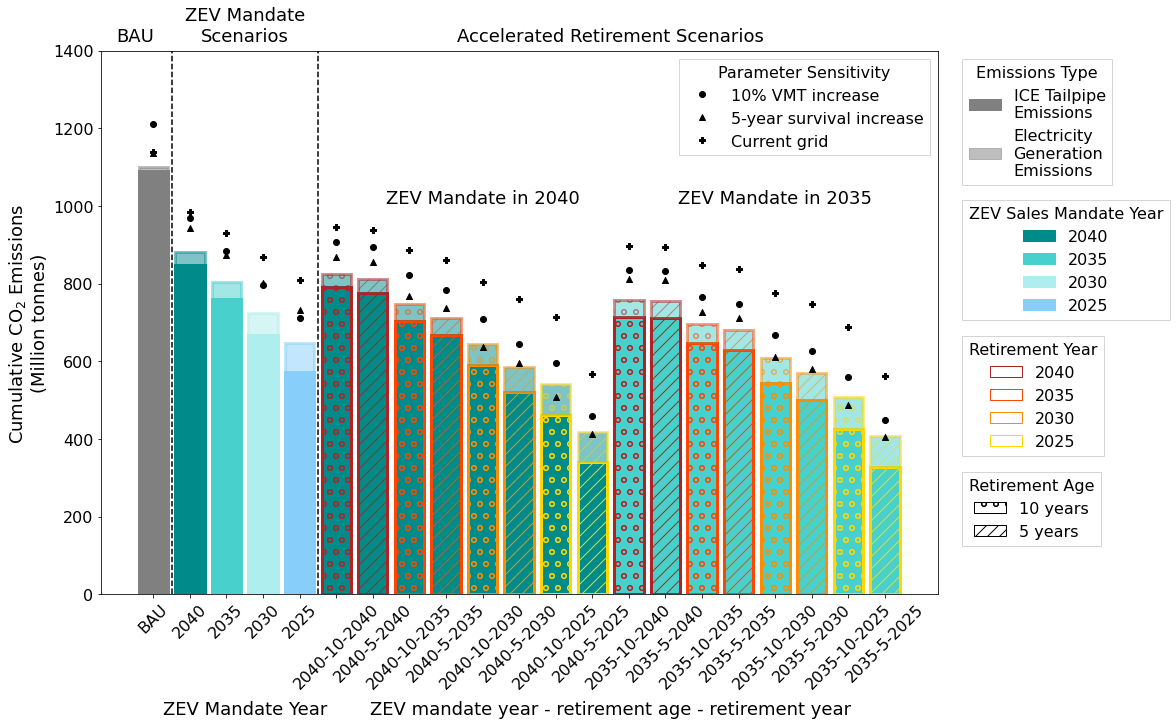

In [123]:
f, ax = plt.subplots(1,1, figsize = (15,10)) #20,8


ax.bar(x= cum_emis.ind_str, height = cum_emis.cum_fossil_emis,color = cum_emis.color, 
       hatch = cum_emis.hatch, edgecolor = cum_emis.outline_color, linewidth = 3)
ax.bar(x= cum_emis.ind_str, height = cum_emis.cum_elec_emis,color = cum_emis.color, 
       hatch = cum_emis.hatch, edgecolor = cum_emis.outline_color, linewidth = 3, alpha = 0.5, bottom = cum_emis.cum_fossil_emis)
ax.scatter(x = cum_emis_vmt.ind_str, y = cum_emis_vmt.tot_emis, color = "black", marker = "o")
ax.scatter(x = cum_emis_surv.ind_str, y = cum_emis_surv.tot_emis, marker = "^", color = "black")
ax.scatter(x = cum_emis_grid.ind_str, y = cum_emis_grid.tot_emis, marker = "P", color = "black")
ax.vlines(0.5,0,1400, linestyles = "dashed", color = "black") 
ax.vlines(4.5,0,1400, linestyles = "dashed", color = "black")
ax.set_ylim([0,1400])
plt.xticks(rotation = 45)
ax.text(-0.5,1400*1.01,"BAU", fontsize = 18, ha = "center", va = "bottom") #-1,1300
ax.text(2.5,1400*1.01,"ZEV Mandate\nScenarios", fontsize = 18, ha = "center", va = "bottom") #0.7,1300
ax.text(12.5,1400*1.01,"Accelerated Retirement Scenarios", fontsize = 18, ha = "center", va = "bottom") #10,1300
ax.set_ylabel("Cumulative CO$_2$ Emissions \n(Million tonnes)", fontsize = 18)
ax.text(9,0.72*1400,"ZEV Mandate in 2040", fontsize = 18, ha = "center") #7,800
ax.text(17,0.72*1400,"ZEV Mandate in 2035", fontsize = 18, ha = "center") #16,800


handles = [
    mpatches.Patch(facecolor=zy_cols[3], hatch='', edgecolor=zy_cols[3], label = "2040"),
    mpatches.Patch(facecolor=zy_cols[2], hatch='', edgecolor=zy_cols[2], label = "2035"),
    mpatches.Patch(facecolor=zy_cols[1], hatch='', edgecolor=zy_cols[1], label = "2030"),
    mpatches.Patch(facecolor=zy_cols[0], hatch='', edgecolor=zy_cols[0], label = "2025"),
        
]

handles2 = [
    mpatches.Patch(facecolor="white", hatch='', edgecolor=ry_cols[3], label = "2040"),
    mpatches.Patch(facecolor="white", hatch='', edgecolor=ry_cols[2], label = "2035"),
    mpatches.Patch(facecolor="white", hatch='', edgecolor=ry_cols[1], label = "2030"),
    mpatches.Patch(facecolor="white", hatch='', edgecolor=ry_cols[0], label = "2025"),

    
]

handles3 = [
    mpatches.Patch(facecolor="white", hatch=ra_hatch[1], edgecolor = "black", label = "10 years"),
    mpatches.Patch(facecolor="white", hatch=ra_hatch[0], edgecolor="black", label = "5 years"),
    
]

handles4 = [
    mpatches.Patch(facecolor="gray", hatch='', edgecolor="gray", label = "ICE Tailpipe\nEmissions"),
    mpatches.Patch(facecolor="gray", hatch='', edgecolor="gray", alpha = 0.5, label = "Electricity\nGeneration\nEmissions")
]

handles5 = [
    plt.Line2D([], [], marker='o', color="black", linestyle = None,label='10% VMT increase', linewidth = 0),
    plt.Line2D([], [], marker='^', color="black", linestyle = None, label='5-year survival increase', linewidth = 0),
    plt.Line2D([], [], marker='P', color="black", linestyle = None, label='Current grid', linewidth = 0)
    
]


zy_cols = ["lightskyblue","paleturquoise","mediumturquoise","darkcyan"]#["gold","thistle","mediumturquoise","lightcoral"]
ry_cols = ["gold","darkorange","orangered","firebrick"]#["midnightblue","orange","brown","pink"]
ra_hatch = ["//","o"]




# handles = [
#     mpatches.Patch(facecolor='red', hatch='/', edgecolor='black', label = "2025"),
#     mpatches.Patch(facecolor='green', hatch='\\', edgecolor='black'),
#     mpatches.Patch(facecolor='blue', hatch='|', edgecolor='black'),
#     mpatches.Patch(facecolor='yellow', hatch='-', edgecolor='black'),
#     plt.Line2D([], [], linestyle='dashed', color='black'),
#     plt.Line2D([], [], marker='', color='white', label='BAU'),
#     plt.Line2D([], [], marker='', color='white', label='ZEV Mandate Scenarios'),
#     plt.Line2D([], [], marker='', color='white', label='Accelerated Retirement Scenarios')
# ]

# Create the legend and add it to the plot
l1 = ax.legend(handles=handles,loc='upper left', bbox_to_anchor=(1.02, 0.74), title = "ZEV Sales Mandate Year", fancybox = False, fontsize = 16)
l1.get_title().set_fontsize(16)
# l1.get_title().set_ha('left')
l2 = ax.legend(handles=handles2, loc='upper left', bbox_to_anchor=(1.02, 0.49), title = "Retirement Year", fancybox = False, fontsize = 16)
l2.get_title().set_fontsize(16)
# l2.get_title().set_ha('left')
l3 = ax.legend(handles=handles3, loc='upper left', bbox_to_anchor=(1.02, 0.24), title = "Retirement Age", fancybox = False, fontsize = 16)
l3.get_title().set_fontsize(16)
# l3.get_title().set_ha('left')
l4 = ax.legend(handles=handles4, loc='upper left', bbox_to_anchor=(1.02, 1), title = "Emissions Type", fancybox = False, fontsize = 16)
l4.get_title().set_fontsize(16)
# l4.get_title().set_ha('left')
l5 = ax.legend(handles=handles5, loc='upper left', bbox_to_anchor=(0.682, 1), title = "Parameter Sensitivity", fancybox = False, fontsize = 16)
l5.get_title().set_fontsize(16)

for t in l1.get_texts():
    t.set_ha('left')


ax.add_artist(l1)
ax.add_artist(l2)
ax.add_artist(l3)
ax.add_artist(l4)



 



for tick in ax.get_yticklabels():
    tick.set_fontsize(16)
for tick in ax.get_xticklabels():
    tick.set_fontsize(16)
    
ax.text(2.5, -1400*0.22, "ZEV Mandate Year", fontsize = 18, ha = "center")
ax.text(12.5, -1400*0.22,"ZEV mandate year - retirement age - retirement year", fontsize = 18, ha = "center")

#plt.tight_layout()

# plt.gca().add_artist(l1)
# plt.gca().add_artist(l2)
f.savefig("final_figs/cumulative_emissions_barplot.pdf", bbox_inches = "tight")

##### cum_emis

In [81]:
cum_deaths = pd.DataFrame(index = ["BAU",2040,2035,2030,2025,
        "2040-10-2040","2040-5-2040",
        "2040-10-2035","2040-5-2035",
        "2040-10-2030","2040-5-2030",
        "2040-10-2025","2040-5-2025",
        "2035-10-2040","2035-5-2040",
        "2035-10-2035","2035-5-2035",
        "2035-10-2030","2035-5-2030",
        "2035-10-2025","2035-5-2025"], 
                       columns = ["cum_deaths","zev_year","ret_year","ret_age","color","outline_color","hatch"])

In [82]:
zev_mandate_emissions = pd.DataFrame(index = np.arange(2019,2046), columns = ["BAU",2025,2030,2035,2040])
for y in zev_mandate_emissions.index:
    zev_mandate_emissions.loc[y,"BAU"] = BAU_all.loc[BAU_all.year==y,"co2"].sum()/1e6
    for z in [2025,2030,2035,2040]:
        zev_mandate_emissions.loc[y,z] = results_all[z].loc[results_all[z].year==y,"co2"].sum()/1e6

In [83]:
retirements_emissions = {}
for zy in [2035,2040]:
    retirements_emissions[zy] = {}
    for ra in [5,10]:
        retirements_emissions[zy][ra] = pd.DataFrame(index = np.arange(2019,2046), columns = ["BAU",2025,2030,2035,2040])
        for y in np.arange(2019, 2046):
            retirements_emissions[zy][ra].loc[y,"BAU"] = BAU_all.loc[BAU_all.year==y,"co2"].sum()/1e6
            for ry in [2025, 2030, 2035, 2040]:
                retirements_emissions[zy][ra].loc[y,ry] = results_all_rets[f"{zy}-{ra}-{ry}"].loc[results_all_rets[f"{zy}-{ra}-{ry}"]["year"]==y,"co2"].sum()/1e6
        

In [84]:
zev_mandate_emissions_e = pd.DataFrame(index = np.arange(2019,2046), columns = ["BAU",2025,2030,2035,2040])
for y in zev_mandate_emissions_e.index:
    zev_mandate_emissions_e.loc[y,"BAU"] = BAU_all.loc[(BAU_all.year==y) & (BAU_all.fuel_type=="Electricity"),"co2"].sum()/1e6
    for z in [2025,2030,2035,2040]:
        zev_mandate_emissions_e.loc[y,z] = results_all[z].loc[(results_all[z].year==y) & (results_all[z].fuel_type=="Electricity"),"co2"].sum()/1e6

In [85]:
retirements_emissions_e = {}
for zy in [2035,2040]:
    retirements_emissions_e[zy] = {}
    for ra in [5,10]:
        retirements_emissions_e[zy][ra] = pd.DataFrame(index = np.arange(2019,2046), columns = ["BAU",2025,2030,2035,2040])
        for y in np.arange(2019, 2046):
            retirements_emissions_e[zy][ra].loc[y,"BAU"] = BAU_all.loc[(BAU_all.year==y) & (BAU_all.fuel_type=="Electricity"),"co2"].sum()/1e6
            for ry in [2025, 2030, 2035, 2040]:
                retirements_emissions_e[zy][ra].loc[y,ry] = results_all_rets[f"{zy}-{ra}-{ry}"].loc[(results_all_rets[f"{zy}-{ra}-{ry}"]["year"]==y) &
                                                                                                    (results_all_rets[f"{zy}-{ra}-{ry}"]["fuel_type"]=="Electricity"),"co2"].sum()/1e6
   

In [86]:
zev_mandate_emissions_t = pd.DataFrame(index = np.arange(2019,2046), columns = ["BAU",2025,2030,2035,2040])
for y in zev_mandate_emissions_t.index:
    zev_mandate_emissions_t.loc[y,"BAU"] = BAU_all.loc[(BAU_all.year==y) & (BAU_all.fuel_type.isin(["Diesel","Natural Gas", "Gasoline"])),"co2"].sum()/1e6
    for z in [2025,2030,2035,2040]:
        zev_mandate_emissions_t.loc[y,z] = results_all[z].loc[(results_all[z].year==y) & (results_all[z].fuel_type.isin(["Diesel","Natural Gas", "Gasoline"])),"co2"].sum()/1e6

In [87]:
retirements_emissions_t = {}
for zy in [2035,2040]:
    retirements_emissions_t[zy] = {}
    for ra in [5,10]:
        retirements_emissions_t[zy][ra] = pd.DataFrame(index = np.arange(2019,2046), columns = ["BAU",2025,2030,2035,2040])
        for y in np.arange(2019, 2046):
            retirements_emissions_t[zy][ra].loc[y,"BAU"] = BAU_all.loc[(BAU_all.year==y) & (BAU_all.fuel_type.isin(["Diesel","Natural Gas", "Gasoline"])),"co2"].sum()/1e6
            for ry in [2025, 2030, 2035, 2040]:
                retirements_emissions_t[zy][ra].loc[y,ry] = results_all_rets[f"{zy}-{ra}-{ry}"].loc[(results_all_rets[f"{zy}-{ra}-{ry}"]["year"]==y) &
                                                                                                    (results_all_rets[f"{zy}-{ra}-{ry}"]["fuel_type"].isin(["Diesel","Natural Gas", "Gasoline"])),"co2"].sum()/1e6
  

In [88]:
zy_cols = ["lightskyblue","paleturquoise","mediumturquoise","darkcyan"]#["gold","thistle","mediumturquoise","lightcoral"]
ry_cols = ["gold","darkorange","orangered","firebrick"]#["midnightblue","orange","brown","pink"]



In [89]:
zev_mandate_stock = pd.DataFrame(index = np.arange(2019,2046), columns = ["BAU",2025,2030,2035,2040])
for y in zev_mandate_stock.index:
    zev_mandate_stock.loc[y,"BAU"] = BAU_all.loc[(BAU_all.year==y) & (BAU_all.fuel_type.isin(["Diesel","Natural Gas","Gasoline"])),"stock"].sum()/1e6
    for z in [2025,2030,2035,2040]:
        zev_mandate_stock.loc[y,z] = results_all[z].loc[(results_all[z].year==y) & (results_all[z].fuel_type.isin(["Diesel","Natural Gas","Gasoline"])),"stock"].sum()/1e6
        
retirements_stock = {}
for zy in [2035,2040]:
    retirements_stock[zy] = {}
    for ra in [5,10]:
        retirements_stock[zy][ra] = pd.DataFrame(index = np.arange(2019,2046), columns = ["BAU",2025,2030,2035,2040])
        for y in np.arange(2019, 2046):
            retirements_stock[zy][ra].loc[y,"BAU"] = BAU_all.loc[(BAU_all.year==y) & (BAU_all.fuel_type.isin(["Diesel","Natural Gas","Gasoline"])),"stock"].sum()/1e6
            for ry in [2025, 2030, 2035, 2040]:
                retirements_stock[zy][ra].loc[y,ry] = results_all_rets[f"{zy}-{ra}-{ry}"].loc[(results_all_rets[f"{zy}-{ra}-{ry}"]["year"]==y) & (results_all_rets[f"{zy}-{ra}-{ry}"]["fuel_type"].isin(["Diesel","Natural Gas","Gasoline"])),"stock"].sum()/1e6
  

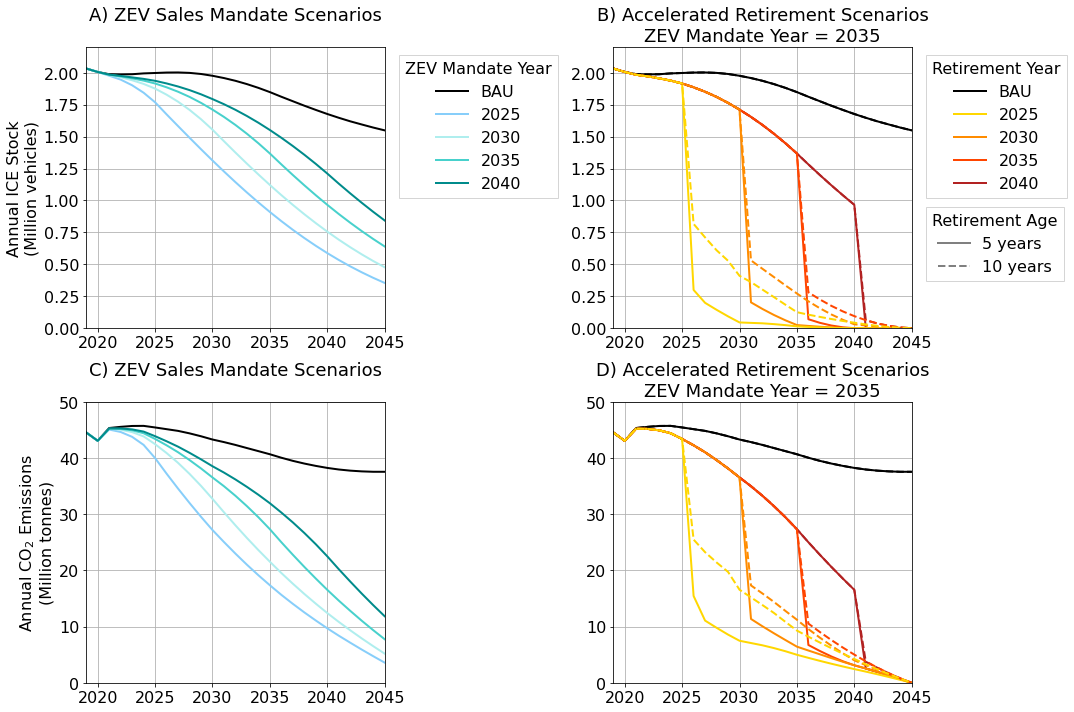

In [124]:
f, ax = plt.subplots(2,2, figsize = (15, 10))
ax = ax.flatten()

zev_mandate_stock.plot(ax = ax[0], color = ["black","lightskyblue","paleturquoise","mediumturquoise","darkcyan"], linewidth = 2)
retirements_stock[2035][5][["BAU",2040,2035,2030,2025]].plot(ax = ax[1], color = ["black","firebrick","orangered","darkorange","gold"], linewidth = 2)
retirements_stock[2035][10][["BAU",2040,2035,2030,2025]].plot(ax = ax[1], linestyle = "dashed", color = ["black","firebrick","orangered","darkorange","gold"], linewidth = 2)

ax[0].set_ylabel("Annual ICE Stock\n(Million vehicles)", fontsize = 16)
ax[0].set_title("A) ZEV Sales Mandate Scenarios\n ", fontsize = 18)
ax[1].set_title("B) Accelerated Retirement Scenarios\nZEV Mandate Year = 2035", fontsize = 18)
ax[0].grid()
ax[1].grid()


handles = [
    plt.Line2D([], [], linestyle='solid', color='black', label = "BAU", linewidth = 2),
    plt.Line2D([], [], marker='', color=zy_cols[0], label='2025', linewidth = 2),
    plt.Line2D([], [], marker='', color=zy_cols[1], label='2030', linewidth = 2),
    plt.Line2D([], [], marker='', color=zy_cols[2], label='2035', linewidth = 2),
    plt.Line2D([], [], marker='', color=zy_cols[3], label='2040', linewidth = 2),    
]

handles2 = [
    plt.Line2D([], [], linestyle='solid', color='black', label = "BAU", linewidth = 2),
    plt.Line2D([], [], marker='', color=ry_cols[0], label='2025', linewidth = 2),
    plt.Line2D([], [], marker='', color=ry_cols[1], label='2030', linewidth = 2),
    plt.Line2D([], [], marker='', color=ry_cols[2], label='2035', linewidth = 2),
    plt.Line2D([], [], marker='', color=ry_cols[3], label='2040', linewidth = 2),    
]

handles3 = [
    plt.Line2D([], [], marker='', color="gray", linestyle = "solid",label='5 years', linewidth = 2),
    plt.Line2D([], [], marker='', color=r"gray", linestyle = "dashed", label='10 years', linewidth = 2),
    
]


l0 = ax[0].legend(handles=handles, loc='upper left', bbox_to_anchor=(1.02, 1), title = "ZEV Mandate Year", fancybox = False, fontsize = 16)
l0.get_title().set_fontsize(16)
l1 = ax[1].legend(handles=handles2, loc='upper left', bbox_to_anchor=(1.02, 1), title = "Retirement Year", fancybox = False, fontsize = 16)
l1.get_title().set_fontsize(16)
l2 = ax[1].legend(handles=handles3, loc='upper left', bbox_to_anchor=(1.02, 0.46), title = "Retirement Age", fancybox = False, fontsize = 16)
l2.get_title().set_fontsize(16)
ax[1].add_artist(l1)

for tick in ax[0].get_yticklabels():
    tick.set_fontsize(16)
for tick in ax[0].get_xticklabels():
    tick.set_fontsize(16)
for tick in ax[1].get_yticklabels():
    tick.set_fontsize(16)
for tick in ax[1].get_xticklabels():
    tick.set_fontsize(16)
ax[0].set_xlim([2019, 2045])
ax[1].set_xlim([2019, 2045])
ax[0].set_ylim([0,2.2])
ax[1].set_ylim([0,2.2])

zev_mandate_emissions.plot(ax = ax[2], color = ["black","lightskyblue","paleturquoise","mediumturquoise","darkcyan"], linewidth = 2, legend = False)
retirements_emissions[2035][5][["BAU",2040,2035,2030,2025]].plot(ax = ax[3], color = ["black","firebrick","orangered","darkorange","gold"], linewidth = 2, legend = False)
retirements_emissions[2035][10][["BAU",2040,2035,2030,2025]].plot(ax = ax[3], linestyle = "dashed", color = ["black","firebrick","orangered","darkorange","gold"], linewidth = 2, legend = False)

ax[2].set_ylabel("Annual CO$_2$ Emissions\n(Million tonnes)", fontsize = 16)
ax[2].set_title("C) ZEV Sales Mandate Scenarios\n ", fontsize = 18)
ax[3].set_title("D) Accelerated Retirement Scenarios\nZEV Mandate Year = 2035", fontsize = 18)
ax[2].grid()
ax[3].grid()


handles = [
    plt.Line2D([], [], linestyle='solid', color='black', label = "BAU", linewidth = 2),
    plt.Line2D([], [], marker='', color=zy_cols[0], label='2025', linewidth = 2),
    plt.Line2D([], [], marker='', color=zy_cols[1], label='2030', linewidth = 2),
    plt.Line2D([], [], marker='', color=zy_cols[2], label='2035', linewidth = 2),
    plt.Line2D([], [], marker='', color=zy_cols[3], label='2040', linewidth = 2),    
]

handles2 = [
    plt.Line2D([], [], linestyle='solid', color='black', label = "BAU", linewidth = 2),
    plt.Line2D([], [], marker='', color=ry_cols[0], label='2025', linewidth = 2),
    plt.Line2D([], [], marker='', color=ry_cols[1], label='2030', linewidth = 2),
    plt.Line2D([], [], marker='', color=ry_cols[2], label='2035', linewidth = 2),
    plt.Line2D([], [], marker='', color=ry_cols[3], label='2040', linewidth = 2),    
]

handles3 = [
    plt.Line2D([], [], marker='', color="gray", linestyle = "solid",label='5 years', linewidth = 2),
    plt.Line2D([], [], marker='', color=r"gray", linestyle = "dashed", label='10 years', linewidth = 2),
    
]


# l0 = ax[2].legend(handles=handles, loc='upper left', bbox_to_anchor=(1.02, 1), title = "ZEV Mandate Year", fancybox = False, fontsize = 14)
# l0.get_title().set_fontsize(14)
# l1 = ax[3].legend(handles=handles2, loc='upper left', bbox_to_anchor=(1.02, 1), title = "Retirement Year", fancybox = False, fontsize = 14)
# l1.get_title().set_fontsize(14)
# l2 = ax[2].legend(handles=handles3, loc='upper left', bbox_to_anchor=(1.02, 0.5), title = "Retirement Age", fancybox = False, fontsize = 14)
# l2.get_title().set_fontsize(14)
# ax[3].add_artist(l1)

for tick in ax[2].get_yticklabels():
    tick.set_fontsize(16)
for tick in ax[2].get_xticklabels():
    tick.set_fontsize(16)
for tick in ax[3].get_yticklabels():
    tick.set_fontsize(16)
for tick in ax[3].get_xticklabels():
    tick.set_fontsize(16)
ax[2].set_xlim([2019, 2045])
ax[3].set_xlim([2019, 2045])
ax[2].set_ylim([0,50])
ax[3].set_ylim([0,50])

plt.tight_layout()
f.savefig("final_figs/stock_and_emissions.pdf")

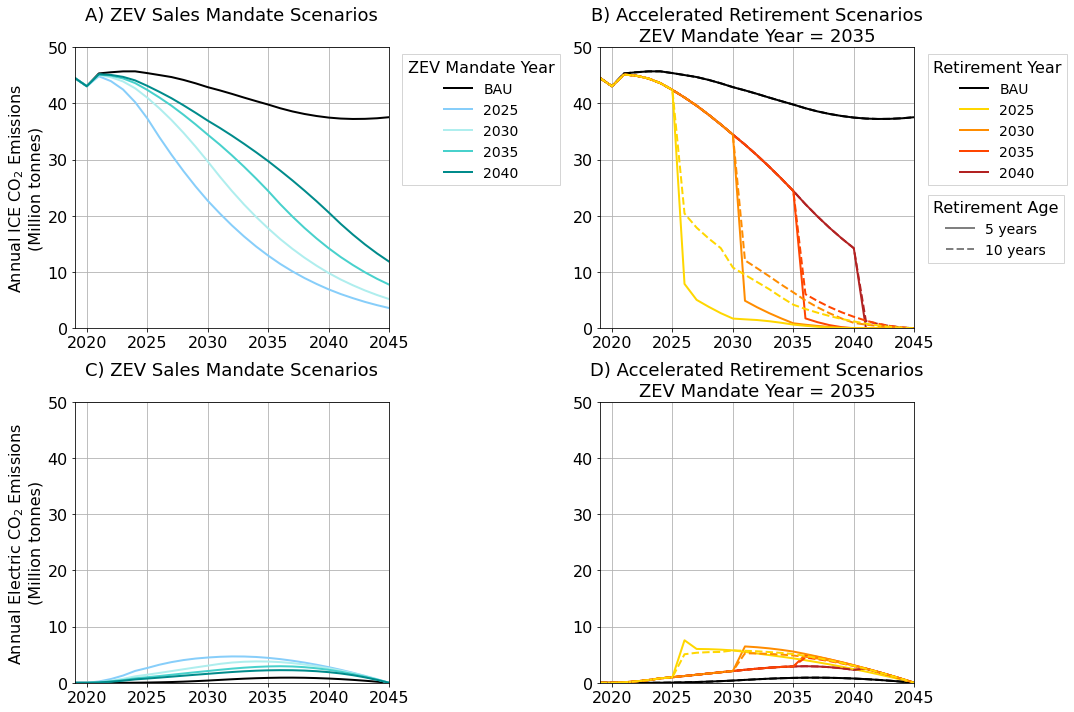

In [125]:
f, ax = plt.subplots(2,2, figsize = (15, 10))
ax = ax.flatten()



zev_mandate_emissions_t.plot(ax = ax[0], color = ["black","lightskyblue","paleturquoise","mediumturquoise","darkcyan"], linewidth = 2, legend = False)
retirements_emissions_t[2035][5][["BAU",2040,2035,2030,2025]].plot(ax = ax[1], color = ["black","firebrick","orangered","darkorange","gold"], linewidth = 2, legend = False)
retirements_emissions_t[2035][10][["BAU",2040,2035,2030,2025]].plot(ax = ax[1], linestyle = "dashed", color = ["black","firebrick","orangered","darkorange","gold"], linewidth = 2, legend = False)

ax[0].set_ylabel("Annual ICE CO$_2$ Emissions \n(Million tonnes)", fontsize = 16)
ax[0].set_title("A) ZEV Sales Mandate Scenarios\n ", fontsize = 18)
ax[1].set_title("B) Accelerated Retirement Scenarios\nZEV Mandate Year = 2035", fontsize = 18)
ax[0].grid()
ax[1].grid()

for tick in ax[0].get_yticklabels():
    tick.set_fontsize(16)
for tick in ax[1].get_xticklabels():
    tick.set_fontsize(16)
for tick in ax[0].get_xticklabels():
    tick.set_fontsize(16)
for tick in ax[1].get_yticklabels():
    tick.set_fontsize(16)
ax[0].set_xlim([2019, 2045])
ax[1].set_xlim([2019, 2045])
ax[0].set_ylim([0,50])
ax[1].set_ylim([0,50])

handles = [
    plt.Line2D([], [], linestyle='solid', color='black', label = "BAU", linewidth = 2),
    plt.Line2D([], [], marker='', color=zy_cols[0], label='2025', linewidth = 2),
    plt.Line2D([], [], marker='', color=zy_cols[1], label='2030', linewidth = 2),
    plt.Line2D([], [], marker='', color=zy_cols[2], label='2035', linewidth = 2),
    plt.Line2D([], [], marker='', color=zy_cols[3], label='2040', linewidth = 2),    
]

handles2 = [
    plt.Line2D([], [], linestyle='solid', color='black', label = "BAU", linewidth = 2),
    plt.Line2D([], [], marker='', color=ry_cols[0], label='2025', linewidth = 2),
    plt.Line2D([], [], marker='', color=ry_cols[1], label='2030', linewidth = 2),
    plt.Line2D([], [], marker='', color=ry_cols[2], label='2035', linewidth = 2),
    plt.Line2D([], [], marker='', color=ry_cols[3], label='2040', linewidth = 2),    
]

handles3 = [
    plt.Line2D([], [], marker='', color="gray", linestyle = "solid",label='5 years', linewidth = 2),
    plt.Line2D([], [], marker='', color=r"gray", linestyle = "dashed", label='10 years', linewidth = 2),
    
]

l0 = ax[0].legend(handles=handles, loc='upper left', bbox_to_anchor=(1.02, 1), title = "ZEV Mandate Year", fancybox = False, fontsize = 14)
l0.get_title().set_fontsize(16)
l1 = ax[1].legend(handles=handles2, loc='upper left', bbox_to_anchor=(1.02, 1), title = "Retirement Year", fancybox = False, fontsize = 14)
l1.get_title().set_fontsize(16)
l2 = ax[1].legend(handles=handles3, loc='upper left', bbox_to_anchor=(1.02, 0.5), title = "Retirement Age", fancybox = False, fontsize = 14)
l2.get_title().set_fontsize(16)
ax[1].add_artist(l1)

zev_mandate_emissions_e.plot(ax = ax[2], color = ["black","lightskyblue","paleturquoise","mediumturquoise","darkcyan"], linewidth = 2, legend = False)
retirements_emissions_e[2035][5][["BAU",2040,2035,2030,2025]].plot(ax = ax[3], color = ["black","firebrick","orangered","darkorange","gold"], linewidth = 2, legend = False)
retirements_emissions_e[2035][10][["BAU",2040,2035,2030,2025]].plot(ax = ax[3], linestyle = "dashed", color = ["black","firebrick","orangered","darkorange","gold"], linewidth = 2, legend = False)

ax[2].set_ylabel("Annual Electric CO$_2$ Emissions \n(Million tonnes)", fontsize = 16)
ax[2].set_title("C) ZEV Sales Mandate Scenarios\n ", fontsize = 18)
ax[3].set_title("D) Accelerated Retirement Scenarios\nZEV Mandate Year = 2035", fontsize = 18)
ax[2].grid()
ax[3].grid()

for tick in ax[2].get_yticklabels():
    tick.set_fontsize(16)
for tick in ax[2].get_xticklabels():
    tick.set_fontsize(16)
for tick in ax[3].get_yticklabels():
    tick.set_fontsize(16)
for tick in ax[3].get_xticklabels():
    tick.set_fontsize(16)
ax[2].set_xlim([2019, 2045])
ax[3].set_xlim([2019, 2045])
ax[2].set_ylim([0,50])
ax[3].set_ylim([0,50])

plt.tight_layout()
f.savefig("final_figs/annual_emissions_split.pdf")

In [92]:
races = ["Latino","Black","Asian","White","Native","Pac Islander","Two or More"]
    
#     'White',
#  'Black',
#  'Native',
#  'Asian',
#  'Pac Islander',
#  'Two or More',
#  'Latino']

deaths_pc_race = pd.DataFrame(index = ["BAU",2040,2035,2030,2025,
        "2040-10-2040","2040-5-2040",
        "2040-10-2035","2040-5-2035",
        "2040-10-2030","2040-5-2030",
        "2040-10-2025","2040-5-2025",
        "2035-10-2040","2035-5-2040",
        "2035-10-2035","2035-5-2035",
        "2035-10-2030","2035-5-2030",
        "2035-10-2025","2035-5-2025"], 
                       columns = races)

In [93]:
for r in races:
    d = 0
    for v in veh_types:
        d += results["BAU"][v]["Fossil"][f"{r}_deathsK_pc"].sum()
    deaths_pc_race.loc["BAU",r] = d
    for y in zev_years:
        d = 0
        for v in veh_types:
            d += results["ZEV_mandate"][y][v]["Fossil"][f"{r}_deathsK_pc"].sum()
        deaths_pc_race.loc[y,r] = d
    for s in results["retirements"].keys():
        d = 0
        for v in veh_types:
            d += results["retirements"][s][v]["Fossil"][f"{r}_deathsK_pc"].sum()
        deaths_pc_race.loc[s,r] = d
        


<AxesSubplot:>

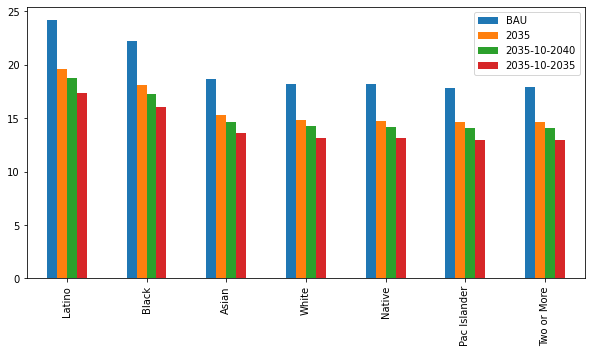

In [94]:
f, ax = plt.subplots(1,1, figsize = (10,5))

deaths_pc_race.T[["BAU",2035,"2035-10-2040","2035-10-2035"]].plot.bar(ax = ax)

In [95]:
incomes = ['<10,000', '10,000-14,999', '15,000 - 24,999', '25,000 - 34,999',
       '35,000 - 49,999', '50,000 - 74,999', '75,000 - 99,999',
       '100,000 - 149,999', '150,000 - 199,999', '>200,000']

In [96]:
races = incomes
    
#     'White',
#  'Black',
#  'Native',
#  'Asian',
#  'Pac Islander',
#  'Two or More',
#  'Latino']

deaths_pc_income = pd.DataFrame(index = ["BAU",2040,2035,2030,2025,
        "2040-10-2040","2040-5-2040",
        "2040-10-2035","2040-5-2035",
        "2040-10-2030","2040-5-2030",
        "2040-10-2025","2040-5-2025",
        "2035-10-2040","2035-5-2040",
        "2035-10-2035","2035-5-2035",
        "2035-10-2030","2035-5-2030",
        "2035-10-2025","2035-5-2025"], 
                       columns = races)

In [97]:
for r in incomes:
    d = 0
    for v in veh_types:
        d += results["BAU"][v]["Fossil"][f"{r}_deathsK_pc"].sum()
    deaths_pc_income.loc["BAU",r] = d
    for y in zev_years:
        d = 0
        for v in veh_types:
            d += results["ZEV_mandate"][y][v]["Fossil"][f"{r}_deathsK_pc"].sum()
        deaths_pc_income.loc[y,r] = d
    for s in results["retirements"].keys():
        d = 0
        for v in veh_types:
            d += results["retirements"][s][v]["Fossil"][f"{r}_deathsK_pc"].sum()
        deaths_pc_income.loc[s,r] = d

In [98]:
races = ["Latino","Black","Asian","White","Native","Pac Islander","Two or More"]
deaths_pc_race_v = pd.DataFrame(index = races, columns = veh_types)
for r in races:
    for v in veh_types:
        deaths_pc_race_v.loc[r,v] = results["BAU"][v]["Fossil"][f"{r}_deathsK_pc"].sum()+results["BAU"][v]["Elec"][f"{r}_deathsK_pc"].sum()

In [99]:
#races = ["Latino","Black","Asian","White","Native","Pac Islander","Two or More"]
deaths_pc_income_v = pd.DataFrame(index = incomes, columns = veh_types)
for r in incomes:
    for v in veh_types:
        deaths_pc_income_v.loc[r,v] = results["BAU"][v]["Fossil"][f"{r}_deathsK_pc"].sum()+results["BAU"][v]["Elec"][f"{r}_deathsK_pc"].sum()

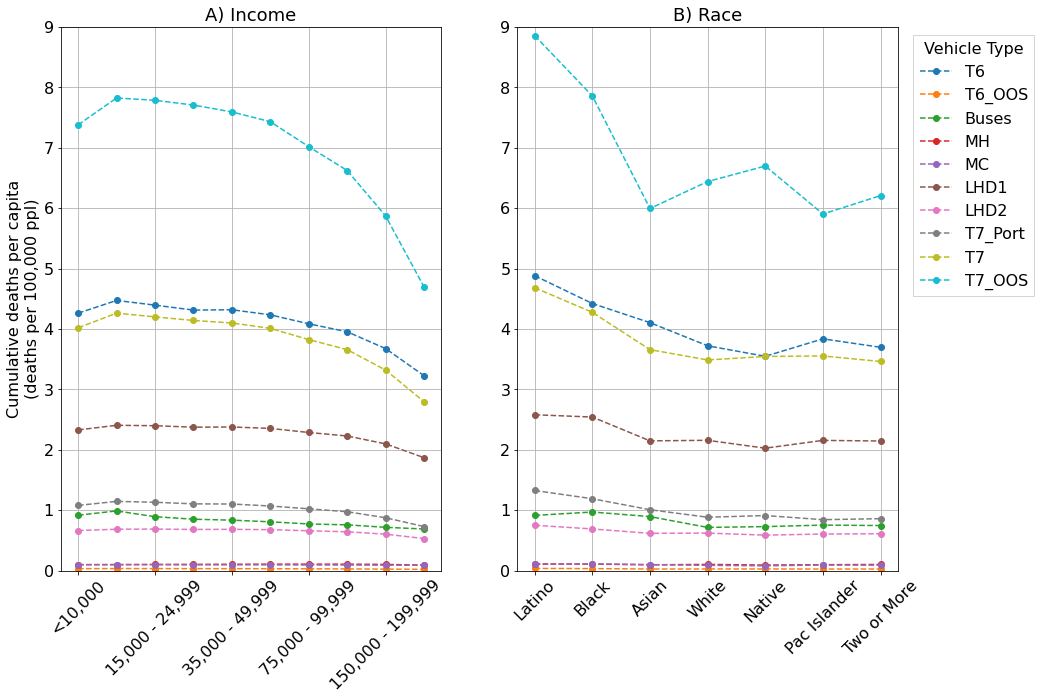

In [126]:
f, ax = plt.subplots(1,2, figsize = (15,10))
ax = ax.flatten()
deaths_pc_income_v.plot(ax = ax[0], marker = 'o', linestyle = "dashed", legend = False)
deaths_pc_race_v.plot(ax = ax[1], marker = 'o', linestyle = "dashed")
ax[0].set_ylabel("Cumulative deaths per capita\n(deaths per 100,000 ppl)", fontsize = 16)
l1 = ax[1].legend(loc='upper left', bbox_to_anchor=(1.02, 1), title = "Vehicle Type", fancybox = False, fontsize = 16)
l1.get_title().set_fontsize(16)
for tick in ax[0].get_yticklabels():
    tick.set_fontsize(16)
for tick in ax[0].get_xticklabels():
    tick.set_fontsize(16)
    tick.set_rotation(45)
for tick in ax[1].get_yticklabels():
    tick.set_fontsize(16)
for tick in ax[1].get_xticklabels():
    tick.set_fontsize(16)
    tick.set_rotation(45)
ax[0].grid()
ax[1].grid()
ax[0].set_title("A) Income", fontsize = 18)
ax[1].set_title("B) Race", fontsize = 18)
ax[0].set_ylim([0,9])
ax[1].set_ylim([0,9])
f.savefig("final_figs/race_income_deaths_pc_ca.pdf", bbox_inches = "tight")

In [103]:
### Cost effectiveness relative to ZEV scenarios
cost_effectiveness = pd.DataFrame(columns = ["veh_type","ret_cost","co2_saved","deaths_saved","cost_per_tonne","cost_per_death","zev_year","ret_year","ret_age"])

for s in results_all_rets.keys():
    zev_year = int(s.split("-")[0])
    for v in veh_types:
        ret_cost = results_all_rets[s].loc[results_all_rets[s]["veh_type"]==v,"used_value"].sum()
        ret_cost_n = results_all_rets[s].loc[results_all_rets[s]["veh_type"]==v,"new_value"].sum()
        co2_saved = results_all[zev_year].loc[results_all[zev_year]["veh_type"]==v,"co2"].sum()-results_all_rets[s].loc[results_all_rets[s]["veh_type"]==v,"co2"].sum()
        deaths_saved = (results["ZEV_mandate"][zev_year][v]["Fossil"]["deathsK_CA"].sum()+ results["ZEV_mandate"][zev_year][v]["Fossil"]["deathsK_OCA"].sum()- 
                        results["retirements"][s][v]["Fossil"]["deathsK_CA"].sum() - results["retirements"][s][v]["Fossil"]["deathsK_OCA"].sum()+
                       results["ZEV_mandate"][zev_year][v]["Elec"]["deathsK_CA"].sum()+ results["ZEV_mandate"][zev_year][v]["Elec"]["deathsK_OCA"].sum()- 
                        results["retirements"][s][v]["Elec"]["deathsK_CA"].sum() - results["retirements"][s][v]["Elec"]["deathsK_OCA"].sum())
        cost_per_tonne = ret_cost/co2_saved
        cost_per_death = ret_cost/deaths_saved
        cost_per_tonne_n = ret_cost_n/co2_saved
        cost_per_death_n = ret_cost_n/deaths_saved
        ce = pd.DataFrame({"veh_type":v,
                                               "ret_cost":ret_cost/1e9,
                                               "ret_cost_n":ret_cost_n/1e9,
                                               "co2_saved":co2_saved/1e6,
                                               "deaths_saved":deaths_saved,
                                               "cost_per_tonne":cost_per_tonne,
                                               "cost_per_death":cost_per_death/1e6,
                                               "zev_year":s.split("-")[0],
                                               "ret_year":s.split("-")[2],
                                               "ret_age":s.split("-")[1]}, index = [0])
        cost_effectiveness = cost_effectiveness.append(ce, ignore_index = True)
cost_effectiveness["zev_year"] = cost_effectiveness["zev_year"].astype(int)
cost_effectiveness["ret_year"] = cost_effectiveness["ret_year"].astype(int)
cost_effectiveness["ret_age"] = cost_effectiveness["ret_age"].astype(int)
 

In [104]:
veh_colors = {
    "T6": "royalblue",
    "T6_OOS": "lightcoral",
    "T7": "darkred",
    "T7_OOS": "darkorange",
    "T7_Port": "lightseagreen",
    "LHD1": "darkslategrey",
    "LHD2": "plum",
    "MC": "lightpink",
    "MH": "darkgoldenrod",
    "Buses": "skyblue"
    
}

In [105]:
ra_shapes = {5:"o",10:"^"}

In [106]:
for v in veh_types:
    cost_effectiveness.loc[cost_effectiveness.veh_type==v,"color"] = veh_colors[v]
for ra in [5,10]:
    cost_effectiveness.loc[cost_effectiveness.ret_age==ra,"marker"] = ra_shapes[ra]
   

In [107]:
for i,ry in enumerate([2025,2030,2035,2040]):
    for j,zy in enumerate([2035,2040]):
        cost_effectiveness.loc[(cost_effectiveness.ret_year==ry) & (cost_effectiveness.zev_year == zy),"x_pos"] = i +j*4

In [108]:
new_price = pd.read_csv("hdv_bev_prices.csv")

In [109]:
cost_effectiveness["co2_value"] = cost_effectiveness["co2_saved"]*51/1e3
cost_effectiveness["deaths_value"] = cost_effectiveness["deaths_saved"]*9.63e6/1e9
cost_effectiveness["total_value"] = cost_effectiveness["co2_value"]+cost_effectiveness["deaths_value"] #in billions of dollars

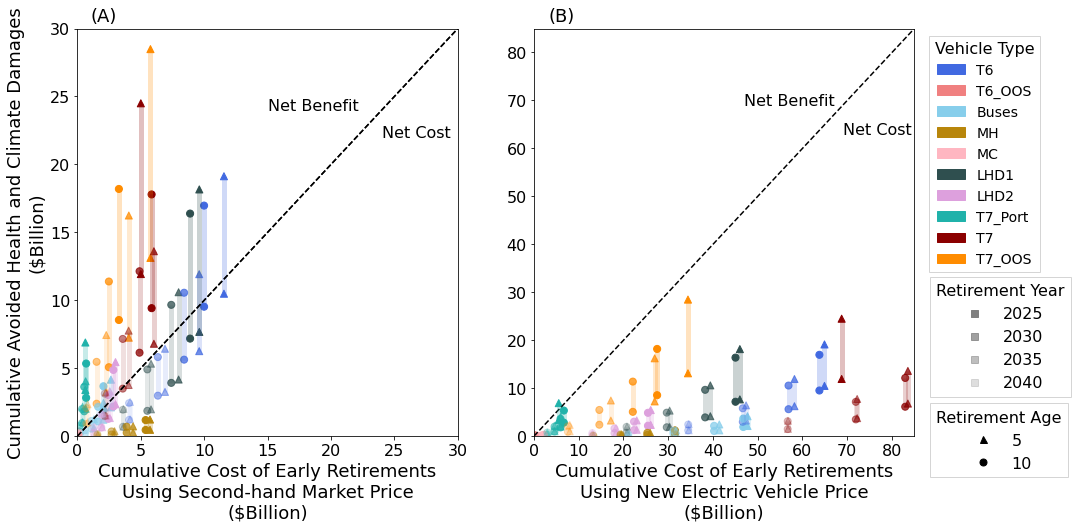

In [177]:
f, ax = plt.subplots(1,2, figsize = (15,7.5))


cost_effectiveness["co2_value"] = cost_effectiveness["co2_saved"]*51/1e3
cost_effectiveness["deaths_value"] = cost_effectiveness["deaths_saved"]*9.63e6/1e9
cost_effectiveness["total_value"] = cost_effectiveness["co2_value"]+cost_effectiveness["deaths_value"] #in billions of dollars
cost_effectiveness["co2_value_low"] = cost_effectiveness["co2_saved"]*51/1e3
cost_effectiveness["total_value_low"] = cost_effectiveness["co2_value_low"]+cost_effectiveness["deaths_value"] #in billions of dollars


for i,z in enumerate(ret_years):
    ax[0].scatter(x = cost_effectiveness[(cost_effectiveness.zev_year==2035) & (cost_effectiveness.ret_age==5) & (cost_effectiveness.ret_year==z)].ret_cost, 
               y = cost_effectiveness[(cost_effectiveness.zev_year==2035)& (cost_effectiveness.ret_age==5)& (cost_effectiveness.ret_year==z)].total_value,
                 color = cost_effectiveness[(cost_effectiveness.zev_year==2035)& (cost_effectiveness.ret_age==5)& (cost_effectiveness.ret_year==z)].color,
                 marker = "^", s = 50, alpha = 1-i*0.25)
    ax[0].scatter(x = cost_effectiveness[(cost_effectiveness.zev_year==2035) & (cost_effectiveness.ret_age==10)& (cost_effectiveness.ret_year==z)].ret_cost, 
               y = cost_effectiveness[(cost_effectiveness.zev_year==2035)& (cost_effectiveness.ret_age==10)& (cost_effectiveness.ret_year==z)].total_value,
                 color = cost_effectiveness[(cost_effectiveness.zev_year==2035)& (cost_effectiveness.ret_age==10)& (cost_effectiveness.ret_year==z)].color,
                 marker = "o", s = 50,alpha = 1-i*0.25)
x = np.linspace(0,30,5)
y = x
ax[0].plot(x,y, linestyle = "dashed",color = "black")
ax[0].set_xlim(0,30)
ax[0].set_ylim(0,30)

cost_effectiveness["co2_value"] = cost_effectiveness["co2_saved"]*190/1e3
cost_effectiveness["deaths_value"] = cost_effectiveness["deaths_saved"]*9.63e6/1e9
cost_effectiveness["total_value"] = cost_effectiveness["co2_value"]+cost_effectiveness["deaths_value"] #in billions of dollars
for i,z in enumerate(ret_years):
    ax[0].scatter(x = cost_effectiveness[(cost_effectiveness.zev_year==2035) & (cost_effectiveness.ret_age==5) & (cost_effectiveness.ret_year==z)].ret_cost, 
               y = cost_effectiveness[(cost_effectiveness.zev_year==2035)& (cost_effectiveness.ret_age==5)& (cost_effectiveness.ret_year==z)].total_value,
                 color = cost_effectiveness[(cost_effectiveness.zev_year==2035)& (cost_effectiveness.ret_age==5)& (cost_effectiveness.ret_year==z)].color,
                 marker = "^", s = 50, alpha = 1-i*0.25)
    ax[0].scatter(x = cost_effectiveness[(cost_effectiveness.zev_year==2035) & (cost_effectiveness.ret_age==10)& (cost_effectiveness.ret_year==z)].ret_cost, 
               y = cost_effectiveness[(cost_effectiveness.zev_year==2035)& (cost_effectiveness.ret_age==10)& (cost_effectiveness.ret_year==z)].total_value,
                 color = cost_effectiveness[(cost_effectiveness.zev_year==2035)& (cost_effectiveness.ret_age==10)& (cost_effectiveness.ret_year==z)].color,
                 marker = "o", s = 50,alpha = 1-i*0.25)
    ax[0].vlines(cost_effectiveness[(cost_effectiveness.zev_year==2035) & (cost_effectiveness.ret_year==z)].ret_cost,
                cost_effectiveness[(cost_effectiveness.zev_year==2035)& (cost_effectiveness.ret_year==z)].total_value_low,
                cost_effectiveness[(cost_effectiveness.zev_year==2035)&  (cost_effectiveness.ret_year==z)].total_value,
                color = cost_effectiveness[(cost_effectiveness.zev_year==2035)&  (cost_effectiveness.ret_year==z)].color,
                 alpha = (1-i*0.25)*0.25, linestyle = "solid", linewidth = 5)
x = np.linspace(0,30,5)
y = x
ax[0].plot(x,y, linestyle = "dashed",color = "black")
ax[0].set_xlim(0,30)
ax[0].set_ylim(0,30)


cost_effectiveness["co2_value"] = cost_effectiveness["co2_saved"]*51/1e3
cost_effectiveness["deaths_value"] = cost_effectiveness["deaths_saved"]*9.63e6/1e9
cost_effectiveness["total_value"] = cost_effectiveness["co2_value"]+cost_effectiveness["deaths_value"] #in billions of dollars


for i,z in enumerate(ret_years):
    ax[1].scatter(x = cost_effectiveness[(cost_effectiveness.zev_year==2035) & (cost_effectiveness.ret_age==5) & (cost_effectiveness.ret_year==z)].ret_cost_n, 
               y = cost_effectiveness[(cost_effectiveness.zev_year==2035)& (cost_effectiveness.ret_age==5)& (cost_effectiveness.ret_year==z)].total_value,
                 color = cost_effectiveness[(cost_effectiveness.zev_year==2035)& (cost_effectiveness.ret_age==5)& (cost_effectiveness.ret_year==z)].color,
                 marker = "^", s = 50, alpha = 1-i*0.25)
    ax[1].scatter(x = cost_effectiveness[(cost_effectiveness.zev_year==2035) & (cost_effectiveness.ret_age==10)& (cost_effectiveness.ret_year==z)].ret_cost_n, 
               y = cost_effectiveness[(cost_effectiveness.zev_year==2035)& (cost_effectiveness.ret_age==10)& (cost_effectiveness.ret_year==z)].total_value,
                 color = cost_effectiveness[(cost_effectiveness.zev_year==2035)& (cost_effectiveness.ret_age==10)& (cost_effectiveness.ret_year==z)].color,
                 marker = "o", s = 50,alpha = 1-i*0.25)
x = np.linspace(0,85,5)
y = x
ax[1].plot(x,y, linestyle = "dashed",color = "black")
ax[1].set_xlim([0,85])
ax[1].set_ylim([0,85])

cost_effectiveness["co2_value"] = cost_effectiveness["co2_saved"]*190/1e3
cost_effectiveness["deaths_value"] = cost_effectiveness["deaths_saved"]*9.63e6/1e9
cost_effectiveness["total_value"] = cost_effectiveness["co2_value"]+cost_effectiveness["deaths_value"] #in billions of dollars


for i,z in enumerate(ret_years):
    ax[1].scatter(x = cost_effectiveness[(cost_effectiveness.zev_year==2035) & (cost_effectiveness.ret_age==5) & (cost_effectiveness.ret_year==z)].ret_cost_n, 
               y = cost_effectiveness[(cost_effectiveness.zev_year==2035)& (cost_effectiveness.ret_age==5)& (cost_effectiveness.ret_year==z)].total_value,
                 color = cost_effectiveness[(cost_effectiveness.zev_year==2035)& (cost_effectiveness.ret_age==5)& (cost_effectiveness.ret_year==z)].color,
                 marker = "^", s = 50, alpha = 1-i*0.25)
    ax[1].scatter(x = cost_effectiveness[(cost_effectiveness.zev_year==2035) & (cost_effectiveness.ret_age==10)& (cost_effectiveness.ret_year==z)].ret_cost_n, 
               y = cost_effectiveness[(cost_effectiveness.zev_year==2035)& (cost_effectiveness.ret_age==10)& (cost_effectiveness.ret_year==z)].total_value,
                 color = cost_effectiveness[(cost_effectiveness.zev_year==2035)& (cost_effectiveness.ret_age==10)& (cost_effectiveness.ret_year==z)].color,
                 marker = "o", s = 50,alpha = 1-i*0.25)
    ax[1].vlines(cost_effectiveness[(cost_effectiveness.zev_year==2035) & (cost_effectiveness.ret_year==z)].ret_cost_n,
                cost_effectiveness[(cost_effectiveness.zev_year==2035)& (cost_effectiveness.ret_year==z)].total_value_low,
                cost_effectiveness[(cost_effectiveness.zev_year==2035)&  (cost_effectiveness.ret_year==z)].total_value,
                color = cost_effectiveness[(cost_effectiveness.zev_year==2035)&  (cost_effectiveness.ret_year==z)].color,
                 alpha = (1-i*0.25)*0.25, linestyle = "solid", linewidth = 5)
    
ax[0].set_ylabel("Cumulative Avoided Health and Climate Damages\n($Billion)", fontsize = 18)
ax[0].set_xlabel("Cumulative Cost of Early Retirements\nUsing Second-hand Market Price\n($Billion)", fontsize = 18)
ax[1].set_xlabel("Cumulative Cost of Early Retirements\nUsing New Electric Vehicle Price\n($Billion)", fontsize = 18)
ax[0].text(15,24,"Net Benefit", fontsize = 16)
ax[0].text(24,22,"Net Cost", fontsize = 16)

ax[1].text(47,69,"Net Benefit", fontsize = 16)
ax[1].text(69,63,"Net Cost", fontsize = 16)


for tick in ax[0].get_yticklabels():
    tick.set_fontsize(16)
for tick in ax[0].get_xticklabels():
    tick.set_fontsize(16)
    
for tick in ax[1].get_yticklabels():
    tick.set_fontsize(16)
for tick in ax[1].get_xticklabels():
    tick.set_fontsize(16)

handles = [mpatches.Patch(facecolor=veh_colors[v], hatch='', edgecolor=veh_colors[v], label = veh_types[i]) for i,v in enumerate(veh_types)]
l0 = ax[1].legend(handles=handles, loc='upper left', bbox_to_anchor=(1.02, 1), title = "Vehicle Type", fancybox = False, fontsize = 14)
l0.get_title().set_fontsize(16)

handles2 = [
    plt.Line2D([], [], linestyle='none', color='black', label = "5", marker = "^", markersize = 7),
    plt.Line2D([], [], linestyle='none', color='black', label = "10", marker = "o", markersize = 7)
]

handles3 = [plt.Line2D([], [], linestyle='none', color='gray', label = ret_years[0], marker = "s", markersize = 7, alpha = 1),
           plt.Line2D([], [], linestyle='none', color='gray', label = ret_years[1], marker = "s", markersize = 7, alpha = 1-1*0.25),
           plt.Line2D([], [], linestyle='none', color='gray', label = ret_years[2], marker = "s", markersize = 7, alpha = 1-2*0.25),
           plt.Line2D([], [], linestyle='none', color='gray', label = ret_years[3], marker = "s", markersize = 7, alpha = 1-3*0.25)]

l1 = ax[1].legend(handles=handles2, loc='upper left', bbox_to_anchor=(1.02, 0.1), title = "Retirement Age", fancybox = False, fontsize = 16)
l1.get_title().set_fontsize(16)

l2 = ax[1].legend(handles=handles3, loc='upper left', bbox_to_anchor=(1.02, 0.41), title = "Retirement Year", fancybox = False, fontsize = 16)
l2.get_title().set_fontsize(16)
ax[1].add_artist(l1)
ax[1].add_artist(l0)
#ax.set_title("SCC = $190/tonne\nNew BEV Price", fontsize = 14)

ax[0].text(1,30.5,"(A)", fontsize = 18)
ax[1].text(3.2,86.5,"(B)", fontsize = 18)
#plt.tight_layout()

f.savefig("final_figs/cost_plot_all.pdf", bbox_inches = "tight")


In [ ]:
cum_deaths = pd.DataFrame(index = ["BAU",2040,2035,2030,2025,
        "2040-10-2040","2040-5-2040",
        "2040-10-2035","2040-5-2035",
        "2040-10-2030","2040-5-2030",
        "2040-10-2025","2040-5-2025",
        "2035-10-2040","2035-5-2040",
        "2035-10-2035","2035-5-2035",
        "2035-10-2030","2035-5-2030",
        "2035-10-2025","2035-5-2025"], 
                       columns = ["cum_deaths","zev_year","ret_year","ret_age","color","outline_color","hatch"])

In [112]:
cum_deaths.loc["BAU","cum_deaths"] = 0
for v in veh_types:
    cum_deaths.loc["BAU","cum_deaths"]+=(results["BAU"][v]["Fossil"]["deathsK_CA"].sum()+
                                         results["BAU"][v]["Fossil"]["deathsK_OCA"].sum()+
                                        results["BAU"][v]["Elec"]["deathsK_CA"].sum()+
                                         results["BAU"][v]["Elec"]["deathsK_OCA"].sum())
cum_deaths.loc["BAU","zev_year"] = 100
cum_deaths.loc["BAU","ret_year"] = 100
cum_deaths.loc["BAU","ret_age"] = 100

for y in [2025, 2030, 2035, 2040]:
    cum_deaths.loc[y,"cum_deaths"] = 0
    for v in veh_types:
        cum_deaths.loc[y,"cum_deaths"] += (results["ZEV_mandate"][y][v]["Fossil"]["deathsK_CA"].sum()+
                                           results["ZEV_mandate"][y][v]["Fossil"]["deathsK_OCA"].sum()+
                                          results["ZEV_mandate"][y][v]["Elec"]["deathsK_CA"].sum()+
                                           results["ZEV_mandate"][y][v]["Elec"]["deathsK_OCA"].sum())
    cum_deaths.loc[y,"zev_year"] = y
    cum_deaths.loc[y,"ret_year"] = 100
    cum_deaths.loc[y,"ret_age"] = 100
for s in results_all_rets.keys():
    cum_deaths.loc[s,"cum_deaths"] = 0
    for v in veh_types:
        cum_deaths.loc[s,"cum_deaths"]+=(results["retirements"][s][v]["Fossil"]["deathsK_CA"].sum()+
                                         results["retirements"][s][v]["Fossil"]["deathsK_OCA"].sum()+
                                        results["retirements"][s][v]["Elec"]["deathsK_CA"].sum()+
                                         results["retirements"][s][v]["Elec"]["deathsK_OCA"].sum())
    cum_deaths.loc[s,"zev_year"] = int(s.split("-")[0])
    cum_deaths.loc[s,"ret_year"] = int(s.split("-")[2])
    cum_deaths.loc[s,"ret_age"] = int(s.split("-")[1])

cum_deaths["ind_str"] = cum_deaths.index
cum_deaths["ind_str"] = cum_deaths["ind_str"].astype("str")

zy_cols = ["lightskyblue","paleturquoise","mediumturquoise","darkcyan"]#["gold","thistle","mediumturquoise","lightcoral"]
ry_cols = ["gold","darkorange","orangered","firebrick"]#["midnightblue","orange","brown","pink"]
ra_hatch = ["//","o"]

cum_deaths.loc["BAU","color"] = "gray"
cum_deaths.loc["BAU","hatch"] = ""
cum_deaths.loc["BAU","outline_color"] = "gray"
for i,zy in enumerate([2025, 2030,2035,2040]):
    cum_deaths.loc[cum_deaths.zev_year==zy,"color"] = zy_cols[i]
    cum_deaths.loc[cum_deaths.zev_year==zy,"hatch"] = ""
    cum_deaths.loc[cum_deaths.zev_year==zy,"outline_color"] = zy_cols[i] 
for i,ry in enumerate([2025,2030,2035,2040]):
    print(i,ry)
    cum_deaths.loc[cum_deaths.ret_year==ry,"outline_color"] = ry_cols[i]
for i, ra in enumerate([5,10]):
    cum_deaths.loc[cum_deaths.ret_age==ra,"hatch"] = ra_hatch[i]


0 2025
1 2030
2 2035
3 2040


In [113]:
cum_deaths_vmt = pd.DataFrame(index = ["BAU",2040,2035,2030,2025,
        "2040-10-2040","2040-5-2040",
        "2040-10-2035","2040-5-2035",
        "2040-10-2030","2040-5-2030",
        "2040-10-2025","2040-5-2025",
        "2035-10-2040","2035-5-2040",
        "2035-10-2035","2035-5-2035",
        "2035-10-2030","2035-5-2030",
        "2035-10-2025","2035-5-2025"], 
                       columns = ["cum_deaths","zev_year","ret_year","ret_age","color","outline_color","hatch"])

cum_deaths_vmt.loc["BAU","cum_deaths"] = 0
for v in veh_types:
    cum_deaths_vmt.loc["BAU","cum_deaths"]+=(results_vmt["BAU"][v]["Fossil"]["deathsK_CA"].sum()+
                                         results_vmt["BAU"][v]["Fossil"]["deathsK_OCA"].sum()+
                                        results_vmt["BAU"][v]["Elec"]["deathsK_CA"].sum()+
                                         results_vmt["BAU"][v]["Elec"]["deathsK_OCA"].sum())
cum_deaths_vmt.loc["BAU","zev_year"] = 100
cum_deaths_vmt.loc["BAU","ret_year"] = 100
cum_deaths_vmt.loc["BAU","ret_age"] = 100

for y in [2025, 2030, 2035, 2040]:
    cum_deaths_vmt.loc[y,"cum_deaths"] = 0
    for v in veh_types:
        cum_deaths_vmt.loc[y,"cum_deaths"] += (results_vmt["ZEV_mandate"][y][v]["Fossil"]["deathsK_CA"].sum()+
                                           results_vmt["ZEV_mandate"][y][v]["Fossil"]["deathsK_OCA"].sum()+
                                          results_vmt["ZEV_mandate"][y][v]["Elec"]["deathsK_CA"].sum()+
                                           results_vmt["ZEV_mandate"][y][v]["Elec"]["deathsK_OCA"].sum())
    cum_deaths_vmt.loc[y,"zev_year"] = y
    cum_deaths_vmt.loc[y,"ret_year"] = 100
    cum_deaths_vmt.loc[y,"ret_age"] = 100
for s in results_all_rets_vmt.keys():
    cum_deaths_vmt.loc[s,"cum_deaths"] = 0
    for v in veh_types:
        cum_deaths_vmt.loc[s,"cum_deaths"]+=(results_vmt["retirements"][s][v]["Fossil"]["deathsK_CA"].sum()+
                                         results_vmt["retirements"][s][v]["Fossil"]["deathsK_OCA"].sum()+
                                        results_vmt["retirements"][s][v]["Elec"]["deathsK_CA"].sum()+
                                         results_vmt["retirements"][s][v]["Elec"]["deathsK_OCA"].sum())
    cum_deaths_vmt.loc[s,"zev_year"] = int(s.split("-")[0])
    cum_deaths_vmt.loc[s,"ret_year"] = int(s.split("-")[2])
    cum_deaths_vmt.loc[s,"ret_age"] = int(s.split("-")[1])

cum_deaths_vmt["ind_str"] = cum_deaths_vmt.index
cum_deaths_vmt["ind_str"] = cum_deaths_vmt["ind_str"].astype("str")

zy_cols = ["lightskyblue","paleturquoise","mediumturquoise","darkcyan"]#["gold","thistle","mediumturquoise","lightcoral"]
ry_cols = ["gold","darkorange","orangered","firebrick"]#["midnightblue","orange","brown","pink"]
ra_hatch = ["//","o"]

cum_deaths_vmt.loc["BAU","color"] = "gray"
cum_deaths_vmt.loc["BAU","hatch"] = ""
cum_deaths_vmt.loc["BAU","outline_color"] = "gray"
for i,zy in enumerate([2025, 2030,2035,2040]):
    cum_deaths_vmt.loc[cum_deaths_vmt.zev_year==zy,"color"] = zy_cols[i]
    cum_deaths_vmt.loc[cum_deaths_vmt.zev_year==zy,"hatch"] = ""
    cum_deaths_vmt.loc[cum_deaths_vmt.zev_year==zy,"outline_color"] = zy_cols[i] 
for i,ry in enumerate([2025,2030,2035,2040]):
    print(i,ry)
    cum_deaths_vmt.loc[cum_deaths_vmt.ret_year==ry,"outline_color"] = ry_cols[i]
for i, ra in enumerate([5,10]):
    cum_deaths_vmt.loc[cum_deaths_vmt.ret_age==ra,"hatch"] = ra_hatch[i]

0 2025
1 2030
2 2035
3 2040


In [114]:
cum_deaths_surv = pd.DataFrame(index = ["BAU",2040,2035,2030,2025,
        "2040-10-2040","2040-5-2040",
        "2040-10-2035","2040-5-2035",
        "2040-10-2030","2040-5-2030",
        "2040-10-2025","2040-5-2025",
        "2035-10-2040","2035-5-2040",
        "2035-10-2035","2035-5-2035",
        "2035-10-2030","2035-5-2030",
        "2035-10-2025","2035-5-2025"], 
                       columns = ["cum_deaths","zev_year","ret_year","ret_age","color","outline_color","hatch"])

cum_deaths_surv.loc["BAU","cum_deaths"] = 0
for v in veh_types:
    cum_deaths_surv.loc["BAU","cum_deaths"]+=(results_surv["BAU"][v]["Fossil"]["deathsK_CA"].sum()+
                                         results_surv["BAU"][v]["Fossil"]["deathsK_OCA"].sum()+
                                        results_surv["BAU"][v]["Elec"]["deathsK_CA"].sum()+
                                         results_surv["BAU"][v]["Elec"]["deathsK_OCA"].sum())
cum_deaths_surv.loc["BAU","zev_year"] = 100
cum_deaths_surv.loc["BAU","ret_year"] = 100
cum_deaths_surv.loc["BAU","ret_age"] = 100

for y in [2025, 2030, 2035, 2040]:
    cum_deaths_surv.loc[y,"cum_deaths"] = 0
    for v in veh_types:
        cum_deaths_surv.loc[y,"cum_deaths"] += (results_surv["ZEV_mandate"][y][v]["Fossil"]["deathsK_CA"].sum()+
                                           results_surv["ZEV_mandate"][y][v]["Fossil"]["deathsK_OCA"].sum()+
                                          results_surv["ZEV_mandate"][y][v]["Elec"]["deathsK_CA"].sum()+
                                           results_surv["ZEV_mandate"][y][v]["Elec"]["deathsK_OCA"].sum())
    cum_deaths_surv.loc[y,"zev_year"] = y
    cum_deaths_surv.loc[y,"ret_year"] = 100
    cum_deaths_surv.loc[y,"ret_age"] = 100
for s in results_all_rets_surv.keys():
    cum_deaths_surv.loc[s,"cum_deaths"] = 0
    for v in veh_types:
        cum_deaths_surv.loc[s,"cum_deaths"]+=(results_surv["retirements"][s][v]["Fossil"]["deathsK_CA"].sum()+
                                         results_surv["retirements"][s][v]["Fossil"]["deathsK_OCA"].sum()+
                                        results_surv["retirements"][s][v]["Elec"]["deathsK_CA"].sum()+
                                         results_surv["retirements"][s][v]["Elec"]["deathsK_OCA"].sum())
    cum_deaths_surv.loc[s,"zev_year"] = int(s.split("-")[0])
    cum_deaths_surv.loc[s,"ret_year"] = int(s.split("-")[2])
    cum_deaths_surv.loc[s,"ret_age"] = int(s.split("-")[1])

cum_deaths_surv["ind_str"] = cum_deaths_surv.index
cum_deaths_surv["ind_str"] = cum_deaths_surv["ind_str"].astype("str")

zy_cols = ["lightskyblue","paleturquoise","mediumturquoise","darkcyan"]#["gold","thistle","mediumturquoise","lightcoral"]
ry_cols = ["gold","darkorange","orangered","firebrick"]#["midnightblue","orange","brown","pink"]
ra_hatch = ["//","o"]

cum_deaths_surv.loc["BAU","color"] = "gray"
cum_deaths_surv.loc["BAU","hatch"] = ""
cum_deaths_surv.loc["BAU","outline_color"] = "gray"
for i,zy in enumerate([2025, 2030,2035,2040]):
    cum_deaths_surv.loc[cum_deaths_surv.zev_year==zy,"color"] = zy_cols[i]
    cum_deaths_surv.loc[cum_deaths_surv.zev_year==zy,"hatch"] = ""
    cum_deaths_surv.loc[cum_deaths_surv.zev_year==zy,"outline_color"] = zy_cols[i] 
for i,ry in enumerate([2025,2030,2035,2040]):
    print(i,ry)
    cum_deaths_surv.loc[cum_deaths_surv.ret_year==ry,"outline_color"] = ry_cols[i]
for i, ra in enumerate([5,10]):
    cum_deaths_surv.loc[cum_deaths_surv.ret_age==ra,"hatch"] = ra_hatch[i]

0 2025
1 2030
2 2035
3 2040


In [115]:
cum_deaths_grid = pd.DataFrame(index = ["BAU",2040,2035,2030,2025,
        "2040-10-2040","2040-5-2040",
        "2040-10-2035","2040-5-2035",
        "2040-10-2030","2040-5-2030",
        "2040-10-2025","2040-5-2025",
        "2035-10-2040","2035-5-2040",
        "2035-10-2035","2035-5-2035",
        "2035-10-2030","2035-5-2030",
        "2035-10-2025","2035-5-2025"], 
                       columns = ["cum_deaths","zev_year","ret_year","ret_age","color","outline_color","hatch"])

cum_deaths_grid.loc["BAU","cum_deaths"] = 0
for v in veh_types:
    cum_deaths_grid.loc["BAU","cum_deaths"]+=(results_grid["BAU"][v]["Fossil"]["deathsK_CA"].sum()+
                                         results_grid["BAU"][v]["Fossil"]["deathsK_OCA"].sum()+
                                        results_grid["BAU"][v]["Elec"]["deathsK_CA"].sum()+
                                         results_grid["BAU"][v]["Elec"]["deathsK_OCA"].sum())
cum_deaths_grid.loc["BAU","zev_year"] = 100
cum_deaths_grid.loc["BAU","ret_year"] = 100
cum_deaths_grid.loc["BAU","ret_age"] = 100

for y in [2025, 2030, 2035, 2040]:
    cum_deaths_grid.loc[y,"cum_deaths"] = 0
    for v in veh_types:
        cum_deaths_grid.loc[y,"cum_deaths"] += (results_grid["ZEV_mandate"][y][v]["Fossil"]["deathsK_CA"].sum()+
                                           results_grid["ZEV_mandate"][y][v]["Fossil"]["deathsK_OCA"].sum()+
                                          results_grid["ZEV_mandate"][y][v]["Elec"]["deathsK_CA"].sum()+
                                           results_grid["ZEV_mandate"][y][v]["Elec"]["deathsK_OCA"].sum())
    cum_deaths_grid.loc[y,"zev_year"] = y
    cum_deaths_grid.loc[y,"ret_year"] = 100
    cum_deaths_grid.loc[y,"ret_age"] = 100
for s in results_all_rets_grid.keys():
    cum_deaths_grid.loc[s,"cum_deaths"] = 0
    for v in veh_types:
        cum_deaths_grid.loc[s,"cum_deaths"]+=(results_grid["retirements"][s][v]["Fossil"]["deathsK_CA"].sum()+
                                         results_grid["retirements"][s][v]["Fossil"]["deathsK_OCA"].sum()+
                                        results_grid["retirements"][s][v]["Elec"]["deathsK_CA"].sum()+
                                         results_grid["retirements"][s][v]["Elec"]["deathsK_OCA"].sum())
    cum_deaths_grid.loc[s,"zev_year"] = int(s.split("-")[0])
    cum_deaths_grid.loc[s,"ret_year"] = int(s.split("-")[2])
    cum_deaths_grid.loc[s,"ret_age"] = int(s.split("-")[1])

cum_deaths_grid["ind_str"] = cum_deaths_grid.index
cum_deaths_grid["ind_str"] = cum_deaths_grid["ind_str"].astype("str")

zy_cols = ["lightskyblue","paleturquoise","mediumturquoise","darkcyan"]#["gold","thistle","mediumturquoise","lightcoral"]
ry_cols = ["gold","darkorange","orangered","firebrick"]#["midnightblue","orange","brown","pink"]
ra_hatch = ["//","o"]

cum_deaths_grid.loc["BAU","color"] = "gray"
cum_deaths_grid.loc["BAU","hatch"] = ""
cum_deaths_grid.loc["BAU","outline_color"] = "gray"
for i,zy in enumerate([2025, 2030,2035,2040]):
    cum_deaths_grid.loc[cum_deaths_surv.zev_year==zy,"color"] = zy_cols[i]
    cum_deaths_grid.loc[cum_deaths_surv.zev_year==zy,"hatch"] = ""
    cum_deaths_grid.loc[cum_deaths_surv.zev_year==zy,"outline_color"] = zy_cols[i] 
for i,ry in enumerate([2025,2030,2035,2040]):
    print(i,ry)
    cum_deaths_grid.loc[cum_deaths_surv.ret_year==ry,"outline_color"] = ry_cols[i]
for i, ra in enumerate([5,10]):
    cum_deaths_grid.loc[cum_deaths_surv.ret_age==ra,"hatch"] = ra_hatch[i]

0 2025
1 2030
2 2035
3 2040


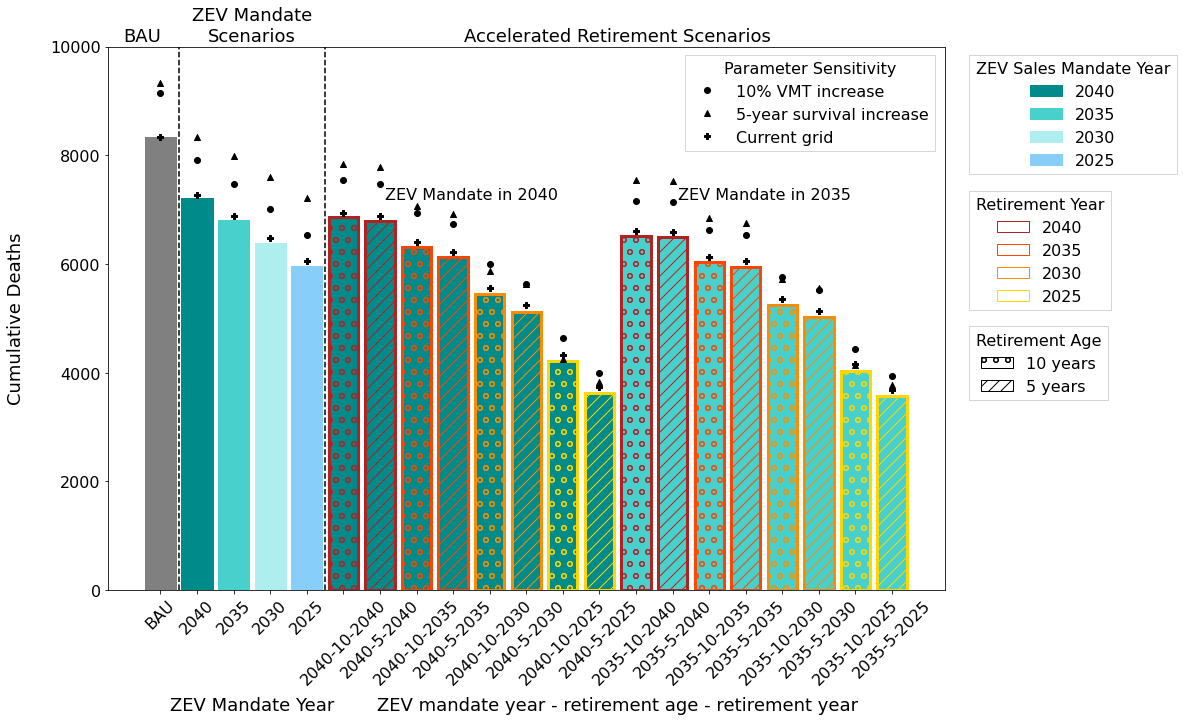

In [132]:
f, ax = plt.subplots(1,1, figsize = (15,10))


ax.bar(x= cum_deaths.ind_str, height = cum_deaths.cum_deaths,color = cum_deaths.color, 
       hatch = cum_deaths.hatch, edgecolor = cum_deaths.outline_color, linewidth = 3)
ax.scatter(cum_deaths_vmt.ind_str, cum_deaths_vmt.cum_deaths, color = "black", marker = "o")
ax.scatter(cum_deaths_surv.ind_str, cum_deaths_surv.cum_deaths, color = "black",marker = "^")
ax.scatter(cum_deaths_grid.ind_str, cum_deaths_grid.cum_deaths, color = "black",marker = "P")
ax.vlines(0.5,0,10000, linestyles = "dashed", color = "black")
ax.vlines(4.5,0,10000, linestyles = "dashed", color = "black")
ax.set_ylim([0,10000])
plt.xticks(rotation = 45)
ax.text(-0.5,10000*1.01,"BAU", fontsize = 18, ha = "center")
ax.text(2.5,10000*1.01,"ZEV Mandate\nScenarios", fontsize = 18, ha = "center")
ax.text(12.5,10000*1.01,"Accelerated Retirement Scenarios", fontsize = 18,ha = "center")
ax.set_ylabel("Cumulative Deaths\n", fontsize = 18)
ax.text(8.5,10000*0.72,"ZEV Mandate in 2040", fontsize = 16, ha = "center")
ax.text(16.5,10000*0.72,"ZEV Mandate in 2035", fontsize = 16, ha = "center")


handles = [
    mpatches.Patch(facecolor=zy_cols[3], hatch='', edgecolor=zy_cols[3], label = "2040"),
    mpatches.Patch(facecolor=zy_cols[2], hatch='', edgecolor=zy_cols[2], label = "2035"),
    mpatches.Patch(facecolor=zy_cols[1], hatch='', edgecolor=zy_cols[1], label = "2030"),
    mpatches.Patch(facecolor=zy_cols[0], hatch='', edgecolor=zy_cols[0], label = "2025"),
        
]

handles2 = [
    mpatches.Patch(facecolor="white", hatch='', edgecolor=ry_cols[3], label = "2040"),
    mpatches.Patch(facecolor="white", hatch='', edgecolor=ry_cols[2], label = "2035"),
    mpatches.Patch(facecolor="white", hatch='', edgecolor=ry_cols[1], label = "2030"),
    mpatches.Patch(facecolor="white", hatch='', edgecolor=ry_cols[0], label = "2025"),

    
]

handles3 = [
    mpatches.Patch(facecolor="white", hatch=ra_hatch[1], edgecolor = "black", label = "10 years"),
    mpatches.Patch(facecolor="white", hatch=ra_hatch[0], edgecolor="black", label = "5 years"),
    
]

handles5 = [
    plt.Line2D([], [], marker='o', color="black", linestyle = None,label='10% VMT increase', linewidth = 0),
    plt.Line2D([], [], marker='^', color="black", linestyle = None, label='5-year survival increase', linewidth = 0),
    plt.Line2D([], [], marker='P', color="black", linestyle = None, label='Current grid', linewidth = 0)
    
]

# handles4 = [
#     mpatches.Patch(facecolor="gray", hatch='', edgecolor="gray", label = "ICE Tailpipe Emissions"),
#     mpatches.Patch(facecolor="gray", hatch='', edgecolor="gray", alpha = 0.5, label = "Electricity Generation Emissions")
# ]


zy_cols = ["lightskyblue","paleturquoise","mediumturquoise","darkcyan"]#["gold","thistle","mediumturquoise","lightcoral"]
ry_cols = ["gold","darkorange","orangered","firebrick"]#["midnightblue","orange","brown","pink"]
ra_hatch = ["//","o"]




# handles = [
#     mpatches.Patch(facecolor='red', hatch='/', edgecolor='black', label = "2025"),
#     mpatches.Patch(facecolor='green', hatch='\\', edgecolor='black'),
#     mpatches.Patch(facecolor='blue', hatch='|', edgecolor='black'),
#     mpatches.Patch(facecolor='yellow', hatch='-', edgecolor='black'),
#     plt.Line2D([], [], linestyle='dashed', color='black'),
#     plt.Line2D([], [], marker='', color='white', label='BAU'),
#     plt.Line2D([], [], marker='', color='white', label='ZEV Mandate Scenarios'),
#     plt.Line2D([], [], marker='', color='white', label='Accelerated Retirement Scenarios')
# ]

# Create the legend and add it to the plot
# l1.get_title().set_ha('left')
l2 = ax.legend(handles=handles2, loc='upper left', bbox_to_anchor=(1.02, 0.75), title = "Retirement Year", fancybox = False, fontsize = 16)
l2.get_title().set_fontsize(16)
# l2.get_title().set_ha('left')
l3 = ax.legend(handles=handles3, loc='upper left', bbox_to_anchor=(1.02, 0.5), title = "Retirement Age", fancybox = False, fontsize = 16)
l3.get_title().set_fontsize(16)
# l3.get_title().set_ha('left')
# l4 = ax.legend(handles=handles4, loc='upper left', bbox_to_anchor=(1.02, 1), title = "Emissions Type", fancybox = False, fontsize = 14)
# l4.get_title().set_fontsize(14)
# l4.get_title().set_ha('left')
l4 = ax.legend(handles=handles5, loc='upper left', bbox_to_anchor=(0.68, 1), title = "Parameter Sensitivity", fancybox = False, fontsize = 16)
l4.get_title().set_fontsize(16)
l1 = ax.legend(handles=handles, loc='upper left', bbox_to_anchor=(1.02, 1), title = "ZEV Sales Mandate Year", fancybox = False, fontsize = 16)
l1.get_title().set_fontsize(16)




ax.add_artist(l3)
ax.add_artist(l2)
ax.add_artist(l4)


for tick in ax.get_yticklabels():
    tick.set_fontsize(16)
for tick in ax.get_xticklabels():
    tick.set_fontsize(16)
    
ax.text(2.5, -10000*0.22, "ZEV Mandate Year", fontsize = 18, ha = "center")
ax.text(12.5, -10000*0.22,"ZEV mandate year - retirement age - retirement year", fontsize = 18, ha = "center")

#plt.tight_layout()
f.savefig("final_figs/cumulative_deaths_scen.pdf", bbox_inches = "tight")

# plt.gca().add_artist(l1)
# plt.gca().add_artist(l2)

In [118]:
deaths_map = pm25_fossil["T6"].copy()
for v in ["T6_OOS","T7","T7_OOS","T7_Port","LHD1","LHD2","MC","MH","Buses"]:
    deaths_map["TotalPM25"]+=pm25_fossil[v]["TotalPM25"]
    deaths_map["deathsK"]+=pm25_fossil[v]["deathsK"]
deaths_map["deathsK_pc"] = deaths_map["deathsK"]/deaths_map["Population"]*100000

In [119]:
deaths_map_d = attach_demographics(deaths_map, demographics)

In [120]:
deaths_map_ca = deaths_map_d[deaths_map_d.STATEFP=="06"]

In [121]:
counties = gpd.read_file("tl_2019_us_county.shp")

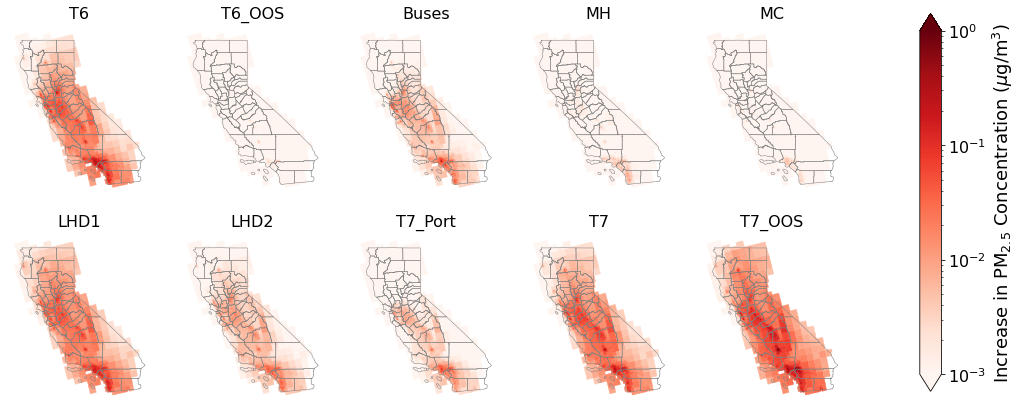

In [135]:
from matplotlib import colors
f, ax = plt.subplots(2,5, figsize = (15,7))
ax = ax.flatten()
for i,v in enumerate(veh_types):    
    counties[counties.STATEFP=="06"].boundary.plot(color = "gray", ax = ax[i], linewidth = 0.5)
    df = attach_demographics(pm25_fossil[v], demographics)
    df = df[df.STATEFP=="06"]
    df["deathsK_pc"] = df["deathsK"]/df["Population"]*1000000
    vmax = 1#np.ceil(df["TotalPM25"].quantile([0.75])[0.75])
    df.plot(column = "TotalPM25", vmax = 1, cmap = "Reds", ax = ax[i], 
                   norm = colors.LogNorm(vmin = 1e-3, vmax = vmax), edgecolor="face", linewidth=0.4)
    ax[i].axis("off")
    ax[i].set_title(v, fontsize = 16)
    
sm = plt.cm.ScalarMappable(cmap = "Reds", norm = colors.LogNorm(vmin = 1e-3, vmax = vmax))
cax = f.add_axes([0.97, 0.15, 0.02, 0.75])
cbar = f.colorbar(sm, cax = cax, extend = "both")
cbar.ax.tick_params(labelsize = 16)
cbar.set_label("Increase in PM$_{2.5}$ Concentration ($\mu$g/m$^3$)", fontsize = 18)   
f.savefig("final_figs/pm25_2019_all.pdf", bbox_inches = "tight")

In [ ]:
bau_stock = {}
for f in ["Diesel","Gasoline","Natural Gas","Electricity"]:
    bau_stock[f] = BAU_all[BAU_all.fuel_type==f].groupby(["year",
                                                          "veh_type"]).agg({"stock":"sum"}).reset_index().pivot(
        index = "year", columns = ["veh_type"], values = "stock")
    bau_stock[f] = bau_stock[f]/1000

In [ ]:
f, ax = plt.subplots(2,5, figsize = (15,6))
ax = ax.flatten()

letters = ["A","B","C","D","E","F","G","H","I","J"]
for i, v in enumerate(veh_types):
    ax[i].bar(bau_stock["Diesel"].index, bau_stock["Diesel"][v], label = "Diesel", width = 0.9)
    ax[i].bar(bau_stock["Gasoline"].index, bau_stock["Gasoline"][v], bottom = bau_stock["Diesel"][v], label = "Gasoline", width = 0.9)
    ax[i].bar(bau_stock["Natural Gas"].index, bau_stock["Natural Gas"][v], bottom = bau_stock["Diesel"][v]+bau_stock["Gasoline"][v],
      label = "Natural Gas", width = 0.9)
    ax[i].bar(bau_stock["Electricity"].index, bau_stock["Electricity"][v], bottom = bau_stock["Diesel"][v]+bau_stock["Gasoline"][v]+
      bau_stock["Natural Gas"][v], label = "Electricity", width = 0.9)
    #l1 = ax[i].legend(loc='upper left', bbox_to_anchor=(1.02, 1), title = "Fuel Type", fancybox = False, fontsize = 14)
    

    for tick in ax[i].get_yticklabels():
        tick.set_fontsize(14)
    for tick in ax[i].get_xticklabels():
        tick.set_fontsize(14)
    # ax[i].set_ylabel("Vehicle Stock", fontsize = 14)
    ax[i].set_title(f"{letters[i]}) {v}",fontsize = 16)


f.supylabel("Vehicle Stock\n(Thousands)", fontsize = 14, ha = "center")
l1 = ax[4].legend(loc='upper left', bbox_to_anchor=(1.02, 1), title = "Fuel Type", fancybox = False, fontsize = 14)
l1.get_title().set_fontsize(14)

plt.tight_layout()
f.savefig("veh_stock_bau.pdf", bbox_inches = "tight")

In [ ]:
p =BAU_all.loc[(BAU_all.year==2019) & (BAU_all.veh_type=="T6"),["age","stock","fuel_type"]].pivot(index = "age", columns = "fuel_type", values = "stock")

In [ ]:
for v in veh_types:
    f, ax = plt.subplots(1,1,figsize = (10,5))
    p =BAU_all.loc[(BAU_all.year==2019) & (BAU_all.veh_type==v),
                   ["age","stock","fuel_type"]].pivot(index = "age", 
                                                      columns = "fuel_type", 
                                                      values = "stock")[["Diesel","Gasoline","Natural Gas","Electricity"]]
    p = p/1000
    p.plot(
        kind = "bar", stacked = True, ax = ax)
    l = ax.legend(title = "Fuel Type", fontsize = 14)
    l.get_title().set_fontsize (14)
    ax.set_xlabel("Vehicle Age", fontsize = 14)
    ax.set_ylabel ("Vehicle Stock in 2019 \n(Thousands)", fontsize = 14)
    ax.set_xlim([-0.5,44.5])
    
    for tick in ax.get_xticklabels():
        tick.set_fontsize(14)
        tick.set_rotation(90)
    for tick in ax.get_yticklabels():
        tick.set_fontsize(14)
    ax.set_title(v,fontsize = 16)
    
    f.savefig(f"init_vintage_{v}.png")


In [242]:
BAU_stock = pd.DataFrame(index = np.arange(2019,2046), columns = veh_types)

In [248]:
for y in BAU_stock.index:
    for v in BAU_stock.columns:
        BAU_stock.loc[y,v] = BAU_all.loc[(BAU_all.year==y) & (BAU_all.veh_type==v),"stock"].sum()/1e6

In [253]:
BAU_vmt = pd.DataFrame(index = np.arange(2019,2046), columns = veh_types)

In [256]:
for y in BAU_vmt.index:
    for v in BAU_vmt.columns:
        BAU_vmt.loc[y,v] = BAU_all.loc[(BAU_all.year==y) & (BAU_all.veh_type==v),"vmt"].sum()/1e9

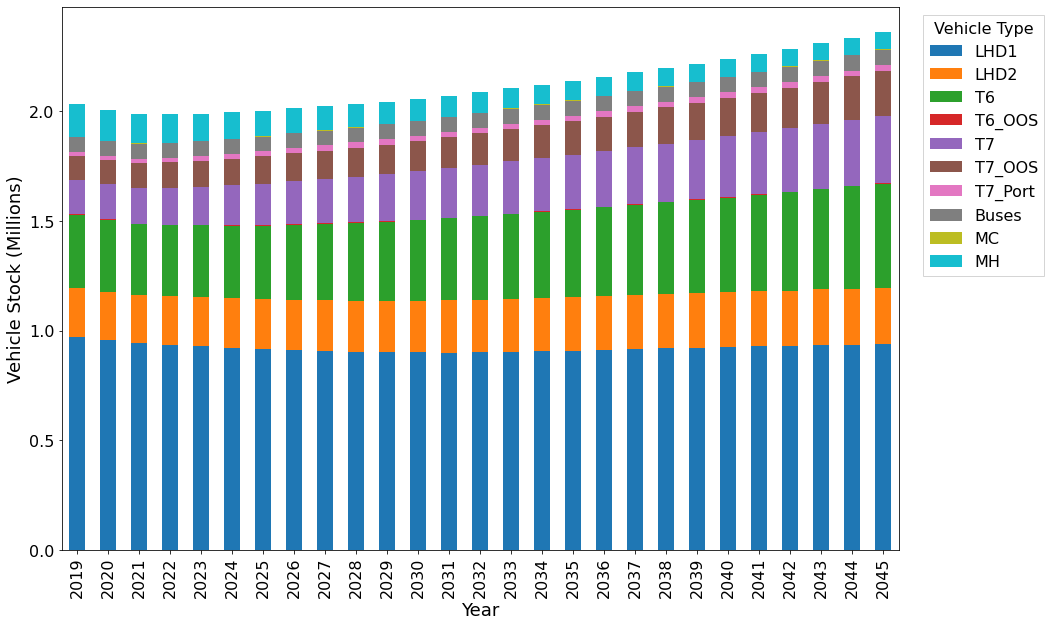

In [261]:
f, ax = plt.subplots(1,1, figsize = (15,10))
BAU_stock[["LHD1","LHD2","T6","T6_OOS","T7","T7_OOS","T7_Port","Buses","MC","MH"]].plot(kind = "bar", stacked = True, ax = ax)
ax.set_ylabel("Vehicle Stock (Millions)", fontsize = 18)
ax.set_xlabel("Year", fontsize = 18)

l1 = ax.legend(loc='upper left', bbox_to_anchor=(1.02, 1), title = "Vehicle Type", fancybox = False, fontsize = 16)
l1.get_title().set_fontsize(16)

for tick in ax.get_yticklabels():
    tick.set_fontsize(16)
for tick in ax.get_xticklabels():
    tick.set_fontsize(16)

f.savefig("final_plots/bau_stock.pdf", bbox_inches = "tight")

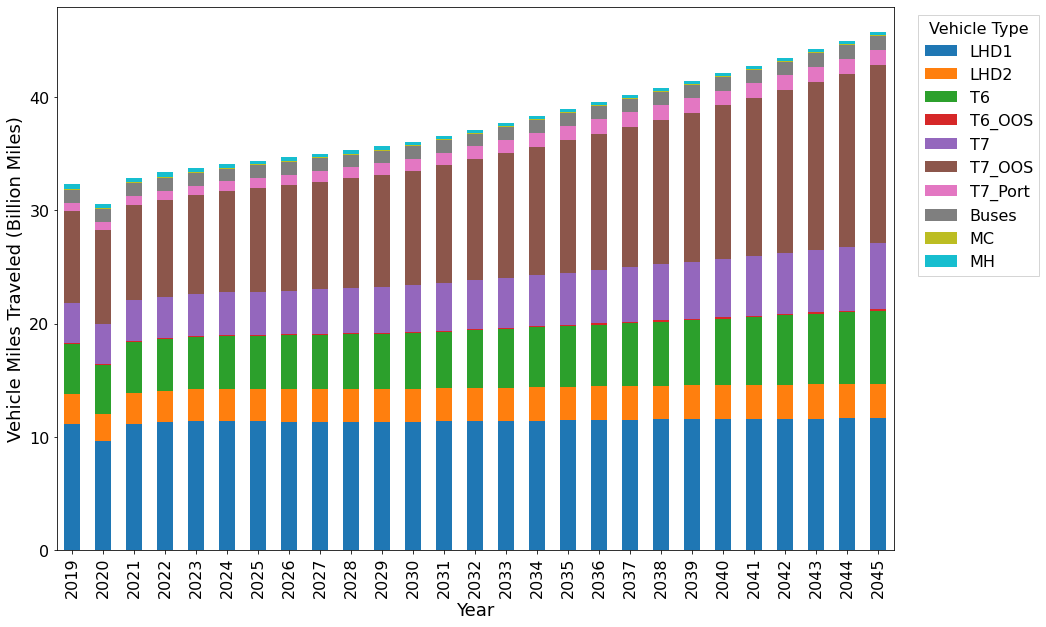

In [262]:
f, ax = plt.subplots(1,1, figsize = (15,10))
BAU_vmt[["LHD1","LHD2","T6","T6_OOS","T7","T7_OOS","T7_Port","Buses","MC","MH"]].plot(kind = "bar", stacked = True, ax = ax)
ax.set_ylabel("Vehicle Miles Traveled (Billion Miles)", fontsize = 18)
ax.set_xlabel("Year", fontsize = 18)

l1 = ax.legend(loc='upper left', bbox_to_anchor=(1.02, 1), title = "Vehicle Type", fancybox = False, fontsize = 16)
l1.get_title().set_fontsize(16)

for tick in ax.get_yticklabels():
    tick.set_fontsize(16)
for tick in ax.get_xticklabels():
    tick.set_fontsize(16)
f.savefig("final_plots/bau_vmt.pdf", bbox_inches = "tight")

In [25]:
deaths_2019 = 0
for v in results["BAU"].keys():
    deaths_2019+=(results["BAU"][v]["Fossil"].loc[2019,["deathsK_CA","deathsK_OCA"]].sum()
        +results["BAU"][v]["Elec"].loc[2019,["deathsK_CA","deathsK_OCA"]].sum())